In [ ]:
import sys
import os
working_directory = os.path.dirname(os.getcwd())
sys.path.append(working_directory)

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import geopandas as gpd
import networkx as nx
from shapely.geometry import Point

import pickle
# import module from the parent directory

In [3]:
# reload the library
import importlib
import topoMap

importlib.reload(sys.modules['topoMap'])
from topoMap import computeTransLimit

In [58]:
shenzhen_grid = gpd.read_file('../data/ss_city_grid/ss_city_grid_by_cover.shp')
shenzhen_area = shenzhen_grid.dissolve()

In [92]:
with open('../product/topoMap/topo_cluster.pkl', 'rb') as f:
    topoMapResult = pickle.load(f)

In [46]:
key = list(topoMapResult.keys())[0]
res = list(topoMapResult.values())[0]

In [71]:
def drawNetworkOnMap(topoKey, topoVal, baseshape=shenzhen_area, alpha=0.2):
    transitionProbsEdit, id_coorders_mapping_edit, stationary, cluster_labels = topoVal
    keylist = list(id_coorders_mapping_edit.keys())
    
    # average the coordinates of the points in each cluster
    labpos = [np.where(cluster_labels == lab)[0] for lab in np.unique(cluster_labels)]
    transitionClust = np.empty((len(labpos), len(labpos)))
    for i in range(len(labpos)):
        source = transitionProbsEdit[labpos[i], :].mean(axis=0)
        for j in range(len(labpos)):
            transitionClust[i, j] = source.take(labpos[j]).sum()
            
    transitionClust /= transitionClust.sum(axis=1)[:, None]
    weight = computeTransLimit(transitionClust).real
    transitionCorrected = transitionClust * weight

    # ref 矩阵中的累积最小值
    # search the position where sits the smallest values whose cumulated sum is larger than 0.05
    threshold = 0.5
    transitionCorrectedFlatten = transitionCorrected.flatten()
    sorted = np.sort(transitionCorrectedFlatten)
    cut_pos = len(np.where(np.cumsum(sorted) <= threshold)[0])
    smalllest_idx = np.argsort(transitionCorrectedFlatten)[:cut_pos]
    # transitionCorrectedFlatten[smalllest_idx] = np.nan
    smalllest_idx_2d = np.unravel_index(smalllest_idx, transitionCorrected.shape)

    weighgFlatten = weight.flatten()
    sorted = np.sort(weighgFlatten)
    cut_pos = len(np.where(np.cumsum(sorted) <= threshold)[0])
    smalllest_idx_weight = np.argsort(weighgFlatten)[:cut_pos]

    transAdj = transitionCorrected.copy()
    transAdj[smalllest_idx_2d] = 0

    # get the average position of the points in each cluster
    cluster_coords_array = []
    for onelab2pos in labpos:
        cluster_coords_list = [id_coorders_mapping_edit[keylist[onepos]] for onepos in onelab2pos]
        cluster_coords = np.array(cluster_coords_list).mean(axis=0)
        cluster_coords = tuple(cluster_coords.tolist())
        cluster_coords_array.append(cluster_coords)

    def drawNetworkOnMap(alpha):
        print("Function starts.")

        # Create a graph from the CSV data
        G = nx.DiGraph()
        for i, coord in enumerate(cluster_coords_array):
            if not np.isin(i, smalllest_idx_weight):
                G.add_node(str(coord), pos=coord, weight=weight[i, 0])

        # count = 10
        size = len(cluster_coords_array)
        for i in range(size):
            if np.isin(i, smalllest_idx_weight):
                continue
            for j in range(size):
                if i != j and not np.isin(j, smalllest_idx_weight):
                    weight_value = transAdj[i, j]
                    if weight_value > 0:
                        G.add_edge(str(cluster_coords_array[i]), str(cluster_coords_array[j]), weight=weight_value)
        # Extract and scale weights for the edges
        weights = [G[u][v]['weight'] for u, v in G.edges()]
        print("weights: ", weights)
        alphaw = np.interp(weights, (min(weights), max(weights)), (0, 1))
        # Extract the size weighs for the nodes
        node_size = [G.nodes[n]['weight'] for n in G.nodes()]
        print("node_size: ", node_size)
        node_size = np.log(np.array(node_size))
        node_size = np.interp(node_size, (min(node_size), max(node_size)), (10, 100))
        # Position
        pos = nx.get_node_attributes(G, 'pos')
        # Plot the network on the map
        
        f, ax = plt.subplots(1, 1, figsize=(10, 10))
        nx.draw_networkx_nodes(G, pos, ax=ax, node_size=node_size)
        nx.draw_networkx_edges(G, pos, width=3, alpha = alphaw, edge_color=weights, 
                            edge_vmax=max(weights),
                            edge_cmap=plt.cm.Reds, arrows=True, arrowstyle='-|>', ax=ax)
        # set the title of the figure
        ax.set_title('Topo Cog Map of {who} on {date:8d}'.format(who=topoKey[0], date=topoKey[1]))
        baseshape.plot(ax=ax, linewidth=1, alpha=alpha)
        return f
    
    return drawNetworkOnMap(alpha=alpha)

In [107]:
import imageio
from io import BytesIO
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas

def fig_to_image(fig):
    canvas = FigureCanvas(fig)
    canvas.draw()  # 将 figure 渲染到 canvas
    buf = canvas.buffer_rgba()  # 获取缓冲区中的 RGBA 图像数据
    width, height = fig.get_size_inches() * fig.get_dpi()
    image = np.frombuffer(buf, dtype=np.uint8).reshape(int(height), int(width), 4)  # 转换为 numpy 数组并重塑为图像大小
    return image[:, :, :3]  # 去掉 alpha 通道，返回 RGB 图像

Function starts.
weights:  [0.018341759120359534, 0.01370342701134013, 0.010174846063812856, 0.00829611282690623, 0.008396813138316778, 0.013047574613305636, 0.007359256826119587, 0.008025672851813366, 0.009191369296808449, 0.009946494891585193, 0.00748871811964263, 0.015310134453850906, 0.01861663234044894, 0.008666701439779878, 0.009765095916210857, 0.013347365097455446, 0.008814212278704601]
node_size:  [0.11281198898162083, 0.10003303644552734, 0.09218261337070616, 0.11271984229193621, 0.09464668750962396]
Function starts.
weights:  [0.015544791005267651, 0.018052517885304334, 0.007901040408733935, 0.008781057869020238, 0.01579026987753667, 0.010766747320866656, 0.016865199437455066, 0.01195247215261498, 0.010674634614342728, 0.012011083537055392, 0.015386933057368648, 0.010434437064238989, 0.012058073667890593, 0.01762987241712211, 0.00851618287249866, 0.01306211322897272, 0.015171744968288027, 0.01146420565239006, 0.007522557110973134, 0.010067914891277441]
node_size:  [0.1210828

/tmp/ipykernel_2110797/2050317144.py:77: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, width=3, alpha = alphaw, edge_color=weights,
/tmp/ipykernel_2110797/2050317144.py:77: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, width=3, alpha = alphaw, edge_color=weights,
/tmp/ipykernel_2110797/2050317144.py:77: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, width=3, alpha = alphaw, edge_color=weights,


Function starts.
weights:  [0.011933628276584346, 0.014453137111258658, 0.014088712675996116, 0.010507514646619654, 0.018041054054102168, 0.010698699587830726, 0.007355312790692944, 0.016684774166203627, 0.012395660275289416, 0.014482758536414281, 0.01014966337099733, 0.009057636244629881, 0.009811998029506438, 0.013187692661231794, 0.010492318003664397, 0.007349929322673945, 0.015905674313179963, 0.008913995355684688, 0.0062506440449700655]
node_size:  [0.12589145705060037, 0.10764863742581175, 0.12205285447586114, 0.08767658875296533, 0.10205100910489588]
Function starts.
weights:  [0.01668786080880009, 0.01241915417116392, 0.006418801999909654, 0.013222605696842705, 0.010652780356770407, 0.01700425573918139, 0.009582917355874509, 0.011536437133974235, 0.019014531286404047, 0.013510064784215799, 0.011565747625685092, 0.011503329824511242, 0.008349873852186962, 0.006543240874210558, 0.009707347079833896, 0.005322148667164366, 0.015547313175543392, 0.012875149537952655]
node_size:  [0.

/tmp/ipykernel_2110797/2050317144.py:77: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, width=3, alpha = alphaw, edge_color=weights,
/tmp/ipykernel_2110797/2050317144.py:77: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, width=3, alpha = alphaw, edge_color=weights,
/tmp/ipykernel_2110797/2050317144.py:77: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, width=3, alpha = alphaw, edge_color=weights,
/tmp/ipykernel_2110797/2050317144.py:77: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, width=3, alpha = alphaw, edge_color=weights,


Function starts.
weights:  [0.007068144664380491, 0.017551459591380054, 0.003427130234262416, 0.009388610888662077, 0.0075070466705027756, 0.009537616655319069, 0.009781129463128882, 0.014526601416283418, 0.008460845142560186, 0.013040380688858225, 0.006379658587186167, 0.014347402313138495, 0.012760391603883668, 0.018283361570953904, 0.009444790461868377, 0.008566869253966061, 0.00424061217410672, 0.011296106871813049, 0.007880505731631562]
node_size:  [0.12471450697206647, 0.07870189204923292, 0.09951258679441301, 0.13154927767126454, 0.07065274688768855]
Function starts.
weights:  [0.015214201189095866, 0.014591831553545402, 0.006431542388431447, 0.014201077599158701, 0.007811435157470456, 0.018042107610146733, 0.011215835722053667, 0.0070747589304498044, 0.003353761814607273, 0.013061757732508707, 0.013110452437635771, 0.005514481245165055, 0.007990058618079924, 0.0053157622088143485, 0.007060819497847296, 0.005947789486722393, 0.004325210284604862, 0.004622095325827077, 0.00517821

/tmp/ipykernel_2110797/2050317144.py:77: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, width=3, alpha = alphaw, edge_color=weights,
/tmp/ipykernel_2110797/2050317144.py:77: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, width=3, alpha = alphaw, edge_color=weights,


Function starts.
weights:  [0.007106759798582511, 0.007870022523773756, 0.011024703363954414, 0.01516059830812288, 0.010222088415506828, 0.005395699805353445, 0.006435018816525663, 0.006733193850528326, 0.006568132050397363, 0.00817677591075889, 0.00478688053201309, 0.004920395454672067, 0.005880087783484203, 0.005133863828413102, 0.009235103244049787, 0.008566575905924575, 0.007901858379912249, 0.00991364912644651, 0.0032497409365254944, 0.009993337700619172, 0.010298085473616013, 0.00809973105891354, 0.006525316130831855, 0.008941080728368984, 0.010526127114919279, 0.00605788324043137, 0.006665315884962286, 0.007896435279395297, 0.008301639857909911]
node_size:  [0.12266346787138258, 0.08527479779855404, 0.07555027337424206, 0.07805582064954329, 0.09812687643620932, 0.06549065238230783]
Function starts.
weights:  [0.00425844951007771, 0.006803986649072774, 0.004337760711611797, 0.004703011838240713, 0.005409884539385238, 0.0038034307728758614, 0.009154508190855074, 0.0052180690133736

/tmp/ipykernel_2110797/2050317144.py:77: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, width=3, alpha = alphaw, edge_color=weights,
/tmp/ipykernel_2110797/2050317144.py:77: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, width=3, alpha = alphaw, edge_color=weights,


Function starts.
weights:  [0.009970968334647074, 0.00821927381474994, 0.023129714674995812, 0.013419246771088427, 0.007576357006862803, 0.009720256129484024, 0.0035930068441213927, 0.009862761051259295, 0.003614592413497364, 0.0038527151451186736, 0.009272314726243118, 0.004805904837823356, 0.008878122438512413, 0.00447592553291014, 0.027325634752519742, 0.008191686573687674, 0.009205600586828457, 0.008390494680352132, 0.009770894766988978, 0.013997650830909997, 0.0032312866325825197, 0.0035935945456642138, 0.008226615942365767, 0.0043255201600268574, 0.01167720243694241, 0.003339898903793105, 0.004118357283089497, 0.008818112090695662, 0.0035232796581333814]
node_size:  [0.1641372820922639, 0.058525208929626274, 0.06363819568790033, 0.1439019093709459, 0.06147011077481161, 0.06161482376231537]
Function starts.
weights:  [0.009828955694793707, 0.0103643046182283, 0.015695898224462216, 0.008425141800075482, 0.011008731682119414, 0.011639387303700737, 0.004981725834286396, 0.00672016557

/tmp/ipykernel_2110797/2050317144.py:77: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, width=3, alpha = alphaw, edge_color=weights,
/tmp/ipykernel_2110797/2050317144.py:77: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, width=3, alpha = alphaw, edge_color=weights,


Function starts.
weights:  [0.00449010311727964, 0.0037831398987058992, 0.007341356746979662, 0.0065989647554475315, 0.006431556153608742, 0.004696551983593361, 0.0039302314501476, 0.0069289383205670355, 0.006907911364479238, 0.006410023971845653, 0.004576528507357149, 0.005972044508256858, 0.006882092105262952, 0.00773323311038661, 0.006576298302086242, 0.005123702792879762, 0.007383303612533074, 0.010168157011546964, 0.0036891179051389933, 0.016376569249828752, 0.004856695131587964, 0.0056605552973484465, 0.0043941320699178305, 0.007155234950334321, 0.006543091554029649, 0.007679378655479754, 0.008772685777686674, 0.007061425827382807, 0.01113710963188727, 0.009189614695927434]
node_size:  [0.06527841658087755, 0.07055507926118809, 0.07023758439046827, 0.11532530742966841, 0.07169069105064305, 0.10886540772731695]
Function starts.
weights:  [0.00977773068894068, 0.005176631699769915, 0.004179962699592227, 0.011028244883937695, 0.004762394385248518, 0.0068129638306547976, 0.0054204906

/tmp/ipykernel_2110797/2050317144.py:77: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, width=3, alpha = alphaw, edge_color=weights,
/tmp/ipykernel_2110797/2050317144.py:77: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, width=3, alpha = alphaw, edge_color=weights,


Function starts.
weights:  [0.022852847665002993, 0.017799477486342873, 0.003374762354318485, 0.01036131692121556, 0.008460597741734443, 0.021745798878807423, 0.007543406754140598, 0.008677393361085264, 0.007869709259612676, 0.00896523432203457, 0.010672818880601289, 0.008858914483470665, 0.005299546648523978, 0.0038365541872466477, 0.004198167341191434, 0.008599612883746638, 0.006719108608108567, 0.002766067150664319, 0.003153781165323631, 0.0034441948965634223, 0.011734685424558796, 0.009191906129554176, 0.004966956402239199, 0.004231407135817472, 0.010692478860217038, 0.00831048205280847, 0.003832281816572557, 0.003723155942797041, 0.003992664187660987]
node_size:  [0.16696079192240174, 0.12958094237084322, 0.06792360893943557, 0.05215393777849343, 0.06341398247856056, 0.0625823222275969]
Function starts.
weights:  [0.007662243713887868, 0.008488926092235295, 0.002391866109851754, 0.002960403496606989, 0.002742211361764955, 0.005572201305504028, 0.02304492198869155, 0.01583945855562

/tmp/ipykernel_2110797/2050317144.py:77: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, width=3, alpha = alphaw, edge_color=weights,
/tmp/ipykernel_2110797/2050317144.py:77: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, width=3, alpha = alphaw, edge_color=weights,


Function starts.
weights:  [0.0028832038324035467, 0.008089919062625779, 0.0077043125281047176, 0.003315896711545601, 0.0022799590865136454, 0.0024541092041796813, 0.00418210858533958, 0.008955451214920794, 0.008337383546895373, 0.0035388814161082583, 0.0025644357940714166, 0.002618699554048602, 0.008894779316392043, 0.007089821456860051, 0.018097029218828, 0.00835911813448503, 0.005010690158240072, 0.006457741644409723, 0.005649835862282059, 0.011584668143287033, 0.017975941027166417, 0.005499042195498444, 0.006930084901081727, 0.007459794352449871, 0.003140262268479696, 0.002881971138597046, 0.0079754990262081, 0.008493966745752523, 0.0026995785026209824, 0.0030671706345634887, 0.002528776351714484, 0.002472160291261988, 0.005452068156022305, 0.006175035920935191, 0.0028455063826367043, 0.0021120507916693406, 0.003227404112088102, 0.00603576974294174, 0.00917839395597312, 0.003426985889313125, 0.0030538317983857047]
node_size:  [0.056657044034850085, 0.06011253745584927, 0.1327184347

/tmp/ipykernel_2110797/2050317144.py:77: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, width=3, alpha = alphaw, edge_color=weights,
/tmp/ipykernel_2110797/2050317144.py:77: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, width=3, alpha = alphaw, edge_color=weights,


Function starts.
weights:  [0.009730797236933875, 0.009851810480157713, 0.005411601963394579, 0.0036563405317507594, 0.006186488576024436, 0.021723767758370194, 0.011179528777055489, 0.016595584315285176, 0.011379099864512235, 0.025246600051679915, 0.014792519830150043, 0.010217982827359803, 0.005587111072535842, 0.014747772961681853, 0.015266723737295781, 0.005161702760721723, 0.0053310729177546866, 0.011962263139104009, 0.012864759073232715, 0.006445372578147282]
node_size:  [0.060789526558645314, 0.15311479639577522, 0.15286170908354219, 0.08981673564165453, 0.07414546571009727]
Function starts.
weights:  [0.011972071553539881, 0.01777103923689837, 0.02221073655664728, 0.004079993123883395, 0.014706786391195131, 0.007663655277296603, 0.016749572496654295, 0.005698927796769228, 0.015067536459980593, 0.008428108905277128, 0.017527872867309616, 0.006836047995717912, 0.0252799557591334, 0.015790678899862232, 0.015165007149243391, 0.011346832159427648, 0.00855749953095435, 0.005100889752

/tmp/ipykernel_2110797/2050317144.py:77: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, width=3, alpha = alphaw, edge_color=weights,
/tmp/ipykernel_2110797/2050317144.py:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f, ax = plt.subplots(1, 1, figsize=(10, 10))
/tmp/ipykernel_2110797/2050317144.py:77: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, width=3, alpha = alphaw, edge_color=weights,
/tmp/ipykernel_2110797/2050317144.py:77: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` i

Function starts.
weights:  [0.009416282924398769, 0.018211722889905767, 0.008663907279700617, 0.0065786657374729855, 0.010258977909919014, 0.010163012620293383, 0.011092404730291496, 0.006438279852489832, 0.003779001314979721, 0.006817356961207773, 0.01962494566005816, 0.014314815178792612, 0.005596671603192677, 0.005322474401724803, 0.003133364696799092, 0.006836909012246461, 0.004592229368367523, 0.008888943065897447, 0.002942480397559817, 0.0026662821714064293, 0.005965423425796699, 0.0031921710582857865, 0.0071451171615435965, 0.0038745025836384337, 0.003221312723084111, 0.0068607547686921665, 0.003749764038224585, 0.00753402624850992, 0.0036514055967793004, 0.002667034604454267]
node_size:  [0.1298429553528503, 0.079286921696745, 0.14917753812190462, 0.05580866538593788, 0.047308128728915065, 0.05320194648063658]
Function starts.
weights:  [0.002580056885451571, 0.009967467830841837, 0.008891785676184748, 0.0034145823227305686, 0.004232507356838349, 0.004471576847257124, 0.0107187

/tmp/ipykernel_2110797/2050317144.py:77: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, width=3, alpha = alphaw, edge_color=weights,
/tmp/ipykernel_2110797/2050317144.py:77: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, width=3, alpha = alphaw, edge_color=weights,


Function starts.
weights:  [0.01461554919031384, 0.009615524506236801, 0.006722618989522826, 0.006251045956754751, 0.003349387307026039, 0.0162993572354588, 0.019049187804738445, 0.003739323158579657, 0.006308551475515268, 0.008445171937424426, 0.010269693248385779, 0.018676003920563927, 0.006829017575715819, 0.006211415965104527, 0.004842452572988855, 0.0038766026348769985, 0.007534617776289503, 0.005193794669405218, 0.00236572888258345, 0.0018844950541408612, 0.0043435648774959555, 0.008391508298243094, 0.005123982838991451, 0.0018673911644141753, 0.002901801829580924, 0.005332857869670838, 0.008890095919732575, 0.0052178372921582485, 0.0018625120058976719]
node_size:  [0.08790170465301894, 0.1637759876119934, 0.11170214139945897, 0.044997840692277406, 0.048109123585866165, 0.048093187941753615]
Function starts.
weights:  [0.007215207736038308, 0.007849998017095154, 0.003271186565256271, 0.0018009115335767014, 0.003132379093932729, 0.002230288902766713, 0.006917458716679312, 0.020259

/tmp/ipykernel_2110797/2050317144.py:77: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, width=3, alpha = alphaw, edge_color=weights,
/tmp/ipykernel_2110797/2050317144.py:77: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, width=3, alpha = alphaw, edge_color=weights,


Function starts.
weights:  [0.00702038054176123, 0.012269227252064927, 0.0049387179849726395, 0.009516409401387689, 0.008420699613155667, 0.014056089499058542, 0.005606993307459823, 0.01486929458767989, 0.010694869242077468, 0.014266434754353435, 0.007689217586100107, 0.017104053235025726, 0.0035265427408210067, 0.005638824554577461, 0.008168213002749818, 0.006873880425229975, 0.011025305016647372, 0.013795852224648363, 0.015685257791058914, 0.004877313192452073]
node_size:  [0.07599052548905129, 0.10204598674185306, 0.14061418326118164, 0.05342526176818988, 0.12941751193175616]
Function starts.
weights:  [0.005206457391295217, 0.0017841733870147813, 0.00561389351565638, 0.0024584834065110458, 0.00216190748051455, 0.0042429394124847255, 0.008877737259551217, 0.005889945873496339, 0.01767003876319511, 0.009668428167789322, 0.00813397145527814, 0.009191470781233798, 0.0018981363325827904, 0.006962472163482196, 0.004034767642747794, 0.002908920927258466, 0.006984936729447793, 0.0019144190

/tmp/ipykernel_2110797/2050317144.py:77: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, width=3, alpha = alphaw, edge_color=weights,
/tmp/ipykernel_2110797/2050317144.py:77: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, width=3, alpha = alphaw, edge_color=weights,


Function starts.
weights:  [0.005004011633788145, 0.007203005558433679, 0.007775457077514566, 0.015714531351370152, 0.004841626770080638, 0.008205610413182352, 0.005595792705213255, 0.0018365277588398953, 0.0027956312366452987, 0.004989764830317841, 0.002111606752902787, 0.0027276445651128684, 0.007607646897028518, 0.001873269365346518, 0.0037405015746508822, 0.007033213266989174, 0.0026819810098444225, 0.0034685573549095424, 0.007992590756714475, 0.001927682959224858, 0.0028398078416849103, 0.0078104942574077916, 0.0031600654568126564, 0.0044345889079850775, 0.013431571022498, 0.006376688804437422, 0.007170685482352589, 0.004924940701744843, 0.003433238210207665, 0.007682433526179682, 0.004212473637535987, 0.002305441857627339, 0.00255356844644973, 0.004754430316773493, 0.0026462800387569547, 0.007788653873088892, 0.0022598928858741612, 0.003207472685531965, 0.004390915962295527, 0.007409399771456927]
node_size:  [0.1242868219267859, 0.0394755083283949, 0.05388383904176678, 0.06018594

/tmp/ipykernel_2110797/2050317144.py:77: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, width=3, alpha = alphaw, edge_color=weights,
/tmp/ipykernel_2110797/2050317144.py:77: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, width=3, alpha = alphaw, edge_color=weights,


Function starts.
weights:  [0.011376185286767086, 0.01414936165424756, 0.014831653132292672, 0.008445430153468438, 0.0048071070564453, 0.007307491128023899, 0.010072122081259023, 0.005635541438247602, 0.006385668792379546, 0.0031187465552960647, 0.001996091431590099, 0.002982623710409819, 0.013054931305409056, 0.005756368286316252, 0.007487413291929135, 0.003894444135154498, 0.0031152064773977087, 0.0046167940553447865, 0.011014756392216721, 0.0025686153393904686, 0.004279672228097521, 0.004378567301179465, 0.004109487752023944, 0.007806417495715493, 0.00833397498587315, 0.003795556706725698, 0.0045465602406098505, 0.0051144680002239, 0.0023878812175014267, 0.00623045360739726, 0.0027508629851193214, 0.003512709755273173, 0.003770099530822061, 0.0019671592088521673, 0.009523953332432146, 0.0034601487095095402, 0.003988517318205493, 0.004237530144195202, 0.0028494555994440065, 0.0020744339659484524]
node_size:  [0.16106871139767112, 0.0614316560938648, 0.07720630489212311, 0.09024642208

/tmp/ipykernel_2110797/2050317144.py:77: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, width=3, alpha = alphaw, edge_color=weights,
/tmp/ipykernel_2110797/2050317144.py:77: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, width=3, alpha = alphaw, edge_color=weights,


Function starts.
weights:  [0.014375445460188405, 0.016338435740227884, 0.022054051902993966, 0.03062002455297883, 0.018679477576408976, 0.027246983689884492, 0.011520429472196428, 0.018567050607395885, 0.01255270886865516, 0.020596931761560782, 0.01828376187928164]
node_size:  [0.10190932008527055, 0.13446165447847994, 0.13773944818370512, 0.11162027801068754, 0.10582346553201706]
Function starts.
weights:  [0.00985058551373172, 0.008491161214068942, 0.010795214005554733, 0.01780617352170391, 0.02296933941549984, 0.0166100837568782, 0.009863761115353132, 0.011020163883712504, 0.014894077433325027, 0.008923948537588563, 0.025448782427919713, 0.0182929042348843, 0.00911205438830448, 0.014885268819813892, 0.009152958846927408, 0.025579937537767748, 0.009993707149985763, 0.007316865893853948]
node_size:  [0.0908217639728946, 0.1485430688517806, 0.11932801528825403, 0.08598203727919242, 0.12804901808388375]
Function starts.
weights:  [0.007648443208206978, 0.008156623805654921, 0.005933109

/tmp/ipykernel_2110797/2050317144.py:77: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, width=3, alpha = alphaw, edge_color=weights,
/tmp/ipykernel_2110797/2050317144.py:77: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, width=3, alpha = alphaw, edge_color=weights,
/tmp/ipykernel_2110797/2050317144.py:77: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, width=3, alpha = alphaw, edge_color=weights,


Function starts.
weights:  [0.011034215169672646, 0.013825472276641845, 0.011736882407947825, 0.006473334567583703, 0.013998434211529113, 0.0098312889572116, 0.005431888799121205, 0.005792337808029999, 0.015010033883845435, 0.007248305477753041, 0.005584048365345911, 0.011961425240634501, 0.011146931195106744, 0.00601307781112121, 0.0058777061984016344, 0.015804428031541844, 0.00795079547020752, 0.007649619686454681, 0.005461727160873361]
node_size:  [0.16127931529498174, 0.08718503749380942, 0.10152847884814568, 0.06452693371429019, 0.0988367711060436]
Function starts.
weights:  [0.007517728699966239, 0.016888463866333796, 0.010185773663920667, 0.01396507681972669, 0.012268564408395815, 0.006853274934185135, 0.005683754992824571, 0.013930282263208053, 0.013080294125347539, 0.00859169943773011, 0.01291910180936916, 0.012326253110438784, 0.009227957087719087, 0.01277803575083858, 0.007158835267613975, 0.009577768081416303, 0.01066742286792408, 0.006921352445721327, 0.007025283970505988]

/tmp/ipykernel_2110797/2050317144.py:77: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, width=3, alpha = alphaw, edge_color=weights,
/tmp/ipykernel_2110797/2050317144.py:77: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, width=3, alpha = alphaw, edge_color=weights,
/tmp/ipykernel_2110797/2050317144.py:77: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, width=3, alpha = alphaw, edge_color=weights,
/tmp/ipykernel_2110797/2050317144.py:77: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, width=3, alpha = alphaw, edge_color=weights,


Function starts.
weights:  [0.008016278074670771, 0.01017003978210891, 0.017224772432694057, 0.010732673138590599, 0.008471224370298775, 0.008414838935546148, 0.019570707016368535, 0.009545651992779854, 0.0096703317924721, 0.01443423205159479, 0.013856840771513095, 0.010476431785708416, 0.012431840183537284, 0.010549436093261451, 0.01156717111325139, 0.014094981226463917, 0.014991497590590928, 0.013817113086280657, 0.021213410168402384]
node_size:  [0.0970662792087079, 0.10391368799638248, 0.09308332480378549, 0.10817300419078933, 0.15122321284190957]
Function starts.
weights:  [0.010359101281098935, 0.005932335350005389, 0.013747931612171612, 0.0100037138229708, 0.006889710163989377, 0.0063348155989283285, 0.009744601124453306, 0.02344419088823907, 0.007022655952438861, 0.006970025450771037, 0.01263583919339139, 0.00755612544288153, 0.013234149290707984, 0.006459063862528333, 0.030253931864715124, 0.01180857417880279, 0.018133479796124216, 0.012548963092182718, 0.019977607331425368]
n

/tmp/ipykernel_2110797/2050317144.py:77: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, width=3, alpha = alphaw, edge_color=weights,
/tmp/ipykernel_2110797/2050317144.py:77: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, width=3, alpha = alphaw, edge_color=weights,


Function starts.
weights:  [0.011382751103132962, 0.02213520112370144, 0.007953619206129693, 0.0076730302353507085, 0.00846788093974245, 0.008277870923873628, 0.007842461117183546, 0.008843678095543168, 0.005781775209950434, 0.015084646151695238, 0.010144440910341682, 0.013064845727289057, 0.00925225375151525, 0.008360621142672617, 0.008198301704128429, 0.007472516143590672, 0.013419480510560182, 0.005620241931913952, 0.011763359126894257, 0.005679641814093271, 0.007357539503341059, 0.007770553955296102, 0.00467736392051549, 0.0070693116516049835, 0.008551821907083604, 0.011622497605213049, 0.004326277777822229]
node_size:  [0.11496434946907058, 0.09059300057599065, 0.14342482792619124, 0.07170461972843653, 0.07436552185909774, 0.0676200771501579]
Function starts.
weights:  [0.00872733880465007, 0.004705682830842082, 0.008629802247441748, 0.004298182099692558, 0.00910998070679382, 0.0063446167779450365, 0.003964470964503541, 0.010048564602899336, 0.007411046476073725, 0.006424896081859

/tmp/ipykernel_2110797/2050317144.py:77: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, width=3, alpha = alphaw, edge_color=weights,
/tmp/ipykernel_2110797/2050317144.py:77: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, width=3, alpha = alphaw, edge_color=weights,


Function starts.
weights:  [0.00957789780795876, 0.003521365202975561, 0.009284702939578542, 0.004667681244428365, 0.01427347641984485, 0.007947457337909221, 0.03133222095235005, 0.008879065561300612, 0.00548014008915879, 0.009034166586971941, 0.01137293262846512, 0.0044017689401052475, 0.011094617810404135, 0.023542720372475383, 0.012755519975998619, 0.0076294357091400795, 0.006669287035500828, 0.006693277162840595, 0.011094109596107429]
node_size:  [0.0873335467945058, 0.14662128652357348, 0.06209185695739554, 0.15078920518090128, 0.058944513448643876]
Function starts.
weights:  [0.016272195788222595, 0.020832093129139247, 0.011982238472890145, 0.007467602724196707, 0.013328833030293061, 0.009947725861495076, 0.006730860512257916, 0.0065438694759682465, 0.018566613289631495, 0.01278489225453624, 0.00870025812739331, 0.00462917683599367, 0.008435187564521995, 0.009109223885729135, 0.009897402204449379, 0.004557345885547478, 0.005164020093793957, 0.0045460178231223605, 0.00413073765453

/tmp/ipykernel_2110797/2050317144.py:77: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, width=3, alpha = alphaw, edge_color=weights,
/tmp/ipykernel_2110797/2050317144.py:77: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, width=3, alpha = alphaw, edge_color=weights,
/tmp/ipykernel_2110797/2050317144.py:77: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, width=3, alpha = alphaw, edge_color=weights,


Function starts.
weights:  [0.005893906591244258, 0.006230176075082339, 0.0047154637379263524, 0.009670945101474815, 0.02439947041768874, 0.010127396551304967, 0.011374572478469444, 0.008260866157898407, 0.031113394902962034, 0.01182704633663306, 0.008889922862591116, 0.004965772377145013, 0.008849738138064913, 0.008791170654721793, 0.004377688951582558, 0.004091293795981654, 0.014736875493731079, 0.006641842475828158, 0.006942060963075937]
node_size:  [0.05615091469077084, 0.16802522366171574, 0.13628380908335302, 0.08298658016319575, 0.06986011243963501]
Function starts.
weights:  [0.014708967903880606, 0.009302298172902426, 0.011247360450192407, 0.025715727041751863, 0.010776457814550559, 0.004629508355152067, 0.0048386446411467785, 0.010748468585345942, 0.006512482989550987, 0.004774093116571549, 0.007622594604548691, 0.014065642968253494, 0.007616933645383229, 0.0064796906748102135, 0.03191801044986744, 0.015504902562718144, 0.0055441897740289275, 0.008568253528986889]
node_size: 

/tmp/ipykernel_2110797/2050317144.py:77: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, width=3, alpha = alphaw, edge_color=weights,
/tmp/ipykernel_2110797/2050317144.py:77: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, width=3, alpha = alphaw, edge_color=weights,
/tmp/ipykernel_2110797/2050317144.py:77: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, width=3, alpha = alphaw, edge_color=weights,
/tmp/ipykernel_2110797/2050317144.py:77: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, width=3, alpha = alphaw, edge_color=weights,


Function starts.
weights:  [0.0151783323954783, 0.007066648816668643, 0.028902840405482605, 0.007559539365611459, 0.014047467836108999, 0.005530351110363471, 0.009018028402470313, 0.004044808251204325, 0.007890707584953468, 0.005636537960745801, 0.011511465430132302, 0.0265102050233989, 0.012346611200587722, 0.00843337848192566, 0.0057585505658357666, 0.005729354161906099, 0.0045194883910449225, 0.007835627736616288]
node_size:  [0.1624428809021752, 0.0931324406169812, 0.05704961248671231, 0.1521867937742779, 0.04705440667026414]
Function starts.
weights:  [0.005227912924999652, 0.00798135154806266, 0.004749024582866833, 0.00999728547535268, 0.007262610363523993, 0.005004275882425297, 0.010720770512590221, 0.005062346697908868, 0.006757933038870295, 0.010152676367738821, 0.008129782028619562, 0.00789847615719534, 0.012192913547957786, 0.018349103788658307, 0.005347274192553274, 0.003161094874405529, 0.006856731647866296, 0.0043821657622398775, 0.0075476347015556045, 0.00825526925059659

/tmp/ipykernel_2110797/2050317144.py:77: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, width=3, alpha = alphaw, edge_color=weights,
/tmp/ipykernel_2110797/2050317144.py:77: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, width=3, alpha = alphaw, edge_color=weights,


Function starts.
weights:  [0.005507664507609204, 0.004991296451484796, 0.006056993471541331, 0.007726480602229571, 0.015036076252009298, 0.003879227558078719, 0.0034129964491333743, 0.0038685165877431083, 0.00822937394045657, 0.005874279186373691, 0.005618758301845754, 0.0047574723004031715, 0.007473092366636208, 0.009632592133295377, 0.008032986796907997, 0.003824769928421763, 0.004296969859069461, 0.005696526813491458, 0.006069178672589993, 0.013837606282976804, 0.006199286122279028, 0.00546848680954722, 0.0077430217014992945, 0.019631003039598766, 0.01154167740332477, 0.0065694126261298495, 0.00837785978510989, 0.007516101960513771, 0.018045601158780778]
node_size:  [0.1005856279196937, 0.045944959587915425, 0.06230780222315987, 0.06785305611946713, 0.12329004967691198, 0.12802720329585135]
Function starts.
weights:  [0.004458036507019931, 0.007548522122386416, 0.00360878258783632, 0.006644001809358259, 0.0028698674251144717, 0.003981190316780206, 0.006736686049198341, 0.0047907199

/tmp/ipykernel_2110797/2050317144.py:77: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, width=3, alpha = alphaw, edge_color=weights,
/tmp/ipykernel_2110797/2050317144.py:77: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, width=3, alpha = alphaw, edge_color=weights,


Function starts.
weights:  [0.003427111047989992, 0.01354357017476972, 0.008640331916150653, 0.005479020898467578, 0.0041204034917555355, 0.0042803726679808436, 0.005942975831472167, 0.004904118134653341, 0.003806593915657108, 0.009439267777582288, 0.007958459479389305, 0.01998370258038413, 0.009318809356585224, 0.006392704935524763, 0.0070874821570535845, 0.007464916079638035, 0.022099107926127896, 0.008127911500393376, 0.005249469322534553, 0.0060361999818391585, 0.0036837848703262016, 0.008549892764718549, 0.00634702750527135, 0.0035657740579647696, 0.003466148458572575, 0.003001833781900127, 0.009010760026134969, 0.005097369794401565, 0.003932161975314204]
node_size:  [0.07266160731380161, 0.05185926701608215, 0.15475748722189053, 0.12167474125126532, 0.07478375558438614, 0.05112769946398965]
Function starts.
weights:  [0.005932397665018477, 0.0033473052481936623, 0.013066935751363454, 0.008522783131443811, 0.005067467502039238, 0.006311696309276022, 0.0036843746156975305, 0.009352

/tmp/ipykernel_2110797/2050317144.py:77: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, width=3, alpha = alphaw, edge_color=weights,
/tmp/ipykernel_2110797/2050317144.py:77: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, width=3, alpha = alphaw, edge_color=weights,


Function starts.
weights:  [0.012274939384225036, 0.006983502029678761, 0.025071338249283433, 0.00829585592298062, 0.011683888934073312, 0.005109457218118857, 0.010422744688273833, 0.004468784101435911, 0.007420563512719425, 0.004031151290382571, 0.008934462867603655, 0.0040804744010628224, 0.0217693834680279, 0.010106796643961887, 0.0056569947712167565, 0.010469111277378056, 0.009555210257218649, 0.005779276521183577, 0.003427573980218481, 0.010774310140192101]
node_size:  [0.15062409854687836, 0.08387442606020744, 0.0502242411768451, 0.15412864486975067, 0.06480485546084414]
Function starts.
weights:  [0.005640632975443862, 0.007862518297985689, 0.006429467845582839, 0.005663103295875014, 0.01921419969891768, 0.01809270343768502, 0.006333643421377281, 0.0071072054728016166, 0.017356085041305886, 0.02529518086936144, 0.00622949024830026, 0.008742038523351679, 0.02202560547732586, 0.021039076710079076, 0.0068964043479920875, 0.004497277068638155, 0.0076496998410937, 0.00658996055232130

/tmp/ipykernel_2110797/2050317144.py:77: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, width=3, alpha = alphaw, edge_color=weights,
/tmp/ipykernel_2110797/2050317144.py:77: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, width=3, alpha = alphaw, edge_color=weights,
/tmp/ipykernel_2110797/2050317144.py:77: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, width=3, alpha = alphaw, edge_color=weights,


Function starts.
weights:  [0.026104799656221474, 0.006223236151403412, 0.014340840921928054, 0.028446646314104113, 0.01971509944002178, 0.02230415860733072, 0.008681857927396447, 0.013413526055128772, 0.007646542961647747, 0.01387894494399608, 0.02285790551146151, 0.007847627732800214]
node_size:  [0.13141386900884694, 0.20706775845898567, 0.07040337605367263, 0.10906634762570101]
Function starts.
weights:  [0.025365006675625953, 0.010740973794644297, 0.01825410980973416, 0.01882194999392748, 0.023722542905156522, 0.004883270910040516, 0.01147276559123997, 0.006721033943860379, 0.008597881940440139, 0.006250146395039763, 0.004484890701470203, 0.0037451651621618824, 0.018967365711364776, 0.01025141947156356, 0.004253440974736817, 0.007808491558201612, 0.013088868623761211, 0.009002815230934482, 0.003449990689403814, 0.007268606516366814]
node_size:  [0.19371021702860108, 0.12245963909219965, 0.045273828033532096, 0.09622338940483477, 0.07342961713832812]
Function starts.
weights:  [0.0

/tmp/ipykernel_2110797/2050317144.py:77: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, width=3, alpha = alphaw, edge_color=weights,
/tmp/ipykernel_2110797/2050317144.py:77: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, width=3, alpha = alphaw, edge_color=weights,


Function starts.
weights:  [0.011233599322051565, 0.024811690466798597, 0.014993270572377263, 0.006499596265870032, 0.009927617723300057, 0.00828677425508291, 0.006275146689576388, 0.003315763178399528, 0.019979761463881352, 0.006237846705135464, 0.019810404770344056, 0.0053638282611746186, 0.01698132201707036, 0.006835616884673557, 0.0146489282115808, 0.005070607801825601, 0.006773997398078996, 0.003980899788141653, 0.007155245415897498, 0.004312754168254967]
node_size:  [0.1528341717850753, 0.07072151172093082, 0.1392195881081602, 0.1078191108327986, 0.04511526009060349]
Function starts.
weights:  [0.006647194055122685, 0.005640915843125684, 0.004827783388452309, 0.005930453103209698, 0.005499597787894098, 0.004085430642012346, 0.0029313970156728416, 0.005953000977505009, 0.007904483110992847, 0.0035570254643190065, 0.005418254605578593, 0.007998084913903592, 0.005089075808858617, 0.030103711104235466, 0.012323872649203704, 0.006508470285768943, 0.004515046350482875, 0.00471044470014

/tmp/ipykernel_2110797/2050317144.py:77: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, width=3, alpha = alphaw, edge_color=weights,
/tmp/ipykernel_2110797/2050317144.py:77: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, width=3, alpha = alphaw, edge_color=weights,


Function starts.
weights:  [0.012910917598057983, 0.00518721790552569, 0.008510359608271744, 0.029606953371131516, 0.006901222569760153, 0.015592583711253119, 0.0043252541989353965, 0.0054302447143454525, 0.013050439740441218, 0.005791276059902159, 0.006110511127880181, 0.00388673447095924, 0.0031486684953501752, 0.007875704393960162, 0.006199608097758395, 0.004786575967886762, 0.005795520813186349, 0.020788305733732595, 0.017339548729828656, 0.0047391308309405215, 0.00475654188294525, 0.007756945771448474, 0.005145956110436991, 0.004028648340711561, 0.003780892523162359]
node_size:  [0.14581292775403043, 0.10918640347775574, 0.04248284922612721, 0.0478686359282451, 0.14070947232474695, 0.036155344592547024]
Function starts.
weights:  [0.004723996077254095, 0.004382837465090987, 0.0022634242954711215, 0.004581276043922978, 0.004201045897597558, 0.00812475702971031, 0.009677360891348385, 0.00653319385141727, 0.02222478767945393, 0.004760336164773435, 0.004811617798223848, 0.003517665295

/tmp/ipykernel_2110797/2050317144.py:77: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, width=3, alpha = alphaw, edge_color=weights,
/tmp/ipykernel_2110797/2050317144.py:77: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, width=3, alpha = alphaw, edge_color=weights,


Function starts.
weights:  [0.00424359998066418, 0.002160807821397616, 0.004617486677581172, 0.0031426547290242697, 0.0034714320887233026, 0.0021542787135365835, 0.00327388328427328, 0.004627574812410873, 0.0073580819565529495, 0.006523567774860895, 0.00894081433249157, 0.0020226729175716125, 0.005251384147397642, 0.00479807516569775, 0.004598346856624301, 0.005864891276883132, 0.0023605138601288846, 0.004989305002339, 0.009234390574306386, 0.004658763348521726, 0.007397374176636497, 0.007762462254423604, 0.0047624898317617775, 0.003511896531241168, 0.010369272519860074, 0.004306286414047867, 0.007852785503792757, 0.009354742734869097, 0.003929686958865672, 0.004394847703320601, 0.007219178831523144, 0.004490757770988068, 0.009910597314568993, 0.007821605376993607, 0.0045228922765619154, 0.002157130693412503, 0.003832251987352838, 0.0019407854450004085, 0.00410029515528575, 0.0034209290119219153, 0.0033276921307023905]
node_size:  [0.046196810911431324, 0.0720985753512284, 0.0503561239

/tmp/ipykernel_2110797/2050317144.py:77: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, width=3, alpha = alphaw, edge_color=weights,
/tmp/ipykernel_2110797/2050317144.py:77: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, width=3, alpha = alphaw, edge_color=weights,


Function starts.
weights:  [0.006323383015107938, 0.0057055760053282495, 0.004158782608177638, 0.003935863350509585, 0.007111666990061998, 0.01988754807149291, 0.012497421285468902, 0.011606309548152482, 0.002896776643910934, 0.007623771397685504, 0.006700959744453929, 0.004517782938373476, 0.005098473843372152, 0.006831322576739906, 0.014331871259282026, 0.008639501356519462, 0.009277464058538657, 0.01053782640534178, 0.0031752706082564695, 0.010631605987897204, 0.0030532214564172287, 0.008984658518519793, 0.0068096583576827225, 0.004958042072647954, 0.010713351692755928, 0.006343321198637346, 0.009555276858145794, 0.00859488497348073]
node_size:  [0.0430732451826619, 0.1377235648475073, 0.058722092155164815, 0.12237097172002473, 0.07060050089446877, 0.09204677804700481]


/tmp/ipykernel_2110797/2050317144.py:77: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, width=3, alpha = alphaw, edge_color=weights,


Function starts.
weights:  [0.004022325533306841, 0.005418385089474093, 0.004718397740312988, 0.0061721691510061, 0.004121762957024381, 0.00767863363564662, 0.0049387603268265, 0.011252773780072053, 0.006056423810755825, 0.005413268681208901, 0.003986066715016792, 0.012242720729390703, 0.0052218241159834216, 0.005082653266137268, 0.004868508405673771, 0.006505086848987869, 0.006956247702591766, 0.0068153949617268395, 0.005477379210804707, 0.0036650338783239802, 0.007270935488832036, 0.007607417429692497, 0.003956391412962562, 0.0041449222704862095, 0.004764316163925925, 0.005661611789547955, 0.003944405589724435, 0.004851631816319573, 0.007064491709038983, 0.013450165944956169, 0.0057917753861302075, 0.0038133416039033497]
node_size:  [0.060490124756623055, 0.08612123276539134, 0.08276425377256878, 0.07784549124018168, 0.07015086635408876, 0.06850942586244835, 0.06883811210569038]


/tmp/ipykernel_2110797/2050317144.py:77: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, width=3, alpha = alphaw, edge_color=weights,
/tmp/ipykernel_2110797/2050317144.py:77: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, width=3, alpha = alphaw, edge_color=weights,


Function starts.
weights:  [0.006552660524813134, 0.006464723831549411, 0.006214846574513549, 0.008075503252761696, 0.01111220345250122, 0.005994336048965088, 0.00396375890861831, 0.006031423412329396, 0.007251582869169757, 0.00768799658351175, 0.008883508004331006, 0.007931368959888862, 0.006335421228735432, 0.01179644935401534, 0.012996441058449746, 0.005970288874725726, 0.005395641334822742, 0.01021985743071916, 0.011810492536356392, 0.012896245153768512, 0.007876370658563045, 0.005629202299408556, 0.005410973438353707, 0.011816936717280884]
node_size:  [0.08485562017410339, 0.05939527432099638, 0.06818143502244653, 0.08839712638270474, 0.08999662292120654, 0.11487289546173785]
Function starts.
weights:  [0.020213069116997613, 0.012641912463093194, 0.005551075581632141, 0.011355858744387139, 0.0030531536712419607, 0.020843086911053337, 0.014778892489965117, 0.004866138743078493, 0.016451773157322692, 0.0028239384588796424, 0.012708402838007836, 0.0171222581870733, 0.0040846474579192

/tmp/ipykernel_2110797/2050317144.py:77: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, width=3, alpha = alphaw, edge_color=weights,
/tmp/ipykernel_2110797/2050317144.py:77: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, width=3, alpha = alphaw, edge_color=weights,


Function starts.
weights:  [0.0055783605111798, 0.013699532479957238, 0.012728396373680163, 0.015331726002524197, 0.00818622854443099, 0.007228805355520379, 0.009010826715414916, 0.0042976020036630345, 0.00376879094285522, 0.007329328695993159, 0.0028227105532381436, 0.007823669420619855, 0.0028186295142756217, 0.004731698017835175, 0.007265684770299215, 0.003310210082490951, 0.013285540991423376, 0.0039611164147141525, 0.00559225791630532, 0.010133736738814791, 0.0036282951474767215, 0.004623581679727069, 0.01606846252023942, 0.005064140827576903, 0.012140237228945111, 0.009154112472909816, 0.005479715475897064, 0.006445000787262189, 0.007824656510782213, 0.0038377424570712033, 0.003695126855733307, 0.0054126779749520135, 0.0032145197876083985, 0.004488472425594627, 0.004289981709234436, 0.004345509907127931, 0.0029587830768675227]
node_size:  [0.13910803161539623, 0.055676966085306145, 0.06484597228193203, 0.07847052480967237, 0.1129678564584347, 0.04780471440449418, 0.04855685837341

/tmp/ipykernel_2110797/2050317144.py:77: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, width=3, alpha = alphaw, edge_color=weights,
/tmp/ipykernel_2110797/2050317144.py:77: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, width=3, alpha = alphaw, edge_color=weights,


Function starts.
weights:  [0.005797380057609706, 0.0037135967221500806, 0.0053894714518084265, 0.007860134263372806, 0.0049782329526497915, 0.004912301579878989, 0.004621351380785223, 0.0035933114375817058, 0.00510131863105073, 0.007426879720528208, 0.005077661536492649, 0.005681602525275746, 0.005319793122519057, 0.002785422466101954, 0.003756360408912183, 0.006704557155597061, 0.004744416743639184, 0.0037248211262244564, 0.004883273177367621, 0.0042935909011890165, 0.004457593301387687, 0.009096523955771853, 0.005274901687931224, 0.006509406113822054, 0.006526416064988261, 0.008207182668741037, 0.007201275227270693, 0.010240460247894143, 0.00867316805537821, 0.008540268287051718, 0.004179621911408346, 0.0047809430319741475, 0.0037913281025424342, 0.005653840827905219, 0.008169021283781969, 0.005964246002615591, 0.004674402291896077, 0.006174895794141783, 0.004714967559149088, 0.007577978216096995, 0.008927762700591374, 0.006282356441657394]
node_size:  [0.06566070992881982, 0.067122

/tmp/ipykernel_2110797/2050317144.py:77: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, width=3, alpha = alphaw, edge_color=weights,
/tmp/ipykernel_2110797/2050317144.py:77: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, width=3, alpha = alphaw, edge_color=weights,


Function starts.
weights:  [0.008567685570826513, 0.007161181894915822, 0.0052676682536628265, 0.004482115728573657, 0.008406114063515933, 0.019258550453580086, 0.011714462806172188, 0.013039335836019236, 0.007293711307380175, 0.01690193148097027, 0.009707348844624639, 0.01099684706403352, 0.0051929348160314245, 0.012481821015540094, 0.012142153988098373, 0.007663521248885966, 0.0043231134583528105, 0.011843329535161581, 0.009830858823021918, 0.007046291871498207]
node_size:  [0.057114935318824764, 0.14883793503370274, 0.126469609468366, 0.09091755099279752, 0.07741210625339436]
Function starts.
weights:  [0.005545906458942172, 0.007378325744399122, 0.0051317246741826575, 0.0028522991352452507, 0.006682926855930127, 0.019189221640758508, 0.005482346769831263, 0.010702299828252134, 0.011187462633812697, 0.0072131626370228385, 0.021982398532532248, 0.006693098472803768, 0.01207398859768992, 0.012545877923869016, 0.005413571636367129, 0.0075951127672282855, 0.004575120898906627, 0.0026551

/tmp/ipykernel_2110797/2050317144.py:77: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, width=3, alpha = alphaw, edge_color=weights,
/tmp/ipykernel_2110797/2050317144.py:77: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, width=3, alpha = alphaw, edge_color=weights,


Function starts.
weights:  [0.00535468523706946, 0.010381906765265337, 0.006163374713488253, 0.019877335023874888, 0.004428074152998525, 0.006474240699309152, 0.005322446914844449, 0.0026277839364531952, 0.00245476998771775, 0.00737323989601933, 0.009689446752349591, 0.002908723748918169, 0.003342110879177061, 0.011076849621634457, 0.002624492032251071, 0.003097130494611618, 0.007072034082434552, 0.0036349023758049043, 0.007291828041009855, 0.0020785524695532847, 0.02216933108134697, 0.006641905931905196, 0.01221411300404453, 0.006854749068996528, 0.005451966207479733, 0.006859750390547111, 0.005245083487330894, 0.0028046597304291344, 0.005546547115517682, 0.005520645162042281, 0.002485428240939924, 0.00212767696937433, 0.0070329329613121865]
node_size:  [0.1361278197182096, 0.04218757804581654, 0.06985786218568373, 0.04957780223572518, 0.15792415464304138, 0.037565788954064844, 0.03874817325490628]
Function starts.
weights:  [0.005038970487850961, 0.003486909478743204, 0.0017146434912

/tmp/ipykernel_2110797/2050317144.py:77: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, width=3, alpha = alphaw, edge_color=weights,
/tmp/ipykernel_2110797/2050317144.py:77: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, width=3, alpha = alphaw, edge_color=weights,


Function starts.
weights:  [0.0063710835268179465, 0.0035507666535415394, 0.007382275845470773, 0.011433619040529239, 0.0022218416911534197, 0.003896241900084525, 0.0018798097024344906, 0.00595459114008725, 0.0035083134916621024, 0.006738659305372231, 0.010120816272398865, 0.0020504063536466327, 0.002728191908662009, 0.001989798721569009, 0.004409129730094568, 0.00329526408677943, 0.004168810256379183, 0.006281095044719665, 0.0021448359547109144, 0.006740886091317072, 0.007463405914794693, 0.0038577861471073656, 0.012517015363763928, 0.0023031930938643345, 0.004015051021551121, 0.0023022199466236127, 0.01152988072773518, 0.010146689288938754, 0.005155314295692289, 0.011462872672705713, 0.004085346238075394, 0.006006869739862462, 0.0036613597972490596, 0.0029806029154316013, 0.002150269673185337, 0.0026925953251317144, 0.0037644063021071233, 0.0034252685604115214, 0.003059865596249418, 0.0015073939502598473, 0.003520684209959101, 0.005352400916106172, 0.0014752046973457713, 0.0026873204

/tmp/ipykernel_2110797/2050317144.py:77: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, width=3, alpha = alphaw, edge_color=weights,


Function starts.
weights:  [0.011464669643653985, 0.013127432637595358, 0.004607834107830309, 0.004300955281567321, 0.0033205183913027417, 0.0039756601605608856, 0.004619694807803104, 0.011017836221000369, 0.01188281939146957, 0.0033365825516581456, 0.004433647255063378, 0.0031081993675934503, 0.004435916416656305, 0.003828418479092437, 0.012149847300039847, 0.011379044340248624, 0.0038346259344277118, 0.004514485444536769, 0.0034446379811952396, 0.0037425630806157757, 0.005100583741018581, 0.003932284803899131, 0.0035445153936296703, 0.003702003906059872, 0.001502161651250928, 0.0016213016890153278, 0.0012291340526024094, 0.004838754932349922, 0.004109992318284068, 0.004587764275221871, 0.0013033767997497293, 0.0013003084797125204, 0.0016709371170269087, 0.0017595686469592273, 0.0034730398415696666, 0.003438065992857911, 0.0039574782425031915, 0.0013587480845354879, 0.001244726131989718, 0.0014066852574217848, 0.003917784093588893, 0.004435659201452628, 0.005030332829830265, 0.0019539

/tmp/ipykernel_2110797/2050317144.py:77: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, width=3, alpha = alphaw, edge_color=weights,
/tmp/ipykernel_2110797/2050317144.py:77: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, width=3, alpha = alphaw, edge_color=weights,


node_size:  [0.09902695549373207, 0.03746083761082341, 0.149896021323108, 0.059002525728081616, 0.030818199118840796, 0.04240093153208802, 0.029093971265714738, 0.03790168617936096, 0.03783244022080167]
Function starts.
weights:  [0.003485725022051734, 0.0034426309025038437, 0.0017175305403389761, 0.003494168150649011, 0.0050457818274836745, 0.0026916931853538466, 0.0017085652591993991, 0.001873669404545901, 0.0029853592514397106, 0.004294732403007271, 0.0032208467439579, 0.004167149175769329, 0.007734495483206668, 0.003203935395111714, 0.002822325502883178, 0.0020881635364584064, 0.0027796844256580706, 0.004078373253448408, 0.002378327239399901, 0.003944404254984498, 0.006849073353703193, 0.003489340070921591, 0.0020501625038448685, 0.0021979293341141447, 0.001796923239411126, 0.0029186166099154443, 0.0024717643550048345, 0.0025191534171178326, 0.003720366496552529, 0.002163331367377073, 0.001250186016063261, 0.0015318247300692546, 0.003472777777529027, 0.004312629816561481, 0.0039158

/tmp/ipykernel_2110797/2050317144.py:77: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, width=3, alpha = alphaw, edge_color=weights,


Function starts.
weights:  [0.0027990837422858152, 0.0031079054652006625, 0.0041378131114826145, 0.004129750273682655, 0.0018159144962609033, 0.0031596149135745587, 0.00416110052984202, 0.002633976413916312, 0.0037541585476394412, 0.004985729883765105, 0.004930095316443415, 0.0020790141202895415, 0.003909588940342048, 0.005729764152626543, 0.003277524472008682, 0.003837613401696247, 0.005676373216973738, 0.005386619181406828, 0.002403027203674494, 0.003766080386752745, 0.005995979583843387, 0.004233412154320946, 0.00542251874358438, 0.006078334222095413, 0.008002025666882753, 0.003452472530148115, 0.005894225853421649, 0.007720916007537352, 0.003558185322836291, 0.005156494189927994, 0.005406075104726534, 0.007297413424698421, 0.002823222911817652, 0.004636476218666104, 0.00884362022802227, 0.0018175415173990407, 0.0019458392095207438, 0.0022579002378480427, 0.0031516528191014, 0.0036284795665898323, 0.0025418436440550287, 0.003159793062146826, 0.003058669774244313, 0.00393581718542673

/tmp/ipykernel_2110797/2050317144.py:77: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, width=3, alpha = alphaw, edge_color=weights,
/tmp/ipykernel_2110797/2050317144.py:77: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, width=3, alpha = alphaw, edge_color=weights,


Function starts.
weights:  [0.00237627841681086, 0.004787770970229524, 0.0049219831233058954, 0.0024532911134981816, 0.006030100106732082, 0.00291229436530656, 0.005103780075752051, 0.0030331615839552964, 0.002143920436624814, 0.0017597939417070504, 0.0018298633751586777, 0.00231723155316103, 0.000934223504969949, 0.00233779485489301, 0.0008845778756380836, 0.001969131598741259, 0.004793952504494018, 0.0018370194536449405, 0.003627964840556781, 0.002145472417539538, 0.005127583897219025, 0.0031233434255810402, 0.004556571291409777, 0.0029941140547318237, 0.0023536991526776825, 0.004671113864904754, 0.0015212736677670479, 0.003681383178173634, 0.0020745683891795976, 0.0038557112063884566, 0.002679162882672866, 0.002693366693732046, 0.00241983061790877, 0.001833285211303268, 0.003147967502486312, 0.0009960362573993085, 0.0026220270652987042, 0.001575125147252525, 0.0024277552165665388, 0.0019021173066806189, 0.001649472938843497, 0.0015945022262315012, 0.00111111650225426, 0.005532230635

/tmp/ipykernel_2110797/2050317144.py:77: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, width=3, alpha = alphaw, edge_color=weights,


Function starts.
weights:  [0.00964238790149418, 0.006461412320219466, 0.009689863051704386, 0.00798266529251452, 0.007017407233663297, 0.006047157400215095, 0.005044432063660404, 0.011045670431006934, 0.0029335871880205987, 0.003932210560958979, 0.004345613698000884, 0.0028597898079488144, 0.0026635439132057293, 0.002242657347393014, 0.0063830133944320945, 0.0028508387630830976, 0.0029440007437131926, 0.0021502025312730867, 0.002208586917705934, 0.0017527489333612404, 0.001540748776116149, 0.009900844056031146, 0.00412535154441597, 0.0031356831349183445, 0.0034485932565125736, 0.0031783310560889117, 0.0027259903823055476, 0.002018610217830089, 0.00806692011265923, 0.004303836853992776, 0.002524534120960386, 0.0037493820046881426, 0.0028450035200411755, 0.002354568661480759, 0.0019017079361570476, 0.0074273681498944815, 0.003409948866678528, 0.0022713608952456762, 0.003020886865299274, 0.002533523321703187, 0.002163264339668917, 0.0016461902749625688, 0.005991404785761706, 0.0028271476

/tmp/ipykernel_2110797/2050317144.py:77: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, width=3, alpha = alphaw, edge_color=weights,


node_size:  [0.05864160267156891, 0.1445223475032475, 0.04361636991744775, 0.060502243647740865, 0.04142720636208257, 0.05439755487495243, 0.029603318589147352, 0.0375143238333042, 0.04773223643107466]


/tmp/ipykernel_2110797/2050317144.py:77: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, width=3, alpha = alphaw, edge_color=weights,


Function starts.
weights:  [0.0008993393275489412, 0.0007049565898421477, 0.0015244729937241698, 0.001292104751637846, 0.0026199977193799005, 0.0007984833271712578, 0.001352159744960295, 0.0010107695813622018, 0.0006648115388726074, 0.0009901639312791231, 0.001027536992082253, 0.0022102186297097348, 0.002004759452820932, 0.0008892837830202893, 0.004071328062467621, 0.0013720665026673142, 0.0018835465863612318, 0.0016169346658761624, 0.001055400565879816, 0.000971716250264276, 0.0009687775811688453, 0.001268437534548468, 0.0012769828142747037, 0.0006583321321386358, 0.002869392305905959, 0.0011384656975531632, 0.0013376586324685123, 0.0013204303014214174, 0.000877945931664063, 0.0008950669748305199, 0.0012744035358374477, 0.0021466450978793075, 0.0013977327750483626, 0.0027047083333417324, 0.0013568663572439356, 0.005664737394434477, 0.002223384293112643, 0.0032805509030815407, 0.0027226052934133118, 0.0018633023953667244, 0.0016616453991549613, 0.0011968064625710617, 0.0019037862665420

/tmp/ipykernel_2110797/2050317144.py:77: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, width=3, alpha = alphaw, edge_color=weights,


Function starts.
weights:  [0.0016500198632306872, 0.001660930198932044, 0.0009295393775597342, 0.003059447149315874, 0.0011869402779742819, 0.0010953740198336285, 0.0014858592732482187, 0.0013351847887022779, 0.0014172268548181344, 0.0037980567298239315, 0.001693977875870902, 0.006246943836344418, 0.0019356182270434947, 0.0017059272585241683, 0.0027699000252847258, 0.0032905241410539784, 0.0012664409479558366, 0.0020158114144103066, 0.004014112867867319, 0.0021449076639413036, 0.006361416935952889, 0.002962406864272419, 0.0021377418382750968, 0.004542774052695257, 0.0034487264635687537, 0.0017908716421072969, 0.0010352116078152273, 0.0018632188385446643, 0.00225517522402586, 0.003432046920691654, 0.0015530066894620625, 0.0010911147221666182, 0.0023138772347027596, 0.0019255332728153587, 0.0008231473011017013, 0.002783497672531574, 0.005014415775493073, 0.007327942682428107, 0.003640869417401738, 0.004701004617279952, 0.003724230167382393, 0.006391822056587766, 0.00577914580324474, 0.0

/tmp/ipykernel_2110797/2050317144.py:77: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, width=3, alpha = alphaw, edge_color=weights,


Function starts.
weights:  [0.0017160624538055359, 0.005467058714942786, 0.003412044847994676, 0.0018954204735061977, 0.0021198683122377517, 0.0019111020719028704, 0.003868940085133409, 0.003046867731494327, 0.0021092894349030765, 0.0023607013092697814, 0.002047705635864356, 0.002578511093369662, 0.0016788473935427394, 0.0009299492156880515, 0.0008885133855133398, 0.001717203127866176, 0.0011875329175065569, 0.006078894536316316, 0.0025126242416482186, 0.005872518229095867, 0.0029852018060523636, 0.003485290172639151, 0.0028172377123919356, 0.006005778565627313, 0.00485191972445588, 0.003453168816646496, 0.002590622642027025, 0.0031571302773973357, 0.0015718571337981471, 0.004807453275662187, 0.001740925094331015, 0.0019503787776628564, 0.0017543930337305471, 0.0038079409003127828, 0.0028640390871473567, 0.0017955344528781294, 0.002153996339001731, 0.0017694777070277959, 0.0029207010904015287, 0.0016693779479872168, 0.0009486787648682636, 0.00081859327781117, 0.0016859324919171795, 0.0

/tmp/ipykernel_2110797/2050317144.py:77: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, width=3, alpha = alphaw, edge_color=weights,


Function starts.
weights:  [0.0010669098646783608, 0.0008089471949633182, 0.002062305358819137, 0.0012873767591612963, 0.0006607137914478574, 0.0012313049321315479, 0.0013479276389916535, 0.000708382636871403, 0.0013342500303471258, 0.000971719557297902, 0.000894329407464638, 0.0010079862536224397, 0.0011203776867754925, 0.003172499557866626, 0.002069838697336044, 0.0012769102021462906, 0.0024429766603624686, 0.0024403356665237555, 0.0013566248442585412, 0.002625047779900854, 0.0015636643582556042, 0.0012349655989208983, 0.0007238232642278556, 0.0011060747016578278, 0.0019718305962551337, 0.001420144686148947, 0.0010073231191403001, 0.0015757450846662687, 0.0016184290559892417, 0.0006750809631563727, 0.0018063815660327716, 0.0011126293995304126, 0.0008531167109562162, 0.0017568005070623663, 0.0033256883778572744, 0.0019396185826028162, 0.003581268797964657, 0.0021970334905184598, 0.004250039914545814, 0.004258215099733617, 0.0024555325496572163, 0.00448874980987688, 0.00271814734109260

/tmp/ipykernel_2110797/2050317144.py:77: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, width=3, alpha = alphaw, edge_color=weights,


Function starts.
weights:  [0.0027168406981523444, 0.0008877537622389078, 0.0030455464406644087, 0.0014795856360887317, 0.0007539851951759723, 0.002224277014023856, 0.0009092216784206869, 0.0017697414061636062, 0.0013038694370724202, 0.001096201634454423, 0.0025425163312440117, 0.0021776204726901855, 0.007130512230446134, 0.0033449493892400532, 0.002177561043964501, 0.0054808754917188484, 0.00233332035103493, 0.003996215685039122, 0.003432786143786165, 0.0025830004030566417, 0.0009107525112804704, 0.002050662137193101, 0.002557506214281431, 0.0011449217240817018, 0.0019586999349698537, 0.0008061006844244836, 0.001436141154471157, 0.0012340809384407813, 0.0008869276619344177, 0.0032634630303876497, 0.006961166054198288, 0.0026756308894587237, 0.003592641306809755, 0.0027604676478403365, 0.006704173210049188, 0.0027102745582347006, 0.004660384429823485, 0.005148520838934732, 0.0030671532810610464, 0.001327701754692975, 0.003202333944960095, 0.001077745284603472, 0.003667784173033896, 0.0

/tmp/ipykernel_2110797/2050317144.py:77: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, width=3, alpha = alphaw, edge_color=weights,


Function starts.
weights:  [0.005178156804771133, 0.0024306695855132606, 0.0047154138179835835, 0.007451470745147913, 0.0033356583516780777, 0.002842077754844971, 0.005519666814054138, 0.002898539336262091, 0.006997909391689356, 0.0027973222479175967, 0.00511095868798165, 0.0011516209854944763, 0.0022839888355889798, 0.004192407417393369, 0.0017056582536144453, 0.0014320413153817862, 0.0028179404091928815, 0.0014590360236455143, 0.003354209190472452, 0.0015124490587023688, 0.002416432345379517, 0.0012825071586823463, 0.0010519579788227007, 0.0018410820925857522, 0.0007775549360531565, 0.0007424909395528885, 0.0011590463996726777, 0.0018175337588143532, 0.0007395192609263091, 0.004621514024195269, 0.002410769592719054, 0.0011034678888950885, 0.0031946718946061943, 0.001427890249091503, 0.0010604102088299, 0.0018902308589435854, 0.0010389347905583957, 0.0030829184393778458, 0.001205776110226647, 0.007829540553808443, 0.003853921091801228, 0.0019132013396643132, 0.003549741174949177, 0.00

/tmp/ipykernel_2110797/2050317144.py:77: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, width=3, alpha = alphaw, edge_color=weights,


Function starts.
weights:  [0.0016515249978902157, 0.004368944770964795, 0.001353816885260705, 0.002708089117033387, 0.004568483294947553, 0.0036573495699251638, 0.002059355662602434, 0.0011552051061014487, 0.0014179008881526364, 0.0012943719162720442, 0.0013821943576153588, 0.00224221916980889, 0.0007972830594964303, 0.0013224409365597256, 0.0023709536161916627, 0.001973092755563857, 0.0014036864322971069, 0.0007954686960625427, 0.0007757734335085677, 0.004435165824301392, 0.0021700774191222524, 0.0025229359846894246, 0.0043053363632665565, 0.007329128743832627, 0.006353739468872519, 0.004386359562480021, 0.002406176176089914, 0.0023587130663295544, 0.0023238438066217333, 0.0014756521505867276, 0.0009163769564882163, 0.002773744437400808, 0.0017093678100082753, 0.002311905144891716, 0.001959942882355849, 0.0008187699806261805, 0.0026215553670116787, 0.001263920577282402, 0.004232405523460081, 0.0015670114189040784, 0.004140252628848411, 0.003969204596794851, 0.0025197374972947017, 0.0

/tmp/ipykernel_2110797/2050317144.py:77: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, width=3, alpha = alphaw, edge_color=weights,


Function starts.
weights:  [0.0027808252174716355, 0.00436222157138836, 0.00353661822840246, 0.0019930979846878877, 0.001070297998551478, 0.0014703402972318785, 0.001275305547808267, 0.0011985621027443226, 0.0014024542762020276, 0.0014819257237181135, 0.003245899018317585, 0.0026954602521006106, 0.0044422458469298345, 0.004053816672509664, 0.0024947592957262187, 0.0013204308443233845, 0.0014358530312528718, 0.0015754771993428402, 0.0012645590549116186, 0.001574090275438481, 0.0015951044465434049, 0.002937273755885961, 0.004401504029666997, 0.004470461693236308, 0.006286389418400214, 0.0042273435004005905, 0.002230339053909049, 0.0025268023238313557, 0.0023440416332816093, 0.002029353144197364, 0.0027005182354295247, 0.0025172636268473393, 0.004956886354806351, 0.0037181011285384083, 0.0037523305203964077, 0.0062252103066316915, 0.0029716376028704754, 0.001621060998004254, 0.002193014934473282, 0.001615388921277433, 0.0015774467317568913, 0.0021352878609103084, 0.0018163104901808879, 0.

/tmp/ipykernel_2110797/2050317144.py:77: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, width=3, alpha = alphaw, edge_color=weights,


Function starts.
weights:  [0.0010179970689690233, 0.001454175765664569, 0.0008875350588654949, 0.0012922877409435518, 0.0008903430988188335, 0.002341971512170875, 0.0008158659918378438, 0.0012821479789058765, 0.0019500553700979076, 0.0008991058042514017, 0.0008994485478608905, 0.0021607390455398493, 0.0010247628677946322, 0.0014823988778141393, 0.0008569073845422406, 0.0010686806832387742, 0.0007822090278704457, 0.0024357746848046534, 0.0007711894911105706, 0.001414306033493176, 0.0017414978264201205, 0.0009948059429077613, 0.001708160471475958, 0.0016046502727858041, 0.0014783239718637443, 0.0014753096865770575, 0.0016844524309177296, 0.0014237629054532884, 0.003529067614253205, 0.0013143089210813507, 0.002273015227397155, 0.002749298487311831, 0.0010291279352529108, 0.0013107376399901897, 0.0028038969152740126, 0.0009695578925158337, 0.0008170597146505711, 0.0013298563515336298, 0.0012787769808428762, 0.0006769696238510682, 0.002119499197979522, 0.0006459205081718743, 0.000901447764

/tmp/ipykernel_2110797/2050317144.py:77: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, width=3, alpha = alphaw, edge_color=weights,


Function starts.
weights:  [0.002008235788584096, 0.0008844892292700594, 0.001004623735839878, 0.0017578794236178775, 0.0009176909622558039, 0.0023456631937863338, 0.002467104800662738, 0.0012548367677802268, 0.0008536902087881884, 0.0021382026581595256, 0.0025564140566926128, 0.002374160633609796, 0.004004634072373197, 0.0019937959173895936, 0.00561968994504847, 0.007454289820478881, 0.00309165971697253, 0.0029307334874023668, 0.000948331098572788, 0.002620538301247795, 0.0010419295304038433, 0.0018431756635987684, 0.0008894447282295385, 0.0024414900366780093, 0.0029966217908216717, 0.00140494131666641, 0.0011572273643204354, 0.0009903893095490393, 0.0024578441670668875, 0.0010863561908098474, 0.0020854217172298953, 0.0010616716375162593, 0.0025964915662316664, 0.0027724691059736813, 0.0015398194256124901, 0.0010223287983593774, 0.001545290520756601, 0.004995035616357215, 0.0017909845578375687, 0.001809395732871045, 0.0016274020903253683, 0.003985486295768703, 0.0052376017858534255, 0

/tmp/ipykernel_2110797/2050317144.py:77: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, width=3, alpha = alphaw, edge_color=weights,


Function starts.
weights:  [0.0016898988352313654, 0.005583228166192614, 0.0021114708049113475, 0.004036724300474147, 0.00269108776078385, 0.0018448663766561302, 0.002042902967988103, 0.0019153955787721314, 0.004406226635115517, 0.0018771968282542749, 0.0025402696068042743, 0.0011087457894528553, 0.002091441937430197, 0.0015261065413421512, 0.0010641036638870185, 0.0009007725601348029, 0.0009522236040791767, 0.0018417195815229345, 0.0057310591936014215, 0.0028138886755248852, 0.0034003736534797984, 0.007195639096195011, 0.004315142047392647, 0.0031318745395303503, 0.002854490746647748, 0.002797029276066639, 0.005508357717821712, 0.0023929926990345343, 0.001120879262775939, 0.0034442854748184585, 0.00308395349782416, 0.001747337810646245, 0.0011909817246523835, 0.0011111025542988957, 0.0012731396999701942, 0.002204049861838718, 0.004233507659529793, 0.0023479885045418008, 0.00704924745753793, 0.0026698214014706048, 0.0035097599271811694, 0.00260597511521234, 0.0025887951392428916, 0.001

/tmp/ipykernel_2110797/2050317144.py:77: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, width=3, alpha = alphaw, edge_color=weights,


Function starts.
weights:  [0.002683482884722587, 0.003296740108996654, 0.0010175949657829802, 0.0010619774495079482, 0.0027330783004224143, 0.0008905729053344645, 0.0009982769464949978, 0.000984178198078536, 0.001303330639150653, 0.0010885583786893038, 0.001246014480454965, 0.002587255469489096, 0.007992452844279673, 0.0018811109465481613, 0.002367168949768842, 0.005582686762118637, 0.001814951495061606, 0.0026277486093694673, 0.002024295202789532, 0.00242741799550106, 0.0021769264474281905, 0.002199377681839678, 0.0035085128540646602, 0.007252673660827399, 0.0026997362088674, 0.00301038950150078, 0.007352519998263526, 0.00240395193884655, 0.0026694513167389664, 0.0025528854034406177, 0.00310032919363891, 0.0029119790213636854, 0.0033429837163497867, 0.000950870631607297, 0.0024317490727665536, 0.002764606812887731, 0.001998483242843884, 0.0008309624223666281, 0.0007108248522369412, 0.0010140896683250723, 0.0007457348634981938, 0.000712416966502516, 0.0011094084577163857, 0.0022476664

/tmp/ipykernel_2110797/2050317144.py:77: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, width=3, alpha = alphaw, edge_color=weights,


Function starts.
weights:  [0.002351754300514896, 0.002190380747667146, 0.0009012715928129646, 0.0008690237574933648, 0.0011034209662608722, 0.0007035593827157415, 0.0016511933933049702, 0.0010457760472205513, 0.0013352791789839522, 0.0007951416715490044, 0.0006585925805468543, 0.002369763398794917, 0.006697351532488765, 0.0027156276809794386, 0.0032784474709436984, 0.0030188362996252643, 0.0022254831704350397, 0.006560022224603509, 0.0024930524351001754, 0.0039044234877482708, 0.0028685497832089397, 0.0022257799165482815, 0.0024533509330901065, 0.007531576690233189, 0.0023549098376001235, 0.0031791500076737613, 0.0025949241897886503, 0.0018323733733027591, 0.0057215372148238935, 0.0019345943860579267, 0.002995250813032544, 0.0026986210160295297, 0.0020183382230538538, 0.0006314579742796859, 0.0023735878510308885, 0.0023247525116313946, 0.0010007547876829978, 0.001074698506911098, 0.0007574511150499189, 0.0019777590274476717, 0.0009912976693770357, 0.0013880362379876646, 0.001038625669

/tmp/ipykernel_2110797/2050317144.py:77: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, width=3, alpha = alphaw, edge_color=weights,


Function starts.
weights:  [0.0011268087741688135, 0.0016199323663834933, 0.0010695670287150848, 0.0023505183754213756, 0.002134800807049607, 0.0017994613416506017, 0.001133264844604459, 0.001772360891386363, 0.0008792415451116231, 0.0010027146633693248, 0.0014493436865467796, 0.001456279366340611, 0.002772965352684395, 0.0027044247359604085, 0.0016062275558527395, 0.0008201271025239704, 0.0009085669773901674, 0.0022971497351658337, 0.0009640714440847542, 0.001052993978678288, 0.001521169326185392, 0.0018731652506490358, 0.004032358637012361, 0.0033376690015236364, 0.002692421897867895, 0.0015375283062372025, 0.0011432696794744623, 0.003022610709331236, 0.001895756331728326, 0.0012401422500647225, 0.0012915062777324536, 0.002095981994158297, 0.00343495314766306, 0.0028823853380201886, 0.0025725481354848746, 0.0013863176705929626, 0.000990310829332652, 0.003214717309075571, 0.0015847694120062572, 0.002747188868854966, 0.002606180009695975, 0.0036710784580159077, 0.004112421441943308, 0.

/tmp/ipykernel_2110797/2050317144.py:77: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, width=3, alpha = alphaw, edge_color=weights,


Function starts.
weights:  [0.0008299732945597364, 0.0008538941991204294, 0.0010115697335532285, 0.0016991646662463406, 0.000991108284548287, 0.0016558162323270806, 0.0019778159026255194, 0.0019225765629983823, 0.0011410218992871347, 0.0011779902934847494, 0.0014465240158362538, 0.0024025435296182703, 0.001546709069280171, 0.002655453306206806, 0.0010379120109579101, 0.0031901575918624496, 0.003580119878464732, 0.0011854344872632378, 0.0009788173699977543, 0.0008802597269922063, 0.001432837460246618, 0.0011037878766037876, 0.001961924839193979, 0.0008386266711138546, 0.0020306334378388316, 0.0022532227485871424, 0.0009694934201946453, 0.0014789407572135477, 0.0011804554120416258, 0.0018394196510856799, 0.001622683679606862, 0.0026014037158410778, 0.0007675344012462525, 0.0024508862879170125, 0.0026746675764558626, 0.0009586578079779393, 0.0014143750959683234, 0.0020976773413149494, 0.0013993240385484634, 0.0015802336213807347, 0.0024938641363811483, 0.0038523845641762933, 0.00136765478

/tmp/ipykernel_2110797/2050317144.py:77: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, width=3, alpha = alphaw, edge_color=weights,


Function starts.
weights:  [0.0008324595346727819, 0.0011594841050578447, 0.003019544750599822, 0.002001060696761047, 0.0012862862574708881, 0.0012177114865688015, 0.0017786692169528358, 0.0019144572200104097, 0.0018874641921903578, 0.0024773676624941735, 0.0010790334756767236, 0.0008573119868294355, 0.0020973356812993833, 0.0015312109426032408, 0.0010623953616811222, 0.0010568185796461494, 0.0015253017667626692, 0.0012816078395594753, 0.001433863762861183, 0.0019010286247864606, 0.0011961047913992815, 0.0008979440193229592, 0.0022298321123774517, 0.0014630615953761291, 0.0010460234670490597, 0.000894080785277451, 0.001235800468323284, 0.0016732808025327036, 0.0017517156589640696, 0.0019887869614916, 0.002918429462997058, 0.0024578604634994633, 0.0020852481028482616, 0.003452798637169833, 0.002287066324000305, 0.0022067949108224892, 0.002972226923211893, 0.003953997191495549, 0.00434983960128214, 0.005971732454686341, 0.0019187040339277502, 0.001886979641165683, 0.0013931352205205213, 

/tmp/ipykernel_2110797/2050317144.py:77: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, width=3, alpha = alphaw, edge_color=weights,


Function starts.
weights:  [0.0017075238834763171, 0.0006727894556741209, 0.0011884672385940485, 0.0008073310126056193, 0.0013173673679548223, 0.0015069119094503417, 0.0013283251906292912, 0.0006436592908306011, 0.0006603569783880694, 0.0015044243915828246, 0.0007234602981438963, 0.0007629365166372606, 0.0020711052039667694, 0.001643043177395142, 0.0024488112149802527, 0.002025858883175154, 0.003091450766501943, 0.0042292641504498825, 0.002825211442728851, 0.0016846672416794722, 0.0020044053426929347, 0.004093474274394963, 0.0020290782319785277, 0.0017569680470961922, 0.0006670013284059461, 0.001626287266812085, 0.001070735181637668, 0.0007086606624060833, 0.0012799391849756517, 0.0014515380136830346, 0.0011865170014162207, 0.0005917059163530465, 0.0006075538976250127, 0.0014370117847152246, 0.0006093673080175705, 0.0006043680671359999, 0.0011582099261945528, 0.0027329052735720416, 0.0008974651991200769, 0.001171806118416142, 0.0017336360276086354, 0.002491855654691095, 0.0015152964608

/tmp/ipykernel_2110797/2050317144.py:77: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, width=3, alpha = alphaw, edge_color=weights,


Function starts.
weights:  [0.002030673394847662, 0.0009091000211376717, 0.0005993330591536266, 0.001544470420794431, 0.00065861879321073, 0.0007720058095656909, 0.000690246020434385, 0.00126095411871097, 0.0012492790479444532, 0.0005690062972412331, 0.00150601532233491, 0.0010913111853902543, 0.001890835660933527, 0.00266063389890804, 0.0022377204520556845, 0.0046248547627977775, 0.0023047985787399907, 0.002961950918453137, 0.002220006648761027, 0.003346315210767103, 0.0033094579270324586, 0.0019478872484215374, 0.00463064942029414, 0.0028764292724340577, 0.0008761698007915864, 0.002466667737809527, 0.001277963553217576, 0.0023046386919946507, 0.001090741165241485, 0.001171328997125738, 0.0009381592443240861, 0.0014668400772029659, 0.0014175401720382846, 0.0007544928725543624, 0.001982651054682631, 0.00120747909040258, 0.0005908164217083018, 0.0019263779757296513, 0.0009837629336079397, 0.0015442496604638337, 0.0007797197864771165, 0.0009651164632655342, 0.0008144674089681105, 0.00106

/tmp/ipykernel_2110797/2050317144.py:77: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, width=3, alpha = alphaw, edge_color=weights,


Function starts.
weights:  [0.0022586798881561922, 0.0019023865696313515, 0.0011000917566267479, 0.0011779709398108214, 0.0018068526212824015, 0.0013420222031501144, 0.0008033744559402515, 0.0014655553696471797, 0.001239664757184683, 0.0007976631845316841, 0.0014418125998933529, 0.001817470664293864, 0.004685261897364853, 0.00229881247516958, 0.0024658918779224374, 0.003982274133883141, 0.0029301673546701613, 0.0014414119002495662, 0.003377135496613047, 0.0026561350591279968, 0.0018884779384589988, 0.0032792941632221926, 0.002024076363689997, 0.004914779537413525, 0.0021891220995680144, 0.0028317920877690504, 0.003881182830499494, 0.0028343340812174616, 0.0019668613399078357, 0.0032760681804006645, 0.0024992407394849587, 0.002056898802471217, 0.0028473499095934885, 0.0010609270949116952, 0.0021985831026450735, 0.002035601551134847, 0.0012770531384901985, 0.0019760204096771353, 0.0014320131730141978, 0.0011379010617352495, 0.001512606151287904, 0.001060651623407108, 0.000834912680660378

/tmp/ipykernel_2110797/2050317144.py:77: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, width=3, alpha = alphaw, edge_color=weights,


Function starts.
weights:  [0.0025743757793180765, 0.0018284589888945529, 0.002298632117987566, 0.004207527572009828, 0.0032497148310580443, 0.004549558287739965, 0.0024833759778073107, 0.00327166920779562, 0.0015708299849043342, 0.0011743888155197944, 0.002757274574638034, 0.0014099415726389537, 0.0014407688823972046, 0.0028693510240013096, 0.0023423631694030863, 0.0036787926132965257, 0.0018285650157198804, 0.0023156971954091583, 0.0010401961014138486, 0.0009641508109340083, 0.0016911582401159492, 0.0011381151037266146, 0.000759329021047783, 0.0016290296280010801, 0.0014160927073487335, 0.002246285011439145, 0.0011591413251730435, 0.0012352383321755608, 0.0007905704740019118, 0.0006409607850945104, 0.0019307059840892008, 0.001227949508445493, 0.0010329811711447064, 0.00203319701564215, 0.0016952354609304154, 0.0024225836264118155, 0.0012731527803591244, 0.001670125847453465, 0.000766999434006091, 0.0006344026263455482, 0.0042440538925217165, 0.0029001573928790396, 0.00175933948221515

/tmp/ipykernel_2110797/2050317144.py:77: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, width=3, alpha = alphaw, edge_color=weights,


Function starts.
weights:  [0.0015227768713570432, 0.0016376555309310578, 0.002528945811406568, 0.0015005543452320334, 0.0010669799778087105, 0.0025567261543391795, 0.0025792263146213155, 0.0015635101450106386, 0.0016808732209852054, 0.0012255892777011887, 0.001056137330302526, 0.0016380858255619878, 0.0013510970948395534, 0.0022227423187253415, 0.0016349361038174143, 0.001063499565848711, 0.0021633053855506816, 0.0027907077667383173, 0.0013220898936391354, 0.0010075140123942444, 0.0011638045628861351, 0.0008094744418831815, 0.001535432311410924, 0.0016333405733659526, 0.002692046663298393, 0.0017866800243779978, 0.0011651681486140768, 0.002804778671542944, 0.003394388350861731, 0.0016228637967563798, 0.001615000680257715, 0.001189928803869011, 0.001128416300418551, 0.002719094998249634, 0.002159900354783787, 0.0026574149365255796, 0.0027456624269947523, 0.0018828802004844782, 0.004223112547065212, 0.0051290463208373965, 0.002530514785234346, 0.0022264616579692506, 0.002057496876021954

/tmp/ipykernel_2110797/2050317144.py:77: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, width=3, alpha = alphaw, edge_color=weights,


Function starts.
weights:  [0.011966554898332928, 0.010834731493557478, 0.009029531202316247, 0.022219597360946194, 0.012850517015328926, 0.008371762362085434, 0.007384863793592821, 0.007416921711511256, 0.005626222265522479, 0.011143460359139054, 0.015317290090312905, 0.011881297582761253, 0.012932709741736404, 0.007226170281454044, 0.01300866244972323, 0.011356052876589756, 0.014176759140389971, 0.008810709171228857]
node_size:  [0.1346616099220708, 0.07339026701501225, 0.11190854234901637, 0.07802056184123331, 0.1301124237671443]
Function starts.
weights:  [0.004845678119249692, 0.011750729564544772, 0.004415692864698316, 0.006140524579363614, 0.003137057968946743, 0.006315006946809218, 0.01314106964991573, 0.004739777248343635, 0.00505803041791942, 0.008441768361897707, 0.011660730401170051, 0.01564856548871975, 0.01236493959306676, 0.006235655387240002, 0.008492738813509192, 0.006171421514014626, 0.005000937588561788, 0.010760139455369333, 0.003393983360342327, 0.01159733476185537

/tmp/ipykernel_2110797/2050317144.py:77: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, width=3, alpha = alphaw, edge_color=weights,
/tmp/ipykernel_2110797/2050317144.py:77: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, width=3, alpha = alphaw, edge_color=weights,


Function starts.
weights:  [0.00854323658864805, 0.006570320983085726, 0.004065546787063959, 0.007403281374036205, 0.014474090858883844, 0.004373697380416464, 0.003438383105066075, 0.007542715114919519, 0.009210092471586316, 0.007931514485297974, 0.007976770052100303, 0.004122826137901651, 0.007985702499777914, 0.01002294246782624, 0.0042410742940252955, 0.009155951301105116, 0.006965249777240899, 0.005533209428603464, 0.008993019744069387, 0.007043518547513288, 0.00511059610905672, 0.008649280263029977, 0.009794110118081178, 0.014187971015551814, 0.015391152632520336, 0.006264034051790967, 0.008152824822898619, 0.010171451846233399, 0.016139088539532432]
node_size:  [0.08574513345293484, 0.0675204811498127, 0.06127534833953469, 0.07226555632521282, 0.09989648491505182, 0.15760356286815752]
Function starts.
weights:  [0.0025485218052662293, 0.0037129116224614424, 0.006132177264918232, 0.011138910416607877, 0.009817616409538788, 0.00642394025242837, 0.007877517195243338, 0.0044035314082

/tmp/ipykernel_2110797/2050317144.py:77: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, width=3, alpha = alphaw, edge_color=weights,
/tmp/ipykernel_2110797/2050317144.py:77: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, width=3, alpha = alphaw, edge_color=weights,


Function starts.
weights:  [0.005197499805336897, 0.010679203684488226, 0.007095115164721859, 0.014031445746490142, 0.003230884588536191, 0.0046730602583974845, 0.00782787922811787, 0.004902554032370983, 0.008225549042064455, 0.007960056020360673, 0.005433202409426976, 0.007463100438145464, 0.017075347054837646, 0.011828928436191233, 0.006068535400004281, 0.0037408657458089453, 0.008300421142457333, 0.009565074249986486, 0.011184558370757557, 0.007817044624314267, 0.019087942417101014, 0.010267804383499472, 0.009667383187029822, 0.003771436850747544, 0.007024716996122167, 0.0050691249461342885, 0.012337128837483275]
node_size:  [0.08087487548296823, 0.05080526761150613, 0.11457174321962366, 0.0676361190700244, 0.15932148433024898, 0.056763075439124774]
Function starts.
weights:  [0.008367971866479989, 0.017351898692569874, 0.006393714836446524, 0.020090664763669525, 0.006909220008152036, 0.005443584739277593, 0.010442277062382427, 0.01435247723687039, 0.005452214577388169, 0.0168764708

/tmp/ipykernel_2110797/2050317144.py:77: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, width=3, alpha = alphaw, edge_color=weights,
/tmp/ipykernel_2110797/2050317144.py:77: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, width=3, alpha = alphaw, edge_color=weights,


Function starts.
weights:  [0.005924542027155061, 0.012041355543597624, 0.019353341902172527, 0.020391690248546365, 0.006191910027313458, 0.003426432597716302, 0.008644431085488532, 0.006541097560975302, 0.008139480599773121, 0.012748802084941798, 0.006914767037170919, 0.01640247082151009, 0.005799619450000977, 0.010637552936271666, 0.02383867557547039, 0.02007357529697665, 0.015340717180074867, 0.007745095943583876, 0.018590982802103948]
node_size:  [0.13919520051128378, 0.0478748445699206, 0.0664757737923564, 0.1566741780887227, 0.13354798391365758]
Function starts.
weights:  [0.012120812829945699, 0.015599566836324836, 0.008443119363371944, 0.006918557242204588, 0.012860479934495437, 0.01860615295802279, 0.008230851468129154, 0.007301907849665727, 0.014316467010898403, 0.02485053119863906, 0.011144447734100326, 0.004512004692519206, 0.006110784263251226, 0.0086568708342545, 0.0130739190728691, 0.003712427708354266, 0.005526773106939141, 0.006322866331890175, 0.006975277705053818, 0.

/tmp/ipykernel_2110797/2050317144.py:77: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, width=3, alpha = alphaw, edge_color=weights,
/tmp/ipykernel_2110797/2050317144.py:77: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, width=3, alpha = alphaw, edge_color=weights,


Function starts.
weights:  [0.008763969500028007, 0.018892134214510834, 0.008843157284997813, 0.01590411463346017, 0.004811291248265041, 0.00996042254663599, 0.0035269607337907465, 0.01895702241206898, 0.00952518709655492, 0.009790199299412878, 0.018864948065892596, 0.008111084691702092, 0.011827489724455107, 0.006656956799585289, 0.014930056286197117, 0.004595311103564955, 0.017470126143615185, 0.00617680723189133]
node_size:  [0.13438584168091758, 0.047751581628790035, 0.1797219441174481, 0.061925116532333895, 0.10786196884688914]
Function starts.
weights:  [0.01279357067204249, 0.004948319338855247, 0.006767731755168448, 0.006482651993985517, 0.004292083093258058, 0.012859867036761525, 0.006844761845543491, 0.0172316262261513, 0.00897253720747785, 0.00815175428051094, 0.004603226453009798, 0.009123893390858454, 0.006478315007462604, 0.003138408332772444, 0.0068047797115018075, 0.018228978545637844, 0.005208415637549139, 0.0068073179851063795, 0.008486157145900128, 0.0049596546263446

/tmp/ipykernel_2110797/2050317144.py:77: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, width=3, alpha = alphaw, edge_color=weights,
/tmp/ipykernel_2110797/2050317144.py:77: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, width=3, alpha = alphaw, edge_color=weights,


Function starts.
weights:  [0.005096527030490482, 0.006723122677678197, 0.008790144695777552, 0.01209674553847607, 0.01516143347446239, 0.008575215933644128, 0.006306499777591814, 0.0028506812844963612, 0.003038352008197327, 0.005490138095066316, 0.006329159747704627, 0.009053840664279656, 0.001791429022251355, 0.003022529085314402, 0.00401889616088519, 0.0058749835291875985, 0.009633029304594073, 0.002502449395393794, 0.002614991691838862, 0.003346530993481067, 0.004335190360611264, 0.003774372814772333, 0.012402730659644517, 0.004437739865863696, 0.0042202577169196415, 0.00456954772566456, 0.004247990134341932, 0.003915999009814647, 0.016089402146316538, 0.004919382753981292, 0.0045370565107618254, 0.00499601307726763, 0.0044658614053689465, 0.006209626288046526, 0.008121882012807823, 0.0033808848900686033, 0.0024188074045135123, 0.003368899173186636, 0.003123373256773547]
node_size:  [0.17227427256237232, 0.042316589131617934, 0.04981410637745376, 0.06025038516388025, 0.070554228199

/tmp/ipykernel_2110797/2050317144.py:77: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, width=3, alpha = alphaw, edge_color=weights,
/tmp/ipykernel_2110797/2050317144.py:77: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, width=3, alpha = alphaw, edge_color=weights,


Function starts.
weights:  [0.0031060770104427, 0.004184878652886621, 0.004910375255145318, 0.0035453611665707814, 0.005389631398057529, 0.00254248288754682, 0.007882964407836862, 0.016744280474733933, 0.006168742049639427, 0.012808754214534836, 0.003884320912234991, 0.008252925444849218, 0.010924703208319083, 0.004696796524205316, 0.005604871252834377, 0.0067137519537675645, 0.011399583848065326, 0.01186379180179726, 0.01191158205516921, 0.016428986526562304, 0.005062002108063843, 0.005425667011342438, 0.004387567631541369, 0.008828308869107118, 0.006243961661087995, 0.006358182823400426, 0.009881573192382104, 0.00556378615140763, 0.014873572842654455, 0.006284063326005241]
node_size:  [0.04199041639550171, 0.09645237659077015, 0.07671789399529128, 0.14329060190422788, 0.07045823086577133, 0.10220773607599616]
Function starts.
weights:  [0.004711138285063395, 0.0037045724447468966, 0.0020464084692462066, 0.004620561337410516, 0.0029659854783769817, 0.00645479287833711, 0.0056942749445

/tmp/ipykernel_2110797/2050317144.py:77: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, width=3, alpha = alphaw, edge_color=weights,
/tmp/ipykernel_2110797/2050317144.py:77: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, width=3, alpha = alphaw, edge_color=weights,


Function starts.
weights:  [0.007049693535997138, 0.0023301556197993815, 0.014939374460498166, 0.00539680236055575, 0.011335653660488635, 0.00793616856111155, 0.005478027671697555, 0.009282553264189827, 0.005125243299299525, 0.006231217202855499, 0.0032747065519425703, 0.0029657003793984614, 0.007025040199125656, 0.0030449652050600078, 0.005833384888811006, 0.00879734268522299, 0.011335792281237237, 0.005912281998851597, 0.010123348407190357, 0.016811233656456776, 0.005101580232643794, 0.004549088053142484, 0.00437832928247131, 0.007337531615935188, 0.005804251321726765, 0.009339841055191823, 0.00550573826194227, 0.004742557495230968, 0.01376937346080173, 0.006086318028671442]
node_size:  [0.09060028684085195, 0.07771993945619839, 0.043373909359258424, 0.1333881248201558, 0.06733436381668126, 0.10361038772067815]
Function starts.
weights:  [0.0045233278500932984, 0.0023946846995975034, 0.0040080579011266895, 0.003347651605683306, 0.0030624529791400137, 0.0047162187666276115, 0.00545870

/tmp/ipykernel_2110797/2050317144.py:77: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, width=3, alpha = alphaw, edge_color=weights,
/tmp/ipykernel_2110797/2050317144.py:77: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, width=3, alpha = alphaw, edge_color=weights,


Function starts.
weights:  [0.005862304652892238, 0.01032886232326536, 0.006096015546216324, 0.01443950232196202, 0.005427490901481635, 0.010804698087326026, 0.0047368957234788225, 0.004078820256135886, 0.002054543272126184, 0.005427207723116128, 0.0017287562224652334, 0.0037979912103435856, 0.010105492122578644, 0.004324106736399522, 0.0031640432989337316, 0.007061403183866849, 0.004311720269798604, 0.004562784561339001, 0.00625540124567322, 0.004081139150233072, 0.005721575634668302, 0.0025547745536648823, 0.002796521060998659, 0.013827162492086225, 0.006071322126176252, 0.006318152093771018, 0.004777838260114297, 0.004372303872362107, 0.005772451655346221, 0.008949926156459244, 0.004486172268585517, 0.002939289959432101, 0.005842089297036434, 0.003379765374874618, 0.007862447284821467, 0.004491439116377543, 0.0046530537067198995, 0.0023171657649585973, 0.006576667253847448, 0.0027883205871681712]
node_size:  [0.13263176805443289, 0.04298383921578391, 0.07865361605102282, 0.043725051

/tmp/ipykernel_2110797/2050317144.py:77: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, width=3, alpha = alphaw, edge_color=weights,
/tmp/ipykernel_2110797/2050317144.py:77: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, width=3, alpha = alphaw, edge_color=weights,


Function starts.
weights:  [0.003522971721420137, 0.0021246039183822306, 0.003357051237000357, 0.0020413407555335823, 0.003879797812347664, 0.003973079270510556, 0.004292982918663536, 0.002020468854710008, 0.0018039577838338031, 0.0049912166062034465, 0.0036218551152479815, 0.004601247681621161, 0.0063643653971516174, 0.0016301442335320694, 0.0024349208546302213, 0.0016530331627882496, 0.002683759278289049, 0.0019618331345736695, 0.004372774075089416, 0.0034252599058649667, 0.002446589259220404, 0.0016568168003778328, 0.0033179963968236054, 0.001992360005686422, 0.0043817335436063054, 0.004625206113372814, 0.0041653174951896835, 0.004697117544305669, 0.0024084455633242357, 0.0020759538626222637, 0.004944171087359366, 0.005878653277652179, 0.00642872770845261, 0.003804261770751769, 0.0025777614010628392, 0.0028987455291212883, 0.004596660176639724, 0.007768676479919762, 0.006059121953705265, 0.004477806396067184, 0.007091350722652696, 0.0026566263726034295, 0.003921708509568667, 0.00671

/tmp/ipykernel_2110797/2050317144.py:77: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, width=3, alpha = alphaw, edge_color=weights,
/tmp/ipykernel_2110797/2050317144.py:77: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, width=3, alpha = alphaw, edge_color=weights,


Function starts.
weights:  [0.004230521033947773, 0.0033936727729969927, 0.0015124197099589225, 0.0016931910632234297, 0.0011829593169467387, 0.0018779046483415752, 0.0027596711016050976, 0.004815281386909683, 0.008157127357974204, 0.0019965643869335045, 0.003405069777322745, 0.0032226973893614706, 0.003209148476073111, 0.005485509367382059, 0.006575590032450656, 0.00329293687229621, 0.008271270711149428, 0.003148359176612938, 0.0044116549338038095, 0.0034646593566866756, 0.003352939639495006, 0.004201530493309682, 0.00787407039707035, 0.0030754287492056097, 0.001806260802323475, 0.0022912002913211267, 0.0019555598873528526, 0.0016477273766360282, 0.0045680735449974445, 0.004328471614319564, 0.0012863103005428193, 0.001291333137286264, 0.0017486247981869651, 0.002134890253275908, 0.005051326460265464, 0.0012338368682994559, 0.002623119109510426, 0.00242250389356157, 0.0010811630820986215, 0.0014301056590328408, 0.0026369489269089416, 0.001320619112206403, 0.004771763508186913, 0.004479

/tmp/ipykernel_2110797/2050317144.py:77: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, width=3, alpha = alphaw, edge_color=weights,


Function starts.
weights:  [0.00344265542920476, 0.0016546602849156346, 0.002889359930935813, 0.0025208404894603337, 0.0037741578438816726, 0.0015288964110886014, 0.004263262708181822, 0.0028970998234387, 0.010248163672379088, 0.010358159328003744, 0.008310862727036, 0.004026416482730297, 0.0016813847258828124, 0.0014094886352891964, 0.0031943385195639246, 0.003276509019435973, 0.002784370677317734, 0.003995737202447801, 0.001540739858941414, 0.0032461841920070145, 0.007870319234120906, 0.0035287255763042993, 0.007649592319646997, 0.007767132217037432, 0.00437798718920334, 0.0032512608469643977, 0.002481838445375709, 0.008075986260724094, 0.003944989156788156, 0.008623393225041125, 0.008226951002824832, 0.0039288780098808785, 0.0028090287754061628, 0.0035600495071029174, 0.0075526698261043045, 0.0042891812966338845, 0.0067227019540118385, 0.005637044982740332, 0.0027927706497105154, 0.0016348705675950396, 0.001517246537065667, 0.003987957491230946, 0.001644184163296585, 0.0043316585314

/tmp/ipykernel_2110797/2050317144.py:77: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, width=3, alpha = alphaw, edge_color=weights,
/tmp/ipykernel_2110797/2050317144.py:77: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, width=3, alpha = alphaw, edge_color=weights,


Function starts.
weights:  [0.001268753647730054, 0.0020650001185822963, 0.0028905180577154313, 0.0014081814655869886, 0.0018737444267924823, 0.003998047793303326, 0.003722501026530587, 0.0010882686979189293, 0.0014390599554027906, 0.0027228355597241345, 0.0008914812115264954, 0.0021965951238972037, 0.0014875132197200815, 0.0018033619652095645, 0.0027993948328531118, 0.0027795473116901076, 0.0009828886484670354, 0.0025239738422651262, 0.002648009056720576, 0.0013891775280571238, 0.0037976106414282155, 0.003024856743685946, 0.002582327876758932, 0.007180778314207795, 0.006249694165686546, 0.0012040494121152935, 0.0010280469669274666, 0.0009872131988782468, 0.0017167796282477744, 0.0013337872623940292, 0.0010054093565011477, 0.001041840066817774, 0.0027807966187587325, 0.0020356817346125506, 0.002563859447504013, 0.002363046037061653, 0.003969899398557447, 0.0013797228291656913, 0.0025667371121543743, 0.0033893169466603086, 0.0049490135727125, 0.004700042548252214, 0.002182970486172327, 

/tmp/ipykernel_2110797/2050317144.py:77: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, width=3, alpha = alphaw, edge_color=weights,


Function starts.
weights:  [0.0014600195711812094, 0.001684756041933045, 0.0048799983374752, 0.0018014403894953382, 0.003908266241988576, 0.002023984948488683, 0.001547332092948379, 0.0009298342726615501, 0.0012922345782430836, 0.0015287354898128787, 0.0030954233358098213, 0.0011060876448521246, 0.0016116853929668041, 0.0034760371414188584, 0.002030452674422667, 0.001157098162885995, 0.0013837732841743323, 0.0018886987417939662, 0.0009102364299910848, 0.0022315319925840945, 0.0020653944097648444, 0.0012513103217426885, 0.002897661104668612, 0.0010779944994276374, 0.002465986638785024, 0.001421293087956168, 0.002155428178116885, 0.0016429575396431986, 0.0009412559843649313, 0.0015437893161707485, 0.003794202356170766, 0.0014821537698146386, 0.0020187657485296975, 0.003813621585189043, 0.002666245252157409, 0.004931014057077849, 0.0034743509459078553, 0.0035672548794588614, 0.0018501551842550759, 0.004017588765136911, 0.002590088137146214, 0.003649520042372177, 0.012393710165665279, 0.00

/tmp/ipykernel_2110797/2050317144.py:77: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, width=3, alpha = alphaw, edge_color=weights,


Function starts.
weights:  [0.0013587619508697104, 0.002429051138815807, 0.003123281847186577, 0.0020498077355235694, 0.0017312749526165944, 0.0014820765764197905, 0.0028554519690068255, 0.0031633132465903394, 0.0024176061205847875, 0.0010143262789519217, 0.001255820138455437, 0.004087561918867552, 0.003467846503681943, 0.001576321740747099, 0.0020690129160605497, 0.00187377955007417, 0.0014153331411078341, 0.0017501062148635599, 0.002892474820347457, 0.005061096923077433, 0.006115441949724383, 0.004281839765840486, 0.0018321712089521135, 0.0011809153276521617, 0.002146934169481656, 0.0026724507350132445, 0.0021490324264753767, 0.001538437486375354, 0.0015081795534192342, 0.0012977679829409494, 0.0027448159417510715, 0.001457087947068753, 0.004145808154611401, 0.004341845931789791, 0.003424059799868661, 0.0017761390301730203, 0.003396398557603717, 0.0036837727635177665, 0.005036142475692696, 0.00181111932684674, 0.0037350102216628695, 0.011406804563788472, 0.009131571044442583, 0.00275

/tmp/ipykernel_2110797/2050317144.py:77: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, width=3, alpha = alphaw, edge_color=weights,


Function starts.
weights:  [0.0031566817774114193, 0.0010589410297227805, 0.001591623641550746, 0.0009456990837942529, 0.0030554216762836224, 0.00171679226667218, 0.002151225513755005, 0.001698126464376636, 0.0025948810411750606, 0.003983254365335332, 0.008707442483191047, 0.0027161703730733382, 0.008158183828145016, 0.006907319380175009, 0.010203679758279205, 0.0011319681965764928, 0.0036185883705127367, 0.0036542327717052833, 0.0014795898513363776, 0.0016292087517177623, 0.0009553672354238428, 0.003146709209338017, 0.0016888446152579066, 0.0023656003218774373, 0.0015385192850184695, 0.0023233284785896505, 0.0015537973638394163, 0.006136492696731425, 0.001148887469911532, 0.0017503876303153261, 0.001603140893602562, 0.004305015482744386, 0.0026055525527367207, 0.0036464838886001486, 0.0028595277652994954, 0.001148455492463649, 0.0021003910169122846, 0.0011303766208945291, 0.0018610804301375371, 0.0033711991690583134, 0.010974431538556576, 0.003558710694317223, 0.001935146812265942, 0.

/tmp/ipykernel_2110797/2050317144.py:77: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, width=3, alpha = alphaw, edge_color=weights,


Function starts.
weights:  [0.010355605617095422, 0.013705343068097085, 0.013773414758091315, 0.019508261921730184, 0.008161279819973761, 0.003989483270194692, 0.005495537221360574, 0.0040737299714423535, 0.010710712425138444, 0.00553773199136439, 0.008729124590464415, 0.004673179469392143, 0.004303355161536168, 0.007824779526923894, 0.010839149441241522, 0.005378729026979761, 0.006931422159850924, 0.025484524205961853, 0.011368539768910394, 0.005799354042832631, 0.008731756938309305]
node_size:  [0.15799616870418315, 0.0669239494475987, 0.06462781437159398, 0.06133307618390794, 0.0677820829329117, 0.10265998335269613]
Function starts.
weights:  [0.0040624293399022845, 0.007434556272767199, 0.005249167339984486, 0.005543986177455617, 0.012854342518593942, 0.00850486478699118, 0.006656440183340885, 0.007983308339061702, 0.012096839332655937, 0.010850355249430278, 0.02152983030608324, 0.012043880780659745, 0.016278471796011353, 0.008547533633807699, 0.009328733953238365, 0.01780941828565

/tmp/ipykernel_2110797/2050317144.py:77: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, width=3, alpha = alphaw, edge_color=weights,
/tmp/ipykernel_2110797/2050317144.py:77: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, width=3, alpha = alphaw, edge_color=weights,


Function starts.
weights:  [0.005162135253778456, 0.005351680720136825, 0.0066337405294433355, 0.004891354984455467, 0.009238873520797986, 0.006101977089020423, 0.006522626623918425, 0.006608954818077706, 0.00995099770022619, 0.009016272726484446, 0.004949265253291367, 0.004974023486900717, 0.005720319325194493, 0.005349181662091861, 0.005159781286811708, 0.007338770791449218, 0.008344719945406462, 0.014644482970142465, 0.010318929941984127, 0.013110682239648007, 0.00861878830987165, 0.00921005973827758, 0.009751661096500098, 0.011554919562599571, 0.012135316148993946, 0.008013624602457694, 0.006780555574848106, 0.020914188838888095, 0.014712477564887966]
node_size:  [0.06662588580834343, 0.07921704504192444, 0.07610376989775301, 0.10580036676736473, 0.10316898529329634, 0.10700901520059201]
Function starts.
weights:  [0.01330867661163282, 0.016937123813310185, 0.01004951949062422, 0.026882191611580786, 0.01637114782666738, 0.010074603263498383, 0.0061757152490969506, 0.013726944444448

/tmp/ipykernel_2110797/2050317144.py:77: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, width=3, alpha = alphaw, edge_color=weights,
/tmp/ipykernel_2110797/2050317144.py:77: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, width=3, alpha = alphaw, edge_color=weights,


Function starts.
weights:  [0.002756528935292445, 0.006490191935674179, 0.008943969272913672, 0.004331693724089788, 0.007379425506750855, 0.0041720869211913465, 0.003091413429633865, 0.003963298970238543, 0.01360018946373829, 0.0056471211438404315, 0.0123823642556609, 0.009476567777722331, 0.010627606097109232, 0.01071039035816528, 0.004498333381875065, 0.018291773107696835, 0.002892230727588291, 0.020810716831902693, 0.0058339781217898075, 0.004136271122507285, 0.005704397778036542, 0.007561232794971126, 0.004416061751705347, 0.016705319139130526, 0.01783623920257327, 0.0028390670596098845]
node_size:  [0.06876667611463454, 0.04103859092616362, 0.11779066456098547, 0.11087780183582598, 0.046057050696479473, 0.12487139639387926]
Function starts.
weights:  [0.00961628479693468, 0.019330066192546798, 0.005774664817503621, 0.019924103610632037, 0.003846653398318873, 0.011172136745195797, 0.006777588425072444, 0.0031006186308818987, 0.008353045583819739, 0.004843506776013519, 0.01294907702

/tmp/ipykernel_2110797/2050317144.py:77: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, width=3, alpha = alphaw, edge_color=weights,
/tmp/ipykernel_2110797/2050317144.py:77: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, width=3, alpha = alphaw, edge_color=weights,


Function starts.
weights:  [0.006071448040441976, 0.005392999314618874, 0.014039969396458745, 0.008222720023541758, 0.003476157762240062, 0.005439101555535751, 0.004800635818533821, 0.00942005533556416, 0.006045034205998623, 0.004771238188305092, 0.005448516566896782, 0.005060226584344428, 0.010918577215848284, 0.006284948231745851, 0.008544142600791654, 0.009687980152240363, 0.01086433459127999, 0.013867081571016416, 0.010519373505317472, 0.01502898688912303, 0.007645427851645095, 0.005302847363020333, 0.0057101138099734106, 0.01815255508942306, 0.003860135081407253, 0.00611231017946085, 0.004973574490641992, 0.00988110422567736, 0.006815184323144964]
node_size:  [0.07279837607389028, 0.06407951717287716, 0.08208404239078962, 0.1439593637641142, 0.08994682632386229, 0.07315007237143492]
Function starts.
weights:  [0.005188803199628804, 0.005160068411474169, 0.006981578724414909, 0.018642968990143227, 0.005262226585725558, 0.0058821812005533025, 0.004567013979598996, 0.0050119961322651

/tmp/ipykernel_2110797/2050317144.py:77: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, width=3, alpha = alphaw, edge_color=weights,
/tmp/ipykernel_2110797/2050317144.py:77: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, width=3, alpha = alphaw, edge_color=weights,


Function starts.
weights:  [0.0049969539216365, 0.01155777740157124, 0.004575697017494924, 0.00546986283490565, 0.0030788825804542275, 0.003426352954290906, 0.009622465488829857, 0.0060219048620546185, 0.008938480147398039, 0.0038781446433013857, 0.008348206588815969, 0.012678720507476766, 0.01293207175303604, 0.011480370243453004, 0.015866315851240237, 0.004406880266656682, 0.004616914970581936, 0.01663152969273028, 0.010651379987580607, 0.003531183136958472, 0.00640200073912059, 0.003754784272490213, 0.019879512829345584, 0.007709440085324879, 0.004171659329977375, 0.004361135620288915, 0.010034372862315557, 0.004843388177816729, 0.00698239561213654]
node_size:  [0.061646419452340714, 0.0635863248393456, 0.15971278691130655, 0.07813177814556241, 0.0971247686917988, 0.06520939429385739]
Function starts.
weights:  [0.013392184947495325, 0.007260981927890955, 0.004155827768703407, 0.010717590418922621, 0.0061469587701442115, 0.01658333140342259, 0.009515436700056551, 0.00864535712973008

/tmp/ipykernel_2110797/2050317144.py:77: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, width=3, alpha = alphaw, edge_color=weights,
/tmp/ipykernel_2110797/2050317144.py:77: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, width=3, alpha = alphaw, edge_color=weights,


Function starts.
weights:  [0.007347052598148703, 0.016775387408643143, 0.006689417191776518, 0.01729233853913964, 0.005138541036663953, 0.008572758887187726, 0.007984193585449486, 0.005179583595377924, 0.00476935282316543, 0.0026262352890553376, 0.01612223966525933, 0.006666729013773448, 0.004786661476123077, 0.013853423999227342, 0.005685271343132312, 0.006497382352433032, 0.006222065468069145, 0.004320215162891945, 0.003036260638174511, 0.0026924664691214037, 0.005741939072398099, 0.006584202033150684, 0.0026410032693519035, 0.010432702837933133, 0.003601903854821602, 0.0035207353501694556, 0.006819889514029618, 0.0042274731269585876, 0.004826859402596458, 0.0030239674768692253, 0.00905254220876128, 0.009566957657157872, 0.003646306581039117, 0.004492548962033985, 0.0037847916398489924]
node_size:  [0.13934099926963978, 0.04619615949372921, 0.10943615069892648, 0.04487643955825657, 0.08152934304864785, 0.0448097897609927, 0.07335098546602202]
Function starts.
weights:  [0.0102402477

/tmp/ipykernel_2110797/2050317144.py:77: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, width=3, alpha = alphaw, edge_color=weights,
/tmp/ipykernel_2110797/2050317144.py:77: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, width=3, alpha = alphaw, edge_color=weights,


Function starts.
weights:  [0.0028785601507721093, 0.003810884444020943, 0.006070024451753017, 0.007391479544886082, 0.004152385579144865, 0.005589176781184863, 0.006297616484629906, 0.005122675688611804, 0.0033719043969030406, 0.0077664656888663, 0.004263539046440603, 0.0030473243099469628, 0.006337012178274707, 0.005239680880156727, 0.0036910419945968102, 0.005467859250283811, 0.005933106253608128, 0.004114622048331336, 0.008880777175298254, 0.01077193068802551, 0.0037743111998047724, 0.008518800051947387, 0.005063048516017961, 0.006124021901936175, 0.004635843513370702, 0.015185523885609235, 0.00672334892754205, 0.013462813124421765, 0.00452209586747593, 0.002990628567254755, 0.0036896077269826665, 0.005704884940623765, 0.00787048343979741, 0.005061095849336575, 0.004835781153325549, 0.005538550144056652, 0.005630098617888099, 0.012811825916025244, 0.013563250460891752, 0.007589887934062243]
node_size:  [0.05834648591948056, 0.04965411445511154, 0.05533725326487763, 0.10265283393489

/tmp/ipykernel_2110797/2050317144.py:77: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, width=3, alpha = alphaw, edge_color=weights,
/tmp/ipykernel_2110797/2050317144.py:77: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, width=3, alpha = alphaw, edge_color=weights,


Function starts.
weights:  [0.0047827466166277, 0.005478356179339284, 0.00743464814711177, 0.003931481664936385, 0.0023853730580451417, 0.004820336172254584, 0.010839951797426584, 0.011877866480981174, 0.006813027701196153, 0.007207737743574954, 0.005611508602642059, 0.009917348561254789, 0.01515281663396051, 0.00942145520213609, 0.004649945190339075, 0.0068257089632997835, 0.010502034229082434, 0.01361149274648184, 0.008474272688227405, 0.007885433987171852, 0.0041507642648092955, 0.006536124850919529, 0.006935903758834678, 0.006160165155881739, 0.003952282984655485, 0.0025311916193416373, 0.005084640978480363, 0.006329824546698418, 0.00985420944192546, 0.003936812449410292]
node_size:  [0.05512006823281528, 0.08845085374934662, 0.10276209448677624, 0.1255329568145823, 0.07155217976905649, 0.06064673739835356]
Function starts.
weights:  [0.005840464207825727, 0.0035069902361335834, 0.002348422988229033, 0.0028600923084745144, 0.0037604492496068893, 0.0035433314155452677, 0.00298679169

/tmp/ipykernel_2110797/2050317144.py:77: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, width=3, alpha = alphaw, edge_color=weights,
/tmp/ipykernel_2110797/2050317144.py:77: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, width=3, alpha = alphaw, edge_color=weights,


Function starts.
weights:  [0.004137773330613905, 0.007617359979916873, 0.006045646626393825, 0.006479240071964319, 0.00500583649074035, 0.004541478982776536, 0.005844168747109544, 0.006934149827401816, 0.004974427717648206, 0.001751283980864539, 0.0017972553927542768, 0.001920019573951312, 0.002530266861498001, 0.003913432238523929, 0.0026923207554223495, 0.006069750835923482, 0.0027437813224424463, 0.0023536324390859044, 0.0027925725400659777, 0.005136889097500109, 0.001628968326421383, 0.0036171199249003328, 0.0023644292039303235, 0.004406837459650109, 0.002297407702112919, 0.0015603160010744831, 0.0016994959407034733, 0.004979958670284301, 0.0031694023545790232, 0.0014238197768860887, 0.005270649733068268, 0.0016774854004867016, 0.003302981748836373, 0.002256946834102879, 0.0019235892660571063, 0.004444775696946508, 0.0035013709198799944, 0.0027432148481448433, 0.006462050939873268, 0.0021653572319718373, 0.004319045387637249, 0.003246996710372042, 0.0027400031003419396, 0.00385686

/tmp/ipykernel_2110797/2050317144.py:77: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, width=3, alpha = alphaw, edge_color=weights,


Function starts.
weights:  [0.0029276290343061688, 0.003538878060614737, 0.0016936524381886866, 0.0077325499308911055, 0.0029425006912997907, 0.002059912417313829, 0.0032631734491578497, 0.0029903981870908836, 0.0035692606298840654, 0.0019027073507509843, 0.001978341730927998, 0.007265684738047945, 0.003293398852619442, 0.0017202650095350044, 0.0022707672199514645, 0.002934300178853614, 0.0034908531000923033, 0.002541102142565047, 0.004332132666827509, 0.007679963445084766, 0.004834506524723543, 0.0032399422353419603, 0.0020990179338621373, 0.0031207201147190875, 0.002584350377757849, 0.004388850295743816, 0.002083396743706314, 0.0013736885640263233, 0.0014650978104510301, 0.002871635321702035, 0.0027515285373708666, 0.0035710500690394986, 0.0019340558289496514, 0.006006333299610363, 0.003075108872027619, 0.0019998247141449496, 0.0017150115609442145, 0.009985317373243426, 0.006770934491091438, 0.007997227332941354, 0.004429738487954818, 0.007148948392396478, 0.0076292508005698905, 0.00

/tmp/ipykernel_2110797/2050317144.py:77: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, width=3, alpha = alphaw, edge_color=weights,


Function starts.
weights:  [0.004023737644191949, 0.0034924503450617555, 0.0022597926538637397, 0.0021098772792036364, 0.002846249846339458, 0.0021548440790015904, 0.0063499807882102625, 0.0052890912035977655, 0.007069826153623688, 0.0034660455732253514, 0.003565172676166003, 0.003298622594228516, 0.002882931711018684, 0.016141124576300788, 0.0024340891408067924, 0.006494020945749868, 0.0038888384552878685, 0.004842253405817724, 0.004664183694521928, 0.002085600360071842, 0.008830429698525745, 0.0017275932644283361, 0.003725280660497596, 0.003120354434722284, 0.0025368466697679223, 0.0033517125157778087, 0.002165997086136867, 0.005465884969430745, 0.002229657353232044, 0.005125959966774181, 0.00302227549825447, 0.0022581504808089872, 0.0022171637420292777, 0.0022589179724767715, 0.007809559744974307, 0.002535725080351009, 0.003953655204785628, 0.004566987028218387, 0.002652050493870575, 0.002468455910995757, 0.002213332537996516, 0.006814469812101865, 0.004086146562432748, 0.0022403361

/tmp/ipykernel_2110797/2050317144.py:77: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, width=3, alpha = alphaw, edge_color=weights,
/tmp/ipykernel_2110797/2050317144.py:77: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, width=3, alpha = alphaw, edge_color=weights,
/tmp/ipykernel_2110797/2050317144.py:77: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, width=3, alpha = alphaw, edge_color=weights,


Function starts.
weights:  [0.0031997497999758998, 0.0018066849778055358, 0.004623790728049765, 0.0036084368336956724, 0.0033152943541972305, 0.002283993810703073, 0.005855575602620924, 0.0022112501064020388, 0.002328342520756675, 0.005288642676819949, 0.002940273615637997, 0.0026926877638378008, 0.004430731480885652, 0.004706366518349235, 0.004073683944258504, 0.00348661171164495, 0.010696796041613166, 0.0063294917904565895, 0.0057451704598943144, 0.002346501186948527, 0.002551690067792353, 0.003321231268743519, 0.0018217212482022033, 0.004125878138731605, 0.0048019850885996805, 0.0030918629249706256, 0.0019643236910041884, 0.0022507571647751015, 0.0038982665073840897, 0.0032671343775426674, 0.003020155741254362, 0.0025658831095198404, 0.0017420536921012404, 0.003942421751590672, 0.004917897515680971, 0.009660920147770221, 0.003669798577938143, 0.003780523093944525, 0.0072287714948214045, 0.005205509502803408, 0.0032946170346853654, 0.003739125515330012, 0.006702870614890815, 0.003597

/tmp/ipykernel_2110797/2050317144.py:77: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, width=3, alpha = alphaw, edge_color=weights,


node_size:  [0.0764653036777664, 0.08941139027511254, 0.07431802621426052, 0.058818151625526026, 0.050084017045475306, 0.06272647781329355, 0.03530253999732342, 0.055213176664357315]
Function starts.
weights:  [0.0046653437235847535, 0.0027901708093650904, 0.004179915941141556, 0.004547541464461029, 0.0038837560539096453, 0.004810502901698035, 0.0027600815861785997, 0.004507029662657323, 0.004325935830532967, 0.004832835760503414, 0.002627235587165668, 0.004657088750550768, 0.010461294666147087, 0.005644908616260563, 0.0032235798027217192, 0.0036265164073698355, 0.004051876789182553, 0.0017885647689677567, 0.0027117209899505525, 0.011031192591793392, 0.003782517816226388, 0.003482105796055157, 0.004320885251730388, 0.003219196956323994, 0.002261120469091982, 0.0030921640226990108, 0.008815970440135055, 0.005107853018595465, 0.002610279327127311, 0.004259890275474769, 0.002633221497730848, 0.00253927532146531, 0.0024129029240886105, 0.005091402135100476, 0.003732003517878524, 0.00340362

/tmp/ipykernel_2110797/2050317144.py:77: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, width=3, alpha = alphaw, edge_color=weights,
/tmp/ipykernel_2110797/2050317144.py:77: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, width=3, alpha = alphaw, edge_color=weights,


Function starts.
weights:  [0.0016710361807574996, 0.0029419995498922717, 0.004063605523672645, 0.00425145726112942, 0.0022279808546273733, 0.0019443038358188678, 0.0019298147568664742, 0.0013929577304116734, 0.0023154438737494113, 0.0014915292656127522, 0.001521901977146337, 0.0027379494780417073, 0.0018456938657085895, 0.004079691797533079, 0.0014116358606896058, 0.0014772568619376696, 0.002312824321709414, 0.0012339512590380873, 0.0028999162783597747, 0.00287454248014936, 0.0024510134513531204, 0.0013203944908681618, 0.0012599902582717164, 0.0018535094294184961, 0.001271239832309695, 0.0034115119295005094, 0.003174390070636582, 0.003956198484847542, 0.006255473017413126, 0.0018940119584900386, 0.0044321721643399105, 0.0017233249115020518, 0.0026632165387541064, 0.0034185309699343676, 0.0016953978097933651, 0.001627985473068963, 0.002984679466750748, 0.003251843333077839, 0.0020178351207359338, 0.0014811015693943158, 0.00229948108016368, 0.0021306165124518046, 0.005671440039175142, 0

/tmp/ipykernel_2110797/2050317144.py:77: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, width=3, alpha = alphaw, edge_color=weights,


Function starts.
weights:  [0.0024570551222924445, 0.0016308949420772443, 0.0017707661976037155, 0.003065285734650106, 0.0016147826220674593, 0.004983780459652253, 0.002156683464957576, 0.001347894404062835, 0.001773619047386187, 0.00406165623451066, 0.002415467854688256, 0.0016667673303698465, 0.0020673966985164357, 0.004562819580838498, 0.004311079676630754, 0.0019572152950504064, 0.006693495671715561, 0.005387297947193419, 0.002112097842146892, 0.0024667411934643584, 0.0026831170206731304, 0.001921418878890495, 0.0031900059749341266, 0.001867304443308346, 0.0029502035181294237, 0.0019096653223769514, 0.0017850224800736293, 0.0027620619553841556, 0.0014171005966071252, 0.0016758754282659538, 0.002882706093017786, 0.001645194187572871, 0.0020133095617243667, 0.002589698573240995, 0.0013632715982915653, 0.0015910659252724078, 0.0018521873218220446, 0.0017477727098061536, 0.004495917395109835, 0.002112510773076989, 0.0014566427276040766, 0.0029130801590195243, 0.0037971063547264567, 0.0

/tmp/ipykernel_2110797/2050317144.py:77: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, width=3, alpha = alphaw, edge_color=weights,


Function starts.
weights:  [0.0012992145076954644, 0.005498386416148784, 0.005048899533172277, 0.004833008991786506, 0.00403883661142328, 0.0025172631468805226, 0.0020989095723034056, 0.0014736807860250738, 0.002426784632560006, 0.0013241795073233534, 0.00533643747256484, 0.0024584665514797866, 0.0022316624908097957, 0.002555605021245647, 0.009336448796917472, 0.002599240198894269, 0.0018439108549202841, 0.0034499537822529516, 0.003902042951404046, 0.0027991886140440988, 0.002428249566022744, 0.001787019921888132, 0.0026512458349637253, 0.0019385231728343707, 0.003644270738712338, 0.0032640251701261335, 0.004014777513581911, 0.0046150490765701655, 0.001343127470843616, 0.003556237300572027, 0.004701885548461605, 0.002960678336487651, 0.0032374669880756496, 0.011168168865551014, 0.0053011909063315895, 0.0038817805780524783, 0.003413422721852731, 0.0025966927210289447, 0.0023434579924122606, 0.0038037102669585304, 0.0043812537875154295, 0.0012385118057630794, 0.005881854651192191, 0.0060

/tmp/ipykernel_2110797/2050317144.py:77: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, width=3, alpha = alphaw, edge_color=weights,


Function starts.
weights:  [0.001972601622859388, 0.0015969532628680107, 0.0029643668875659547, 0.0026442400445804864, 0.0012928346602952086, 0.0013190244043082607, 0.0017533957927884374, 0.002467890968988242, 0.006518373175307804, 0.0014760459370459806, 0.002185604923476406, 0.0034695278572193142, 0.0019060624844353703, 0.004473972609641687, 0.005107571172229808, 0.001230507512840849, 0.0015837470455060088, 0.0024270101812712097, 0.0023206678392481144, 0.0010449687773407047, 0.0014506080583968186, 0.001280247980432348, 0.0021233888372470264, 0.0020385351074494987, 0.0015606775502845927, 0.0025838289433947194, 0.005434646213232919, 0.0031597094250068914, 0.012286984190891363, 0.003359388126455549, 0.0034356181467127067, 0.0017980528842573634, 0.003322297712298817, 0.004489505833060565, 0.002240848940265603, 0.0038866177332592487, 0.0012873542816654751, 0.0034333744434159904, 0.0011334511576002134, 0.0028775818688311894, 0.00204554307068175, 0.002967568373655732, 0.004216856812163065, 0

/tmp/ipykernel_2110797/2050317144.py:77: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, width=3, alpha = alphaw, edge_color=weights,


Function starts.
weights:  [0.001864268242782284, 0.0023249791422216056, 0.001390733607660052, 0.0026260545161820646, 0.0020888708865856747, 0.0019769304844714556, 0.002203468158342935, 0.0018321323694430306, 0.001575831698735974, 0.003575330833253057, 0.0034583172100069344, 0.003255160132035122, 0.002240522829832002, 0.00498961278137303, 0.0020984956306200047, 0.003339590272224104, 0.004771803085433592, 0.0012801246201986237, 0.002739514361342539, 0.0014465130698871208, 0.002174848794489099, 0.004163397029776782, 0.00306451247739676, 0.0037701816695853638, 0.008208152276224045, 0.0018425848255506046, 0.009076666811173988, 0.0017474289012257389, 0.0032546185405902418, 0.0022757029453797026, 0.0029337820024919864, 0.0016981303892342253, 0.002005486841877518, 0.0038980449949706326, 0.0031587984578024557, 0.00546644292949655, 0.005530434234159502, 0.005077989736268175, 0.0028218673970654604, 0.002964787953703293, 0.004677800730990221, 0.008570618788402418, 0.0049826019210802075, 0.0066410

/tmp/ipykernel_2110797/2050317144.py:77: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, width=3, alpha = alphaw, edge_color=weights,
/tmp/ipykernel_2110797/2050317144.py:77: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, width=3, alpha = alphaw, edge_color=weights,


Function starts.
weights:  [0.0017426337283203504, 0.0018042237308916141, 0.001908876222017176, 0.004052280825316283, 0.0013115459767696401, 0.001529311139420449, 0.0020259961019364107, 0.0018070886845424493, 0.003445318270340756, 0.0014798500145399376, 0.0034727020619104085, 0.0037641035652665918, 0.0014226936176995162, 0.0022965250430126527, 0.0022687959821152924, 0.0024342676005016627, 0.002044315899111077, 0.0029680286749655233, 0.0020153399280011816, 0.0032301662179204465, 0.008469450960894622, 0.0027168424798273906, 0.002844280384751159, 0.0015310353843285063, 0.004028920655059198, 0.001425428161271454, 0.0022710859036695085, 0.002362953083913136, 0.00284542060685598, 0.0014948788321229173, 0.001718562214605743, 0.001147041638930883, 0.001567935065021038, 0.0015921664820896984, 0.0026678130633250876, 0.0037615729946140135, 0.0011273897407719806, 0.003920925687662268, 0.0030060724363217698, 0.0024624012979877962, 0.001470664892879603, 0.002355757435671377, 0.0032758012084988766, 0

/tmp/ipykernel_2110797/2050317144.py:77: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, width=3, alpha = alphaw, edge_color=weights,


Function starts.
weights:  [0.002422204286382072, 0.0023806875365597687, 0.002663683600686997, 0.0026807162462199894, 0.003502678671603181, 0.0020313828344106525, 0.001802244268502726, 0.0013094401511476272, 0.001272288222082684, 0.002174078588716534, 0.00182057142033447, 0.00514907809594067, 0.003809667245546146, 0.00539861238227647, 0.00447137138376077, 0.0032649907775566013, 0.003021338677031118, 0.002383094014583459, 0.0015040352576896586, 0.0024716959644727828, 0.0033757714619316297, 0.0025291979769007378, 0.003812320567110628, 0.0016627768903493495, 0.0015629319470955164, 0.0015111260509429094, 0.0034303479970238635, 0.006074931103192029, 0.0034500381856994253, 0.004557857870527932, 0.006672352827383347, 0.00392839058136767, 0.003164620498744615, 0.0019286534777683308, 0.0022402027292119926, 0.002571771673596897, 0.003768276756453576, 0.0025673188426955243, 0.004653131457742423, 0.004523413385966543, 0.0036146513464856405, 0.0030093633021929848, 0.0023879243436797787, 0.002055315

/tmp/ipykernel_2110797/2050317144.py:77: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, width=3, alpha = alphaw, edge_color=weights,


Function starts.
weights:  [0.0011242303421314147, 0.002547969865329003, 0.0015941867390309654, 0.001797252289781326, 0.0010281217311808304, 0.0052179697835243195, 0.002035948863972196, 0.002128362896755539, 0.0014538905187397194, 0.0015342244568820969, 0.002258886910474356, 0.0010462033658914793, 0.0015155464005769436, 0.0018148276161804378, 0.0011694022487828252, 0.002633982637400416, 0.0013209388809558653, 0.0026671880830214764, 0.0016424203030413924, 0.0026302821939522916, 0.0019265502020085123, 0.0022230350683126033, 0.0019696238018948866, 0.0034817074879085106, 0.001832007231842958, 0.0037472947952308013, 0.0016333370157125464, 0.0035721641774333255, 0.002113818009624601, 0.0020267582403448196, 0.0015589592349282855, 0.0023372070367918387, 0.0015832115347553287, 0.002374481214746574, 0.0014229085934498388, 0.0030274227409627314, 0.0012512800143974119, 0.002788085701684616, 0.001794678256338705, 0.0016631442610266368, 0.0012800693852939005, 0.0018159336530911988, 0.002133341113230

/tmp/ipykernel_2110797/2050317144.py:77: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, width=3, alpha = alphaw, edge_color=weights,


Function starts.
weights:  [0.004667894288958831, 0.004812778276425184, 0.00432034218709217, 0.005191161573556791, 0.004525043740213562, 0.0028008258210486547, 0.008555097408426204, 0.0027122855933474073, 0.0038190081655115325, 0.0030211620994759765, 0.0019539827451031176, 0.0015962529343688974, 0.001784032297889715, 0.002348220143150127, 0.0011907819272195252, 0.0029562477397833396, 0.0017288239816926232, 0.0017006619810969327, 0.00436129009873907, 0.002621738614228595, 0.0027706760078251257, 0.0028312253386978225, 0.0033239887005786922, 0.0016284186934651577, 0.005022436705797168, 0.0020685164699481996, 0.0026141847411338165, 0.004506094529925771, 0.0014294398439015947, 0.0024497092868251435, 0.0026740935298789144, 0.0024059270048139916, 0.0015255921712013511, 0.003602324540067705, 0.0022312186528451188, 0.002282942996168838, 0.0048414250516668885, 0.0021943745040198647, 0.002986596602140014, 0.0026287054932702335, 0.0031150299681176677, 0.0016530412217825926, 0.004589784546033251, 0

/tmp/ipykernel_2110797/2050317144.py:77: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, width=3, alpha = alphaw, edge_color=weights,


Function starts.
weights:  [0.002131842338536546, 0.0017897312276246825, 0.001622508914850118, 0.002943850027061224, 0.001981370952616916, 0.0020695845235250846, 0.001723383871122575, 0.0012180619366850584, 0.0016426148805675825, 0.0034927209225200937, 0.0021791565900585465, 0.003360136969602854, 0.0064411332435683, 0.0036728088218816696, 0.0031923320710615342, 0.0038265827053170793, 0.0021161959511827038, 0.0027987037898093287, 0.0015999670720968553, 0.0029982928705701993, 0.0024579949829846444, 0.003424684940318896, 0.0025595695180609477, 0.0018570318141253519, 0.0024200890604651887, 0.0014940463542704567, 0.0016659901195359298, 0.0014623543674914107, 0.003649602534934371, 0.002511733455986248, 0.003828573022279119, 0.0027013314080605293, 0.0023492635626955684, 0.0027811518941712287, 0.0016499348127988688, 0.0024234333497699287, 0.002277277862722276, 0.007030728893153353, 0.004084424368732274, 0.0037479146791769254, 0.004567730965554084, 0.0034095130280119325, 0.005358458054713169, 0

/tmp/ipykernel_2110797/2050317144.py:77: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, width=3, alpha = alphaw, edge_color=weights,


Function starts.
weights:  [0.005300639290855042, 0.004559028068424781, 0.006573472141183283, 0.00532630916401507, 0.004524055256612456, 0.0037992138300024505, 0.0038677719420535045, 0.0038190654295471946, 0.004231930082433523, 0.005933668264073413, 0.002069394476473042, 0.002930706879158891, 0.002578895218358149, 0.002306906840004557, 0.0026168018402259728, 0.002123414934279786, 0.0030233071778539384, 0.0037651327443667423, 0.0035769394288619628, 0.0024710520192654773, 0.0019391495622841793, 0.0016232659109723718, 0.0010269785767878397, 0.0013911850909501555, 0.0015612007708411327, 0.00221356670171169, 0.0021444318651731697, 0.005609464625925992, 0.002854571236815093, 0.001975278368382643, 0.0026815819990108087, 0.0015824992930478046, 0.002288057715736604, 0.001814255067959062, 0.002294710198925394, 0.0022393789068659714, 0.004688958207679363, 0.002823932152498599, 0.0017875240835156885, 0.002538186887615116, 0.00205942068230206, 0.0021882017437918158, 0.0016165301479798715, 0.0021767

/tmp/ipykernel_2110797/2050317144.py:77: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, width=3, alpha = alphaw, edge_color=weights,


Function starts.
weights:  [0.0029273161552056436, 0.005569560086435863, 0.0019464772940300083, 0.0026114998709931064, 0.003161106990608347, 0.003104026260413131, 0.0019877773883564954, 0.002258708446575567, 0.0027043435934036206, 0.002389052975905117, 0.004353147981666308, 0.0018097757625052976, 0.0018525170577192312, 0.002421470956206392, 0.0030257095692073806, 0.001770394234229973, 0.0018675480844858763, 0.002450263411641817, 0.006115016345577967, 0.00526860445732196, 0.003818780724781272, 0.003950754435568876, 0.0042827733473515366, 0.004900617611871819, 0.0044345910496313605, 0.003422504185184976, 0.005981271010915846, 0.002035289874451347, 0.0018376816129715072, 0.0036492575273986997, 0.0014449964641213033, 0.002236661936599188, 0.0020270690242351792, 0.0014637805618222767, 0.0016565187713773431, 0.001928794629484374, 0.0027455172956397152, 0.002174864640068682, 0.003908393275238133, 0.0017299646780324991, 0.0013615040141837956, 0.001688295227775578, 0.0011436002661866544, 0.0015

/tmp/ipykernel_2110797/2050317144.py:77: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, width=3, alpha = alphaw, edge_color=weights,


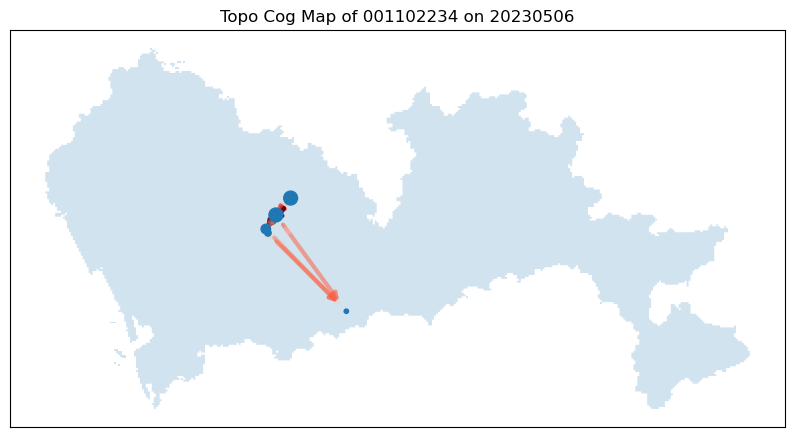

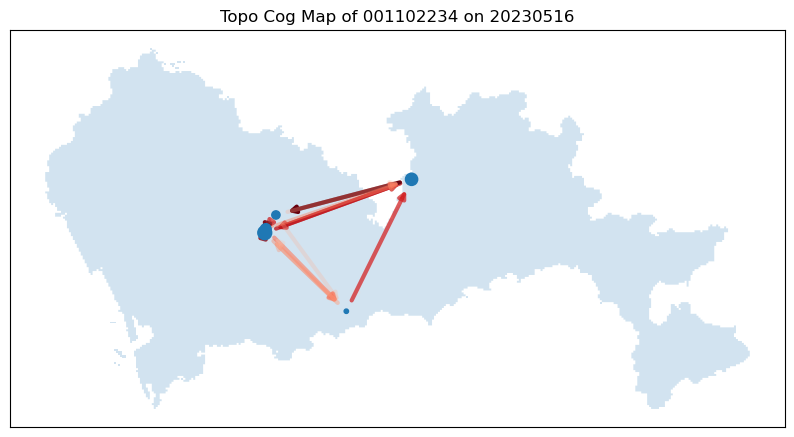

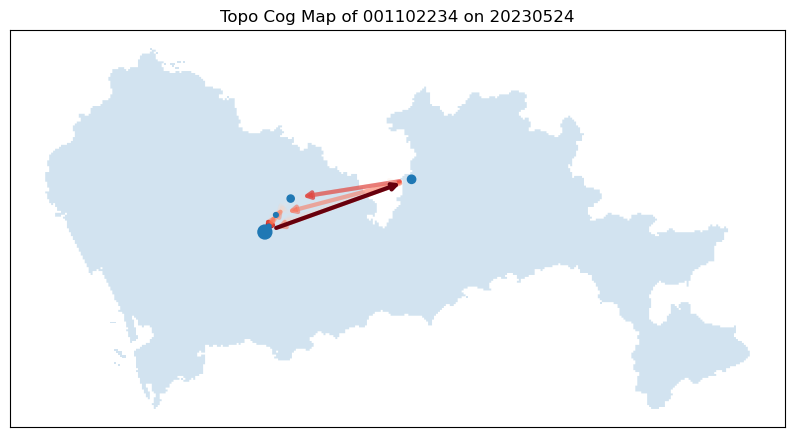

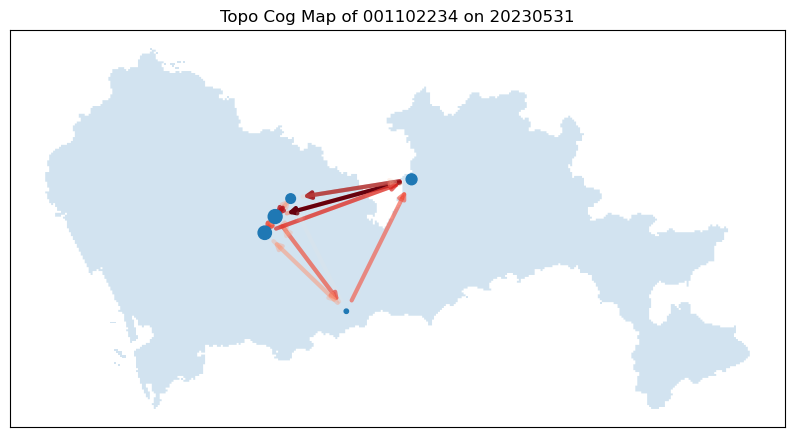

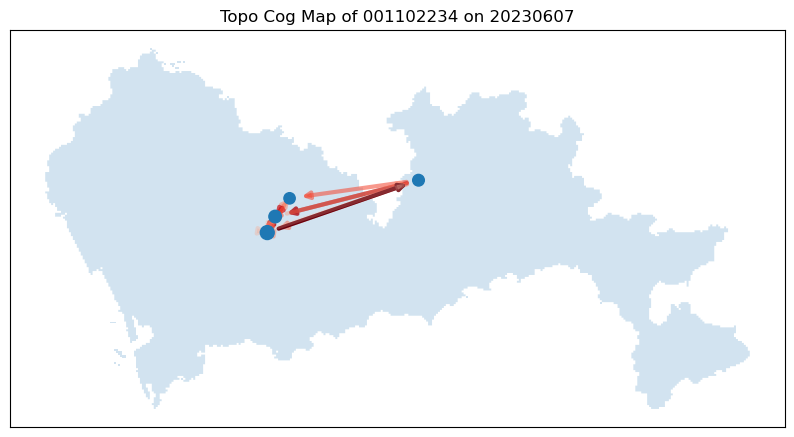

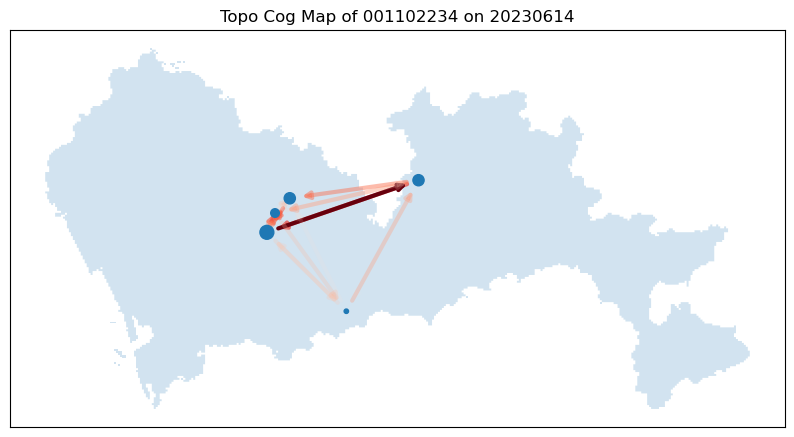

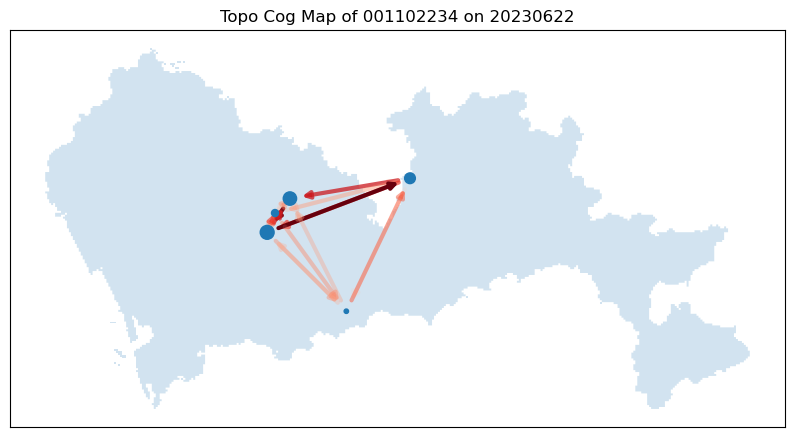

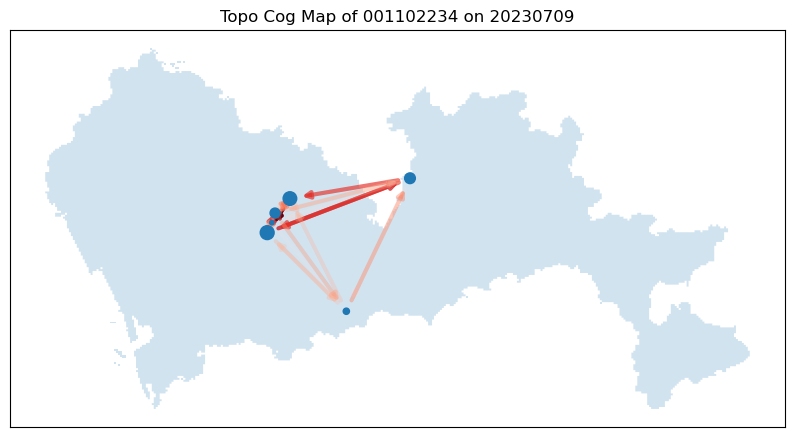

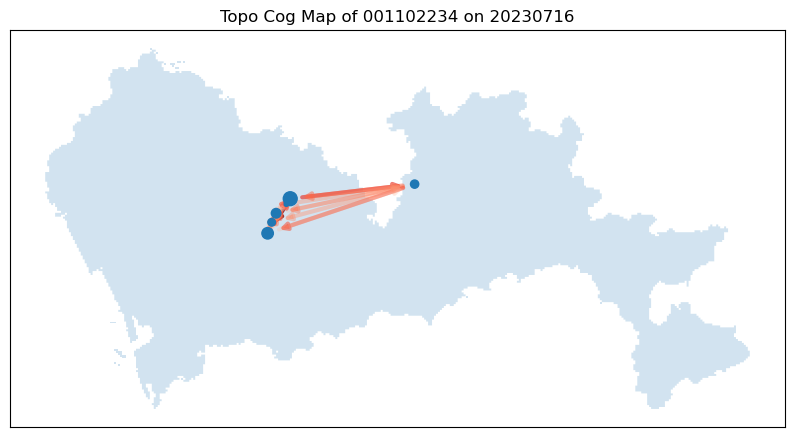

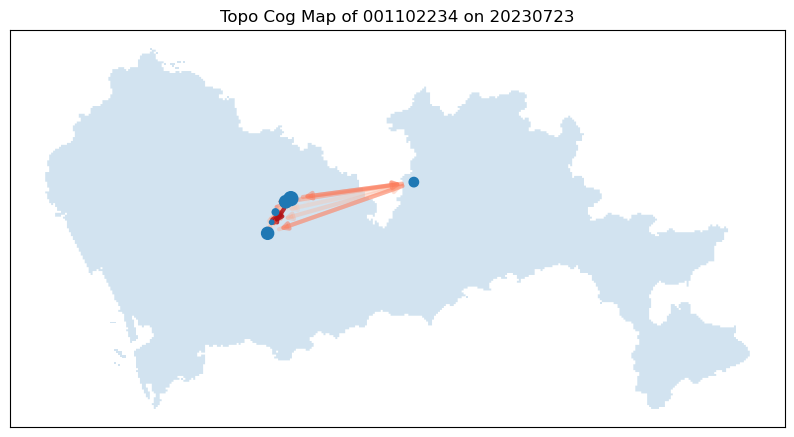

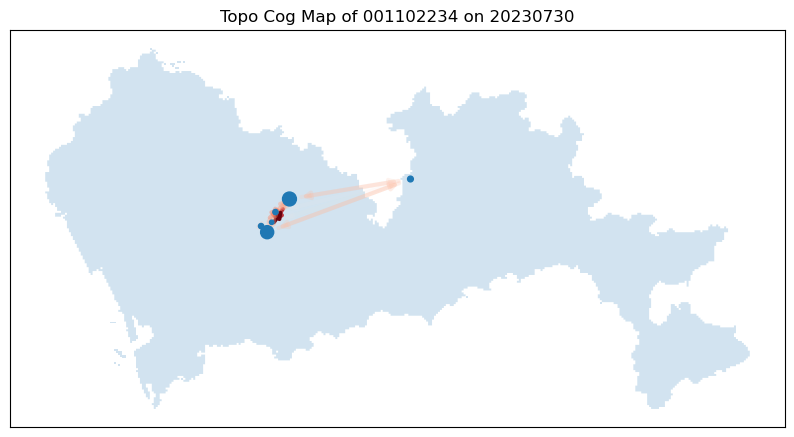

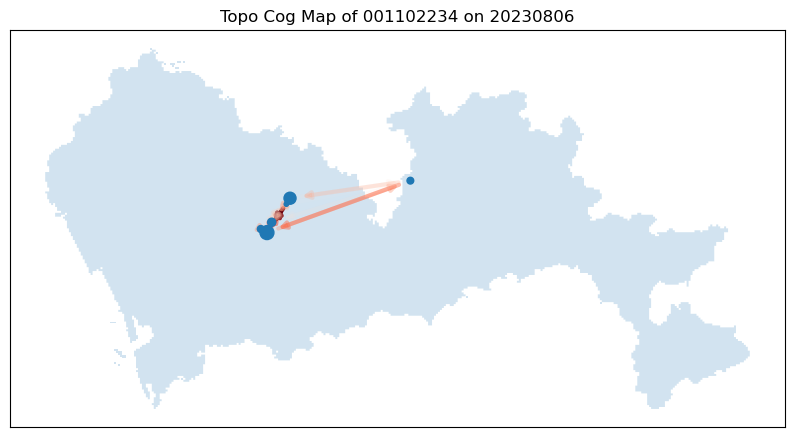

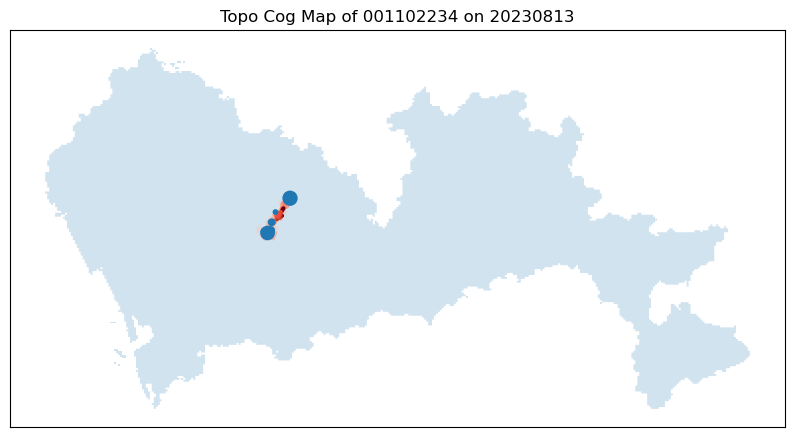

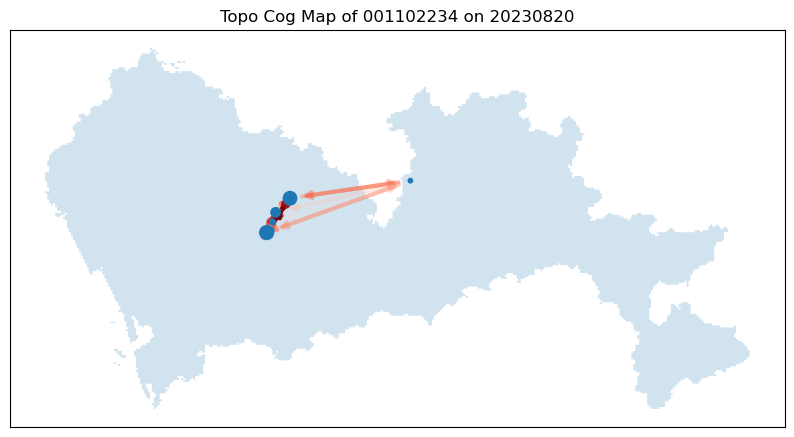

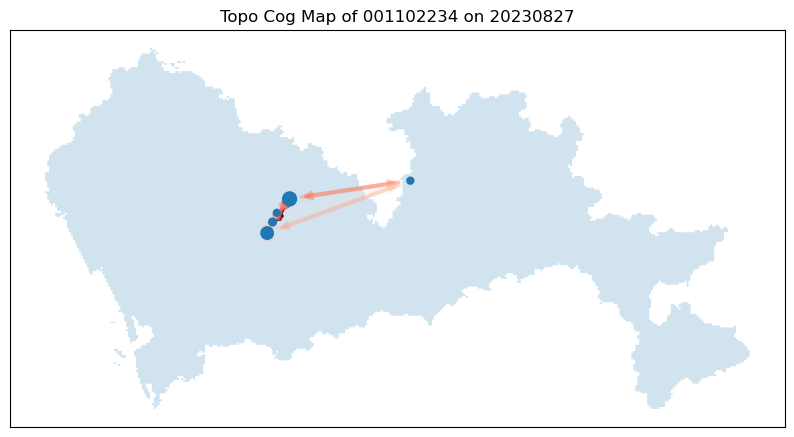

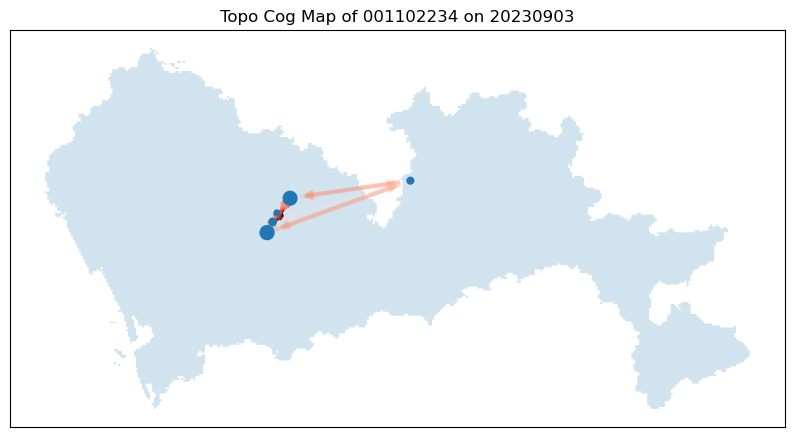

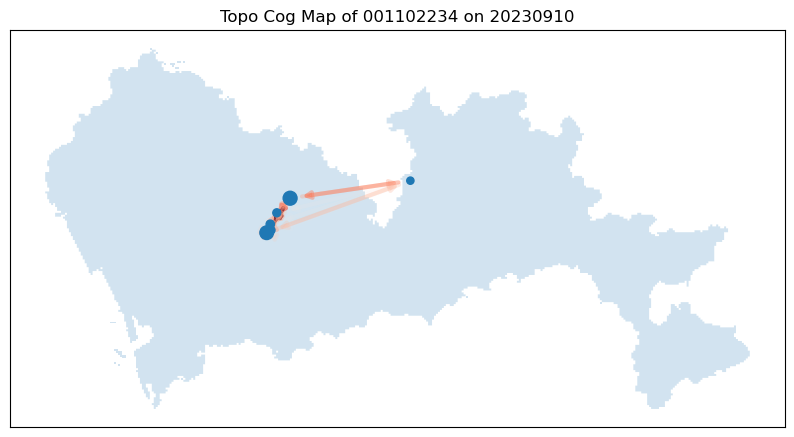

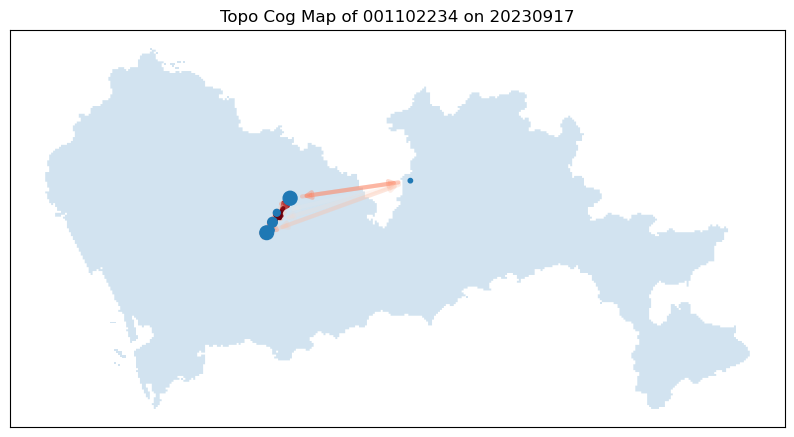

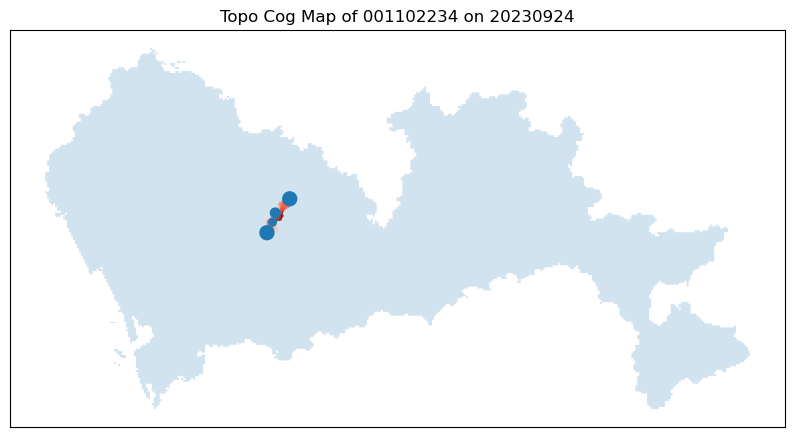

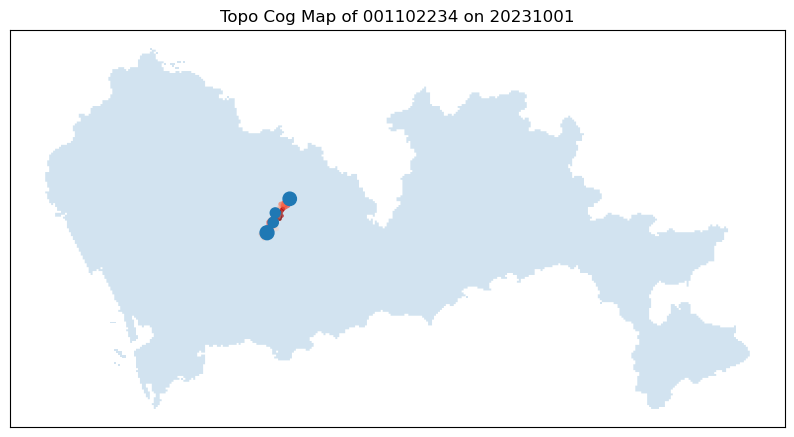

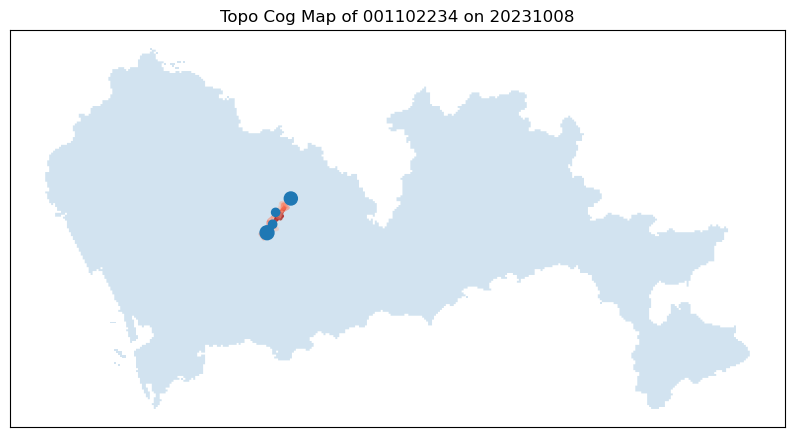

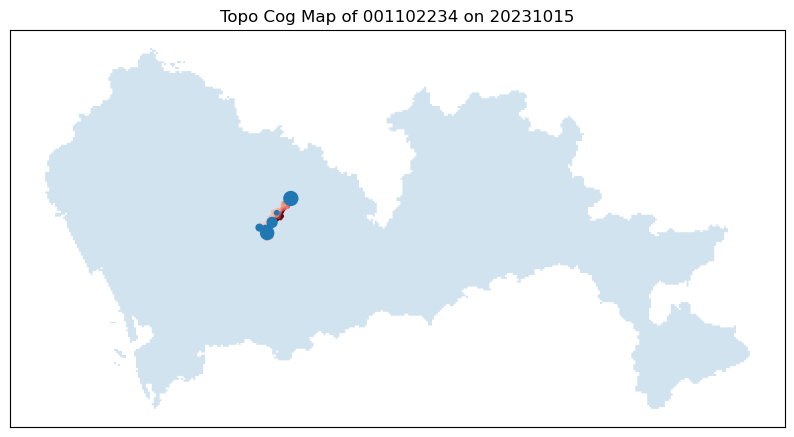

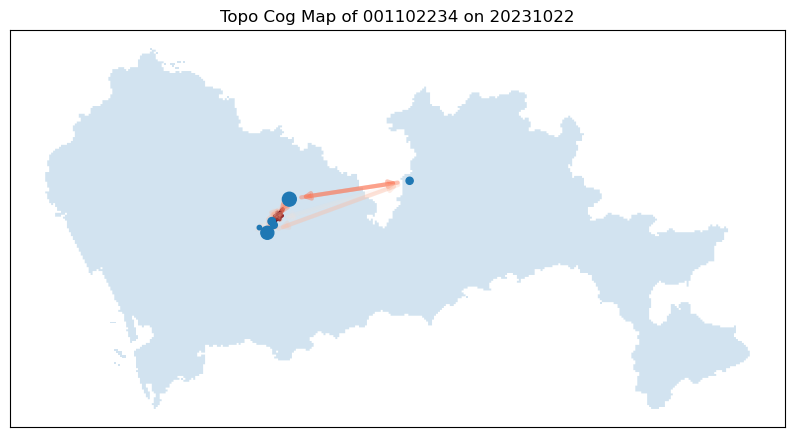

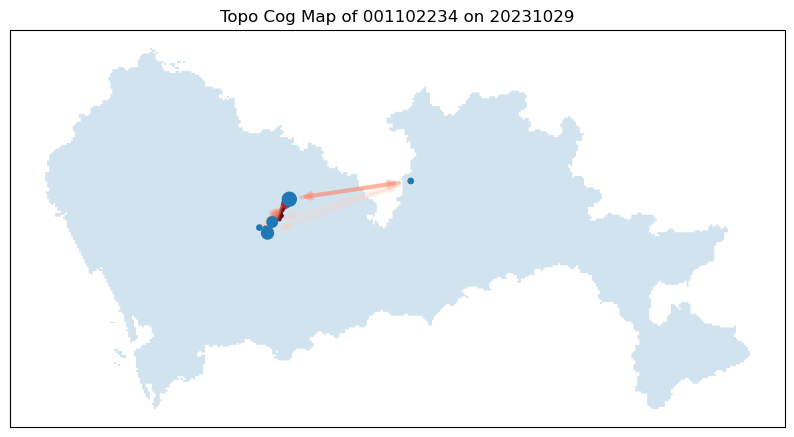

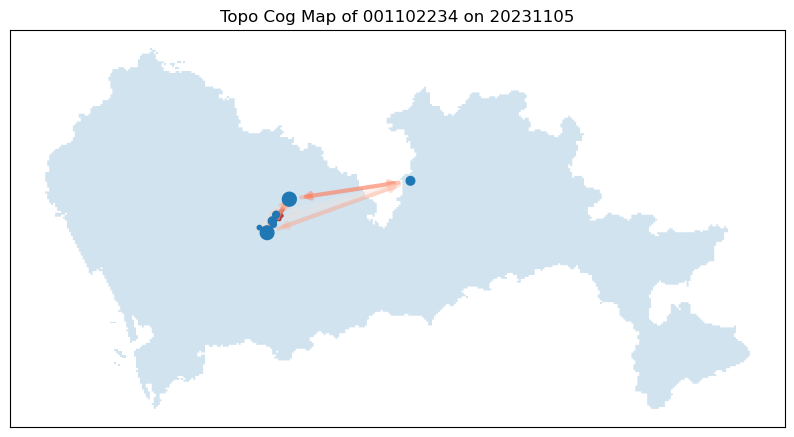

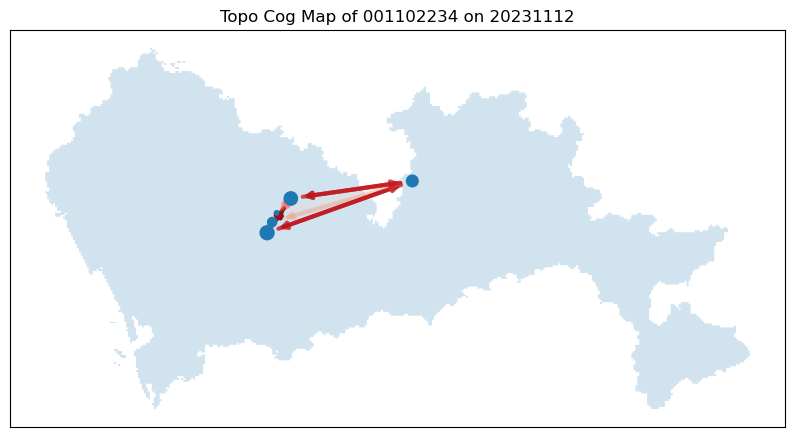

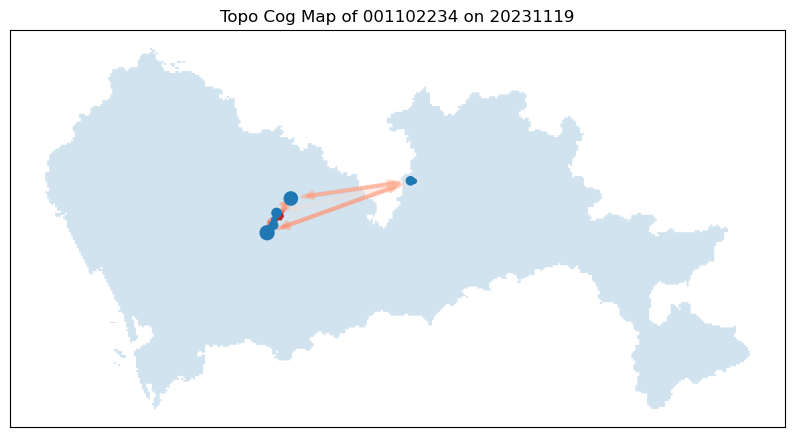

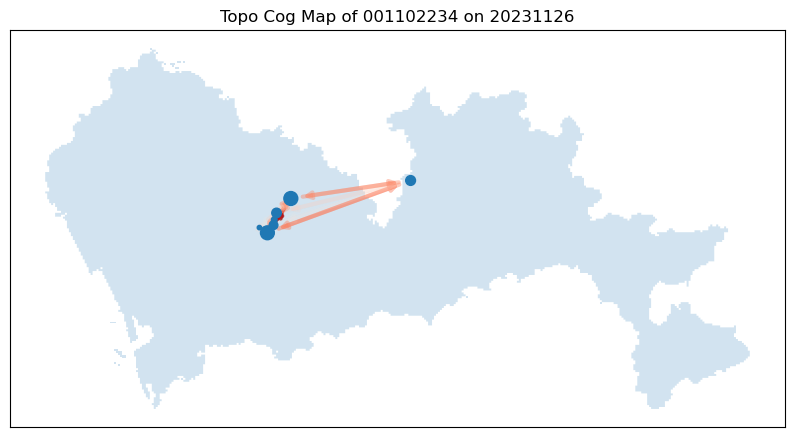

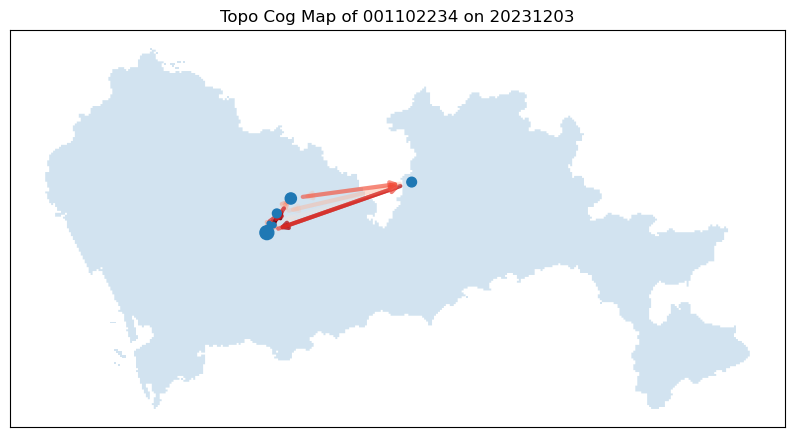

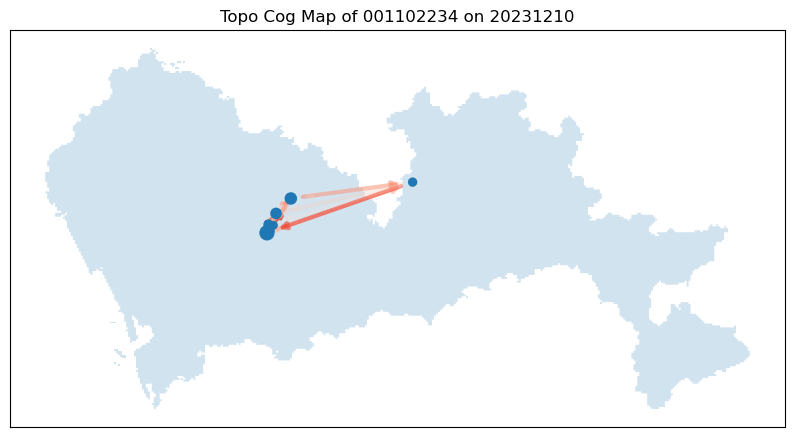

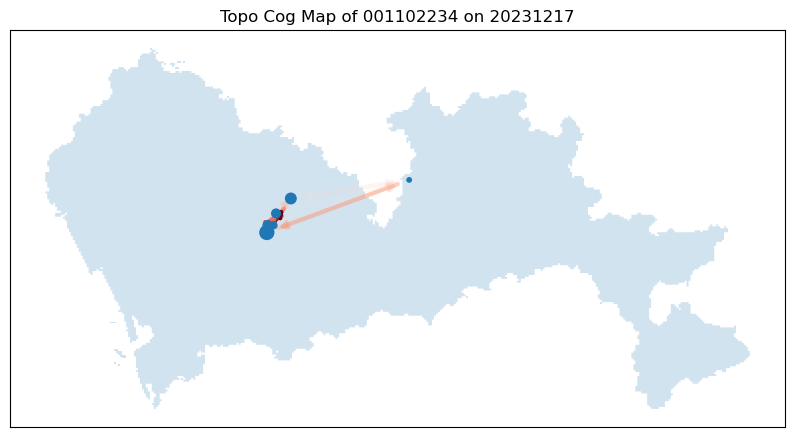

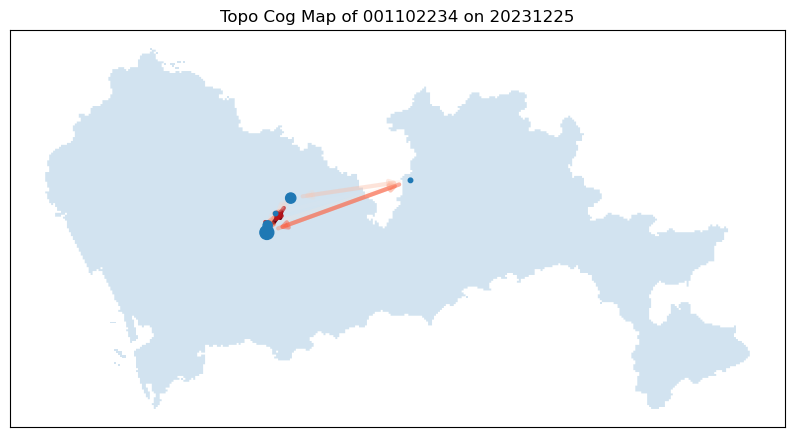

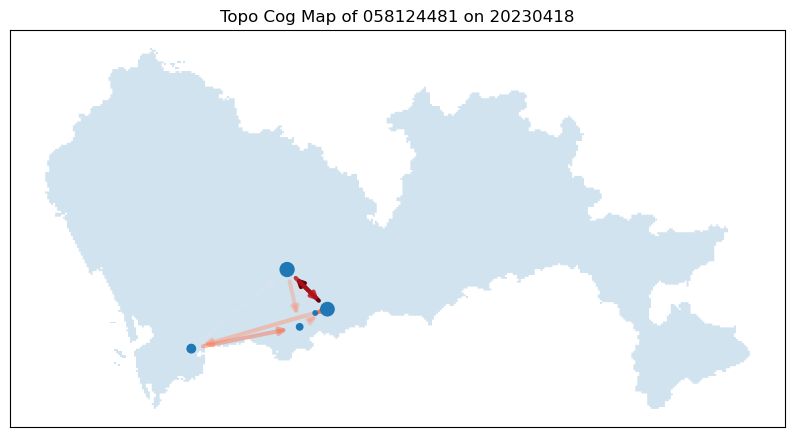

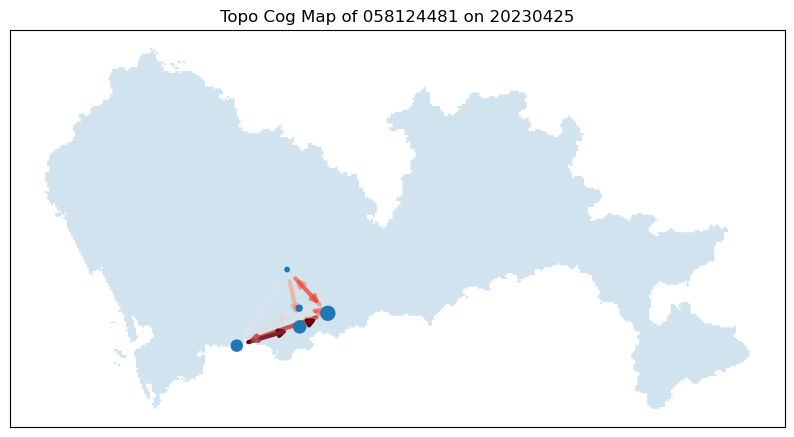

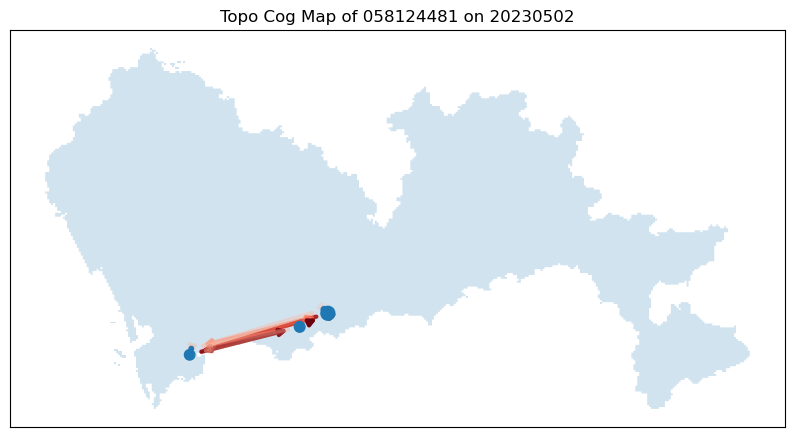

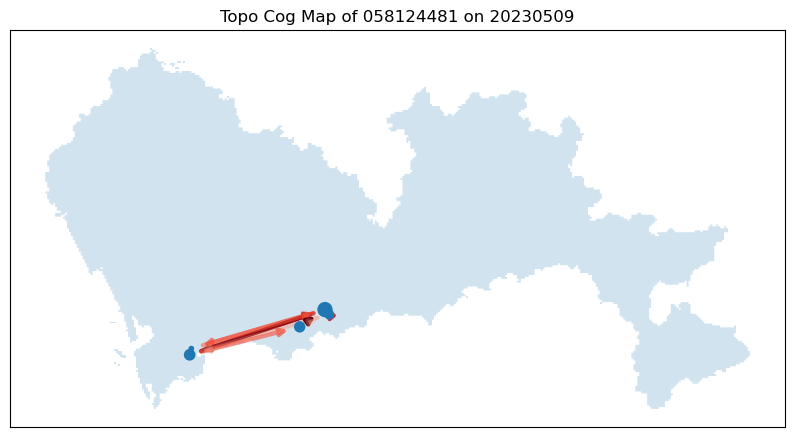

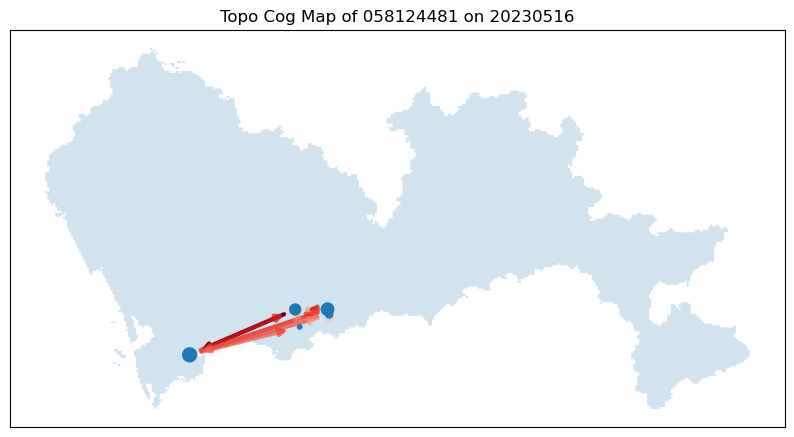

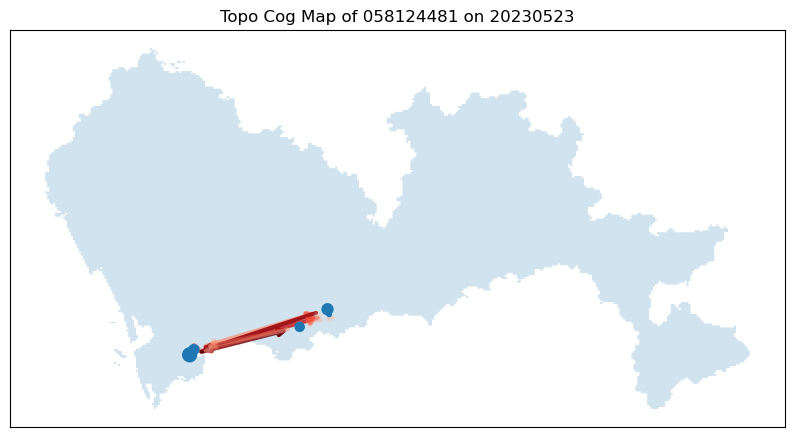

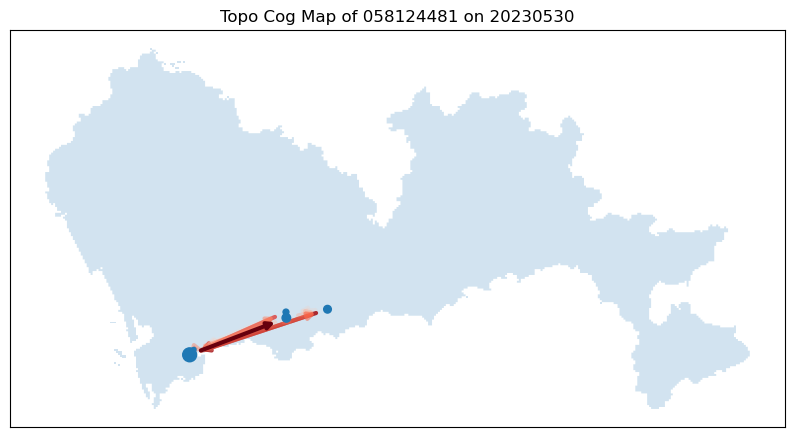

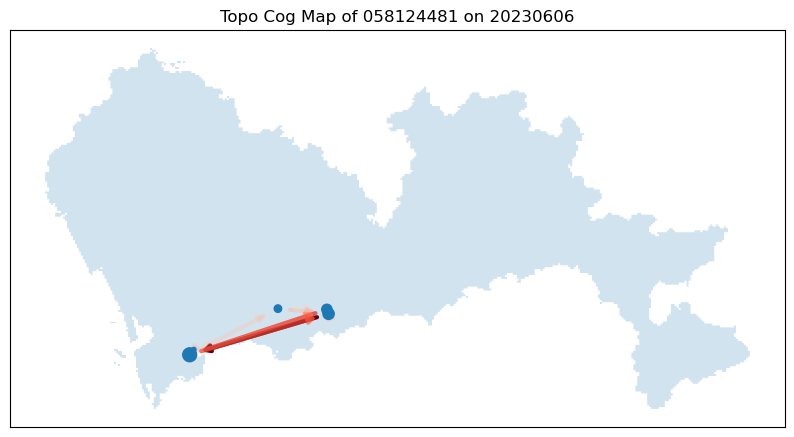

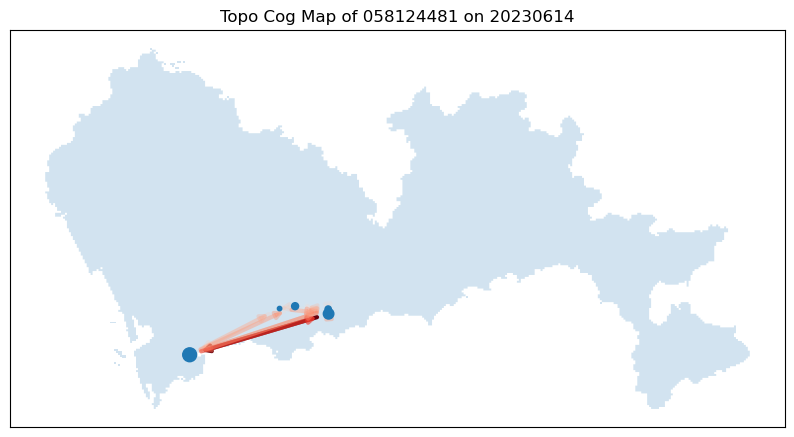

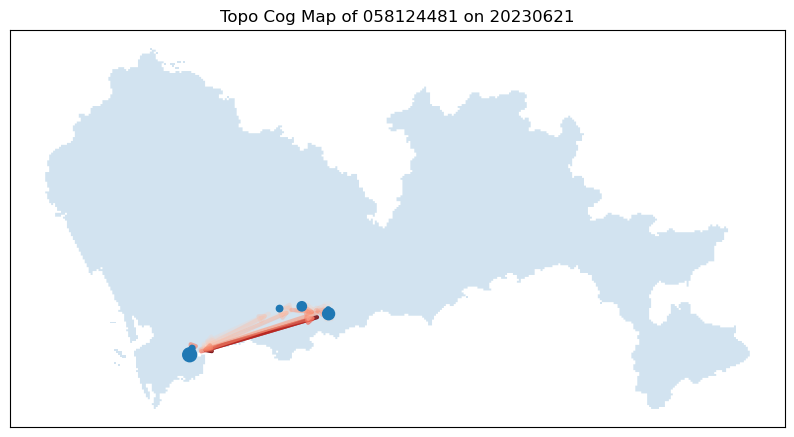

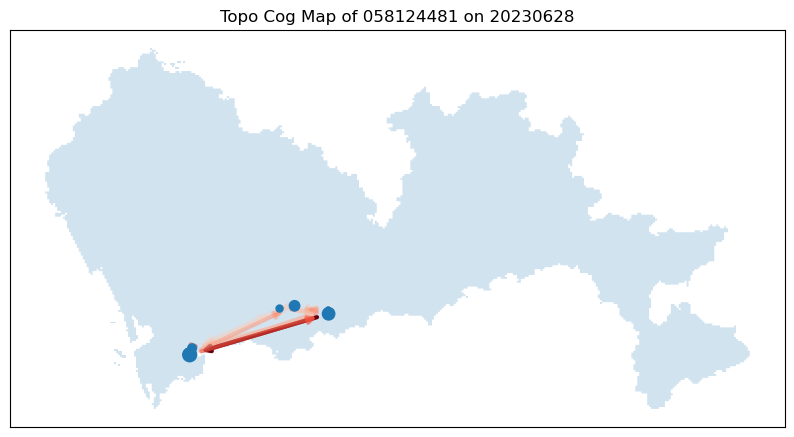

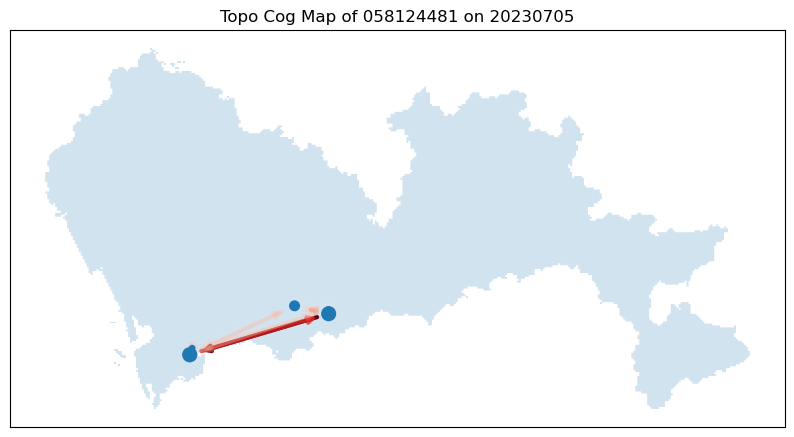

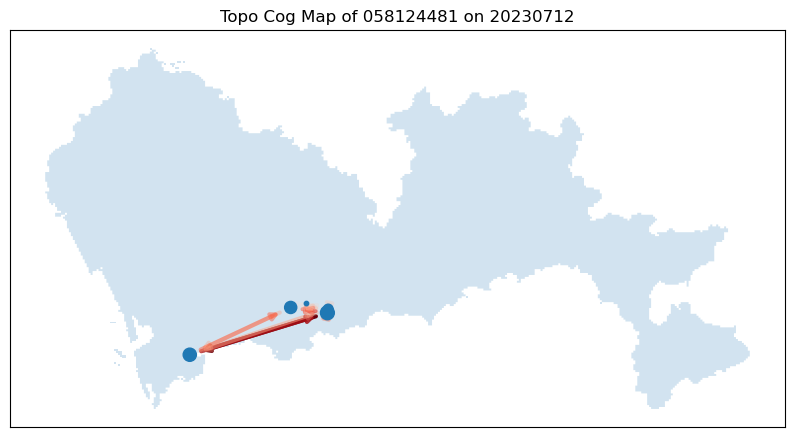

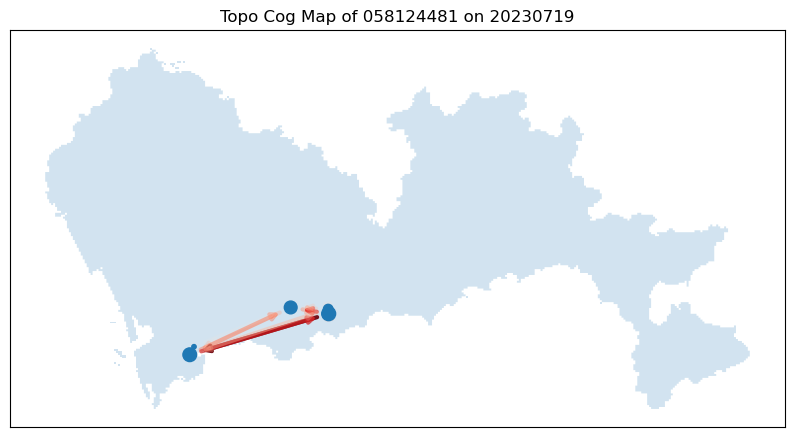

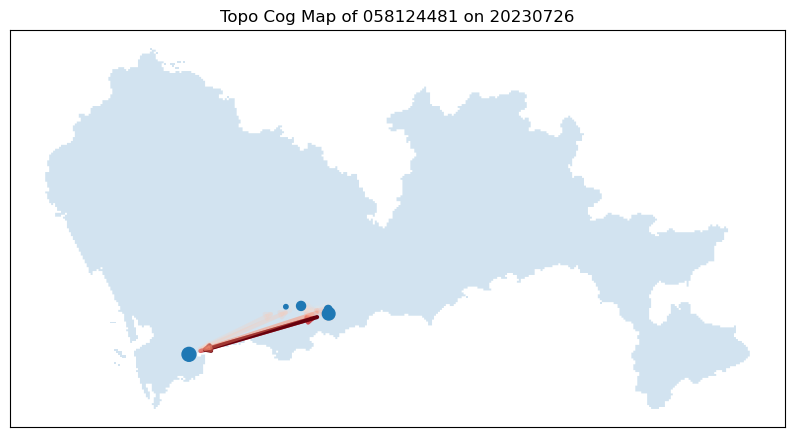

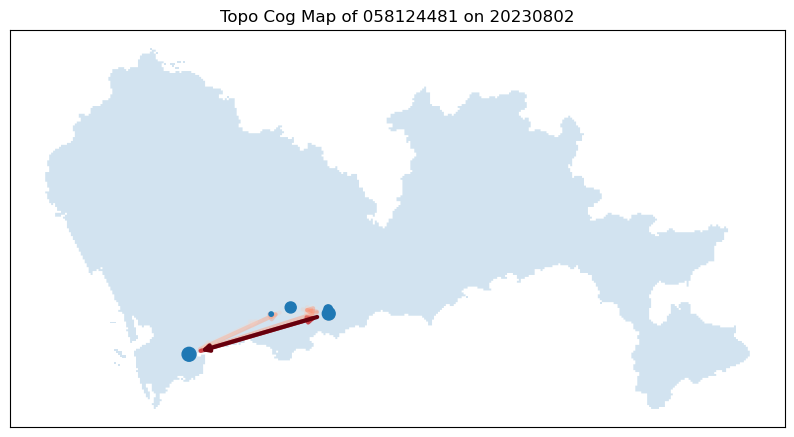

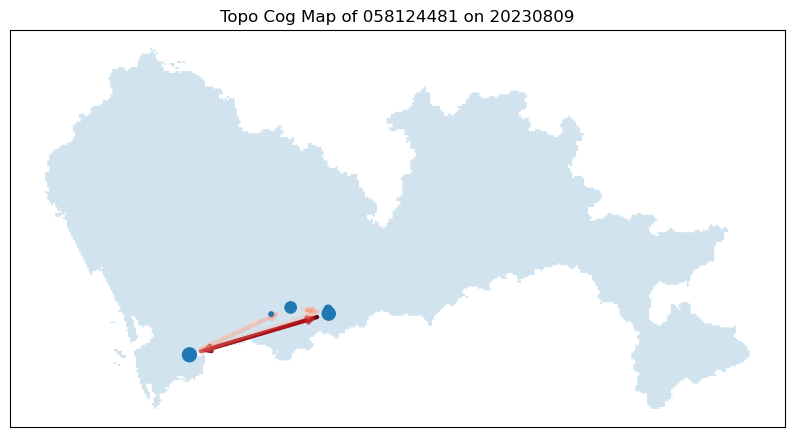

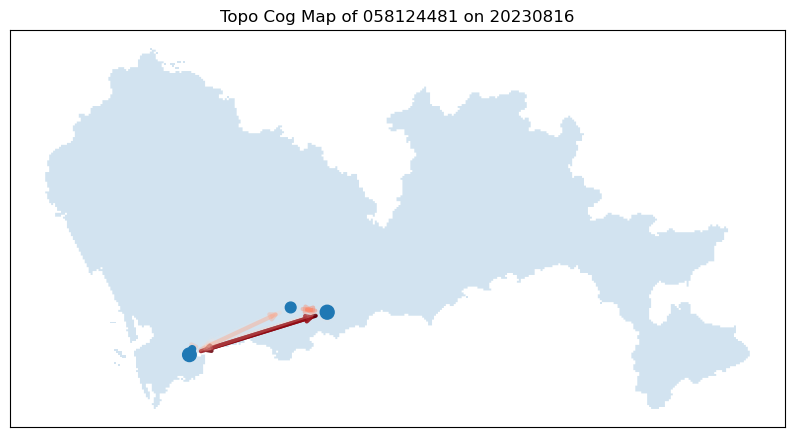

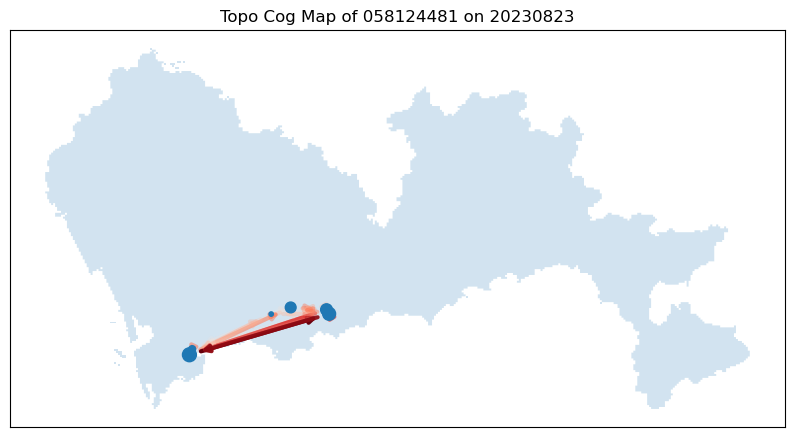

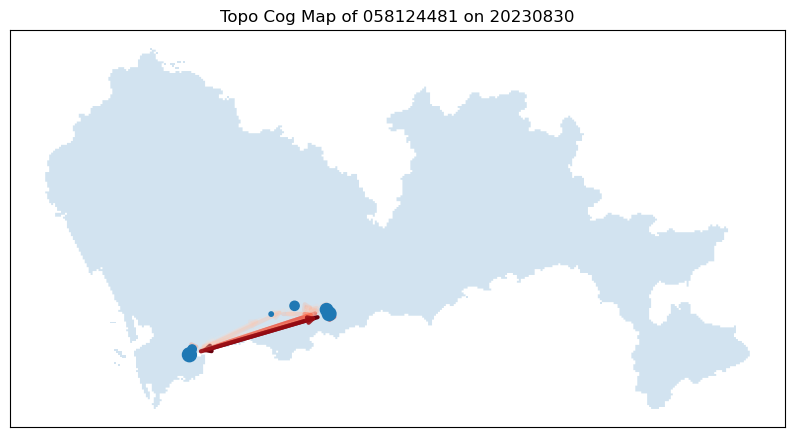

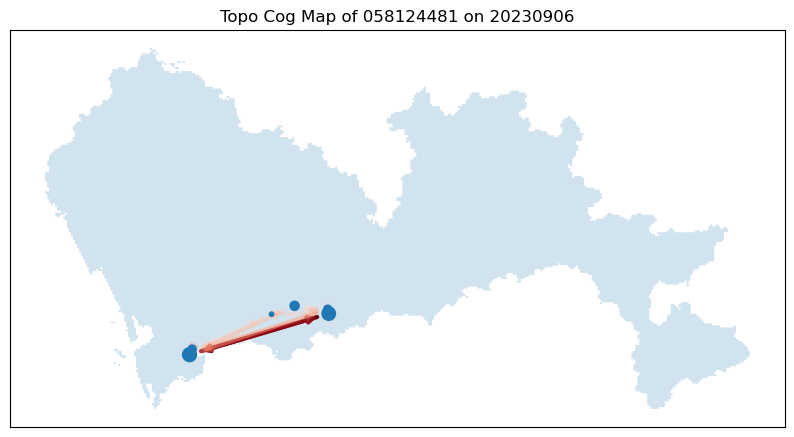

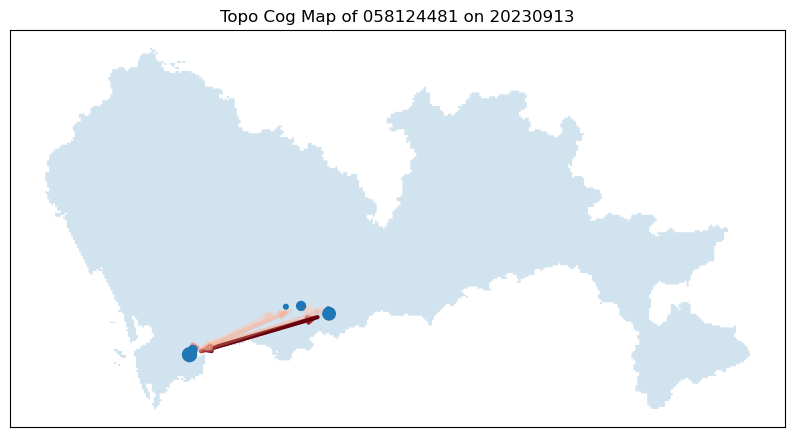

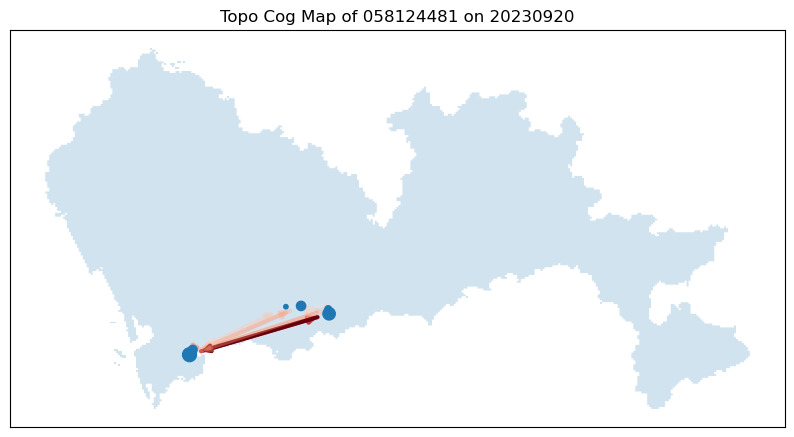

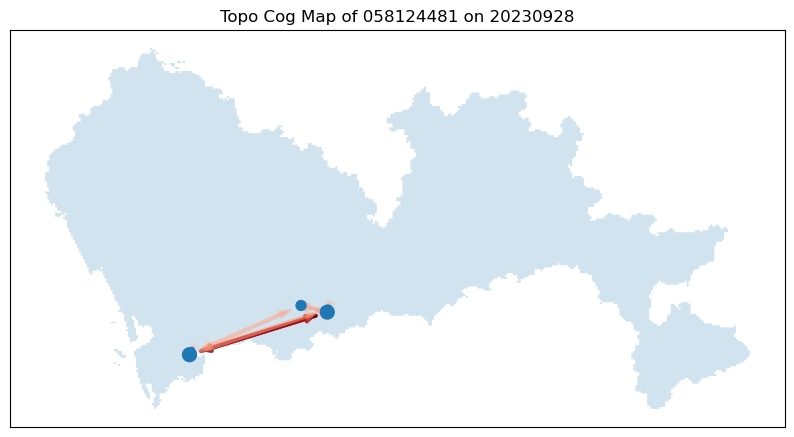

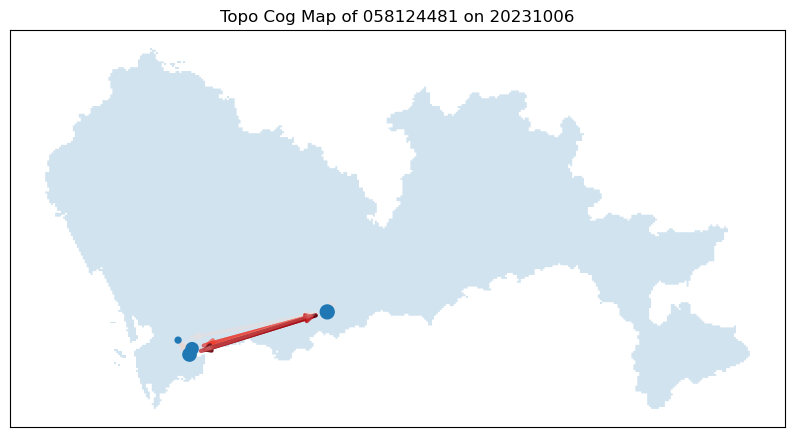

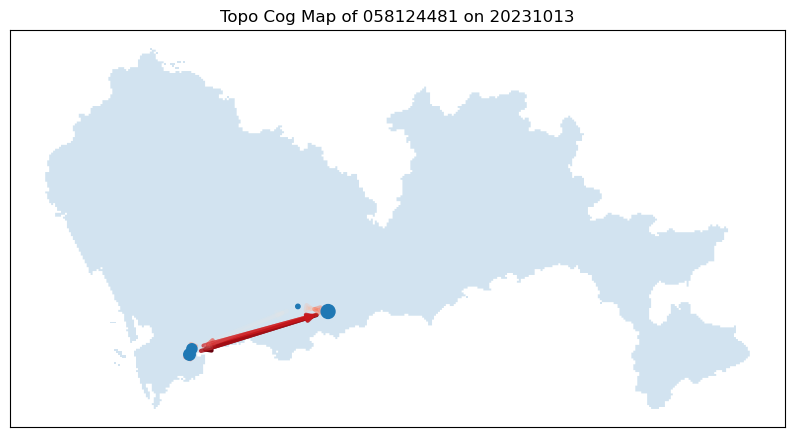

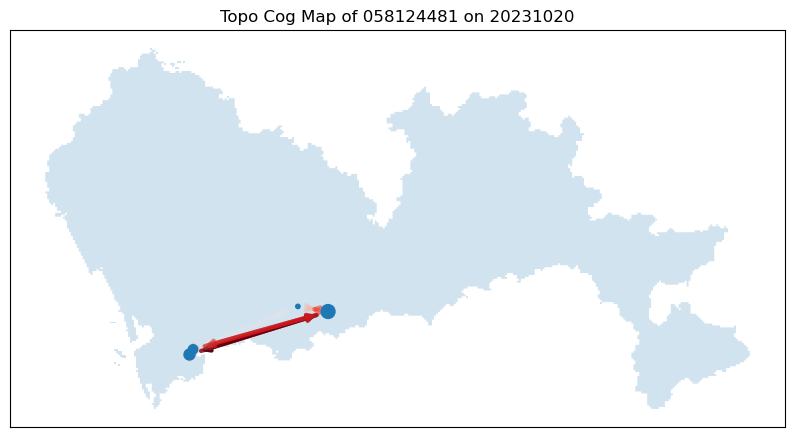

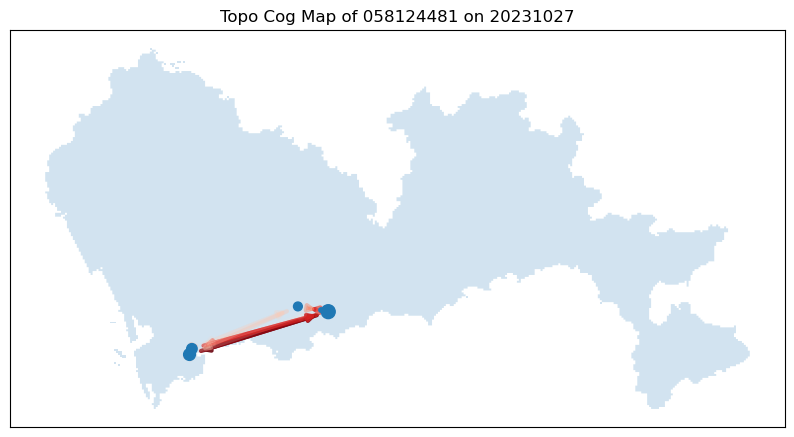

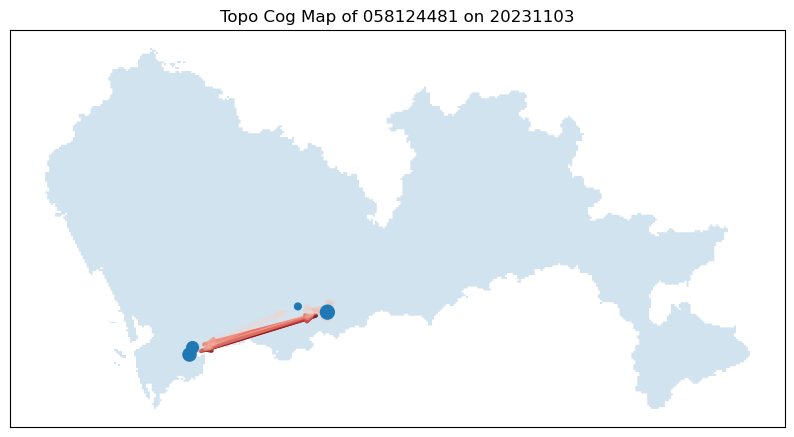

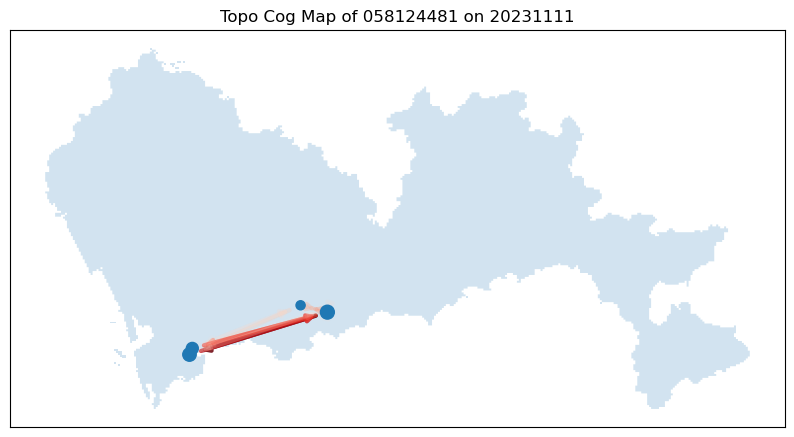

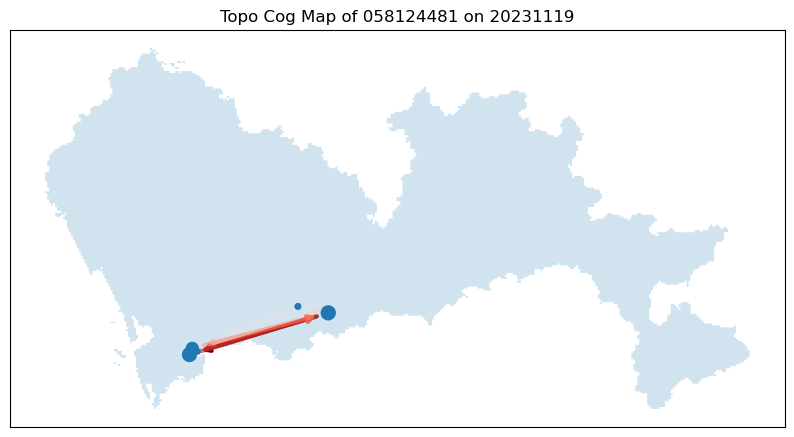

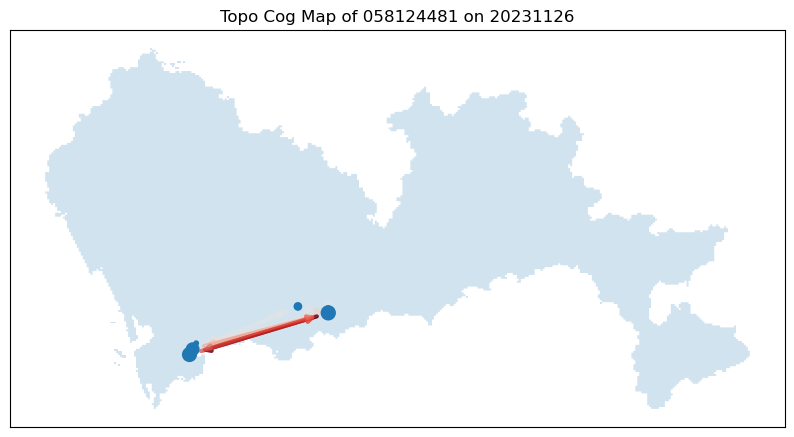

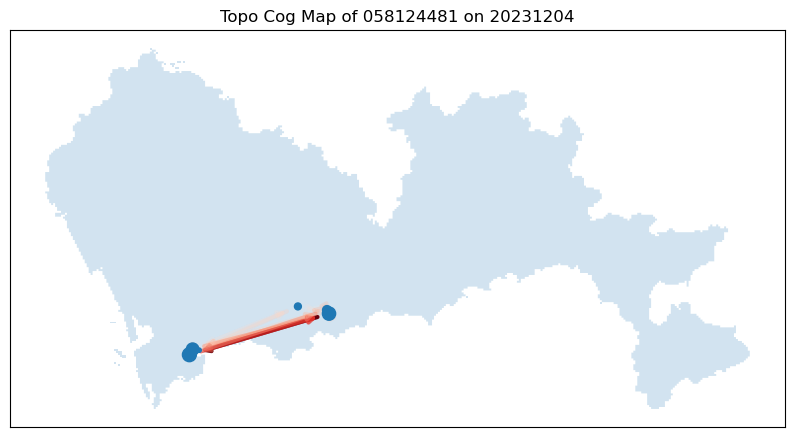

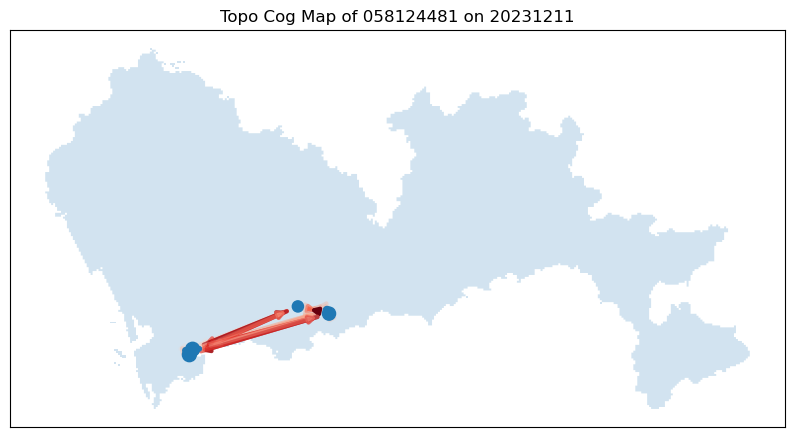

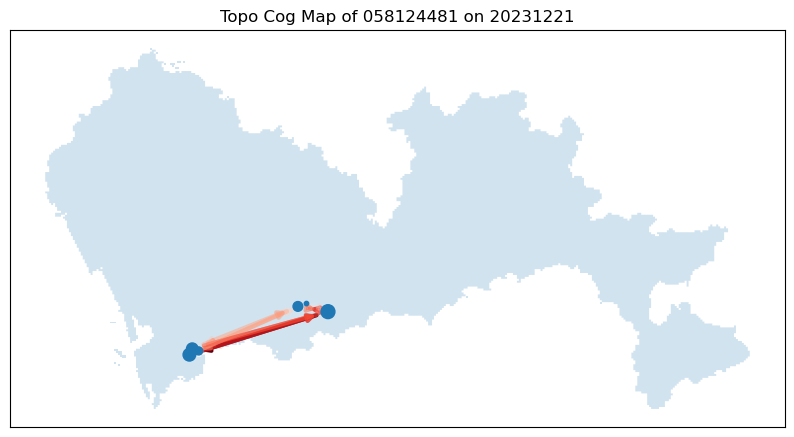

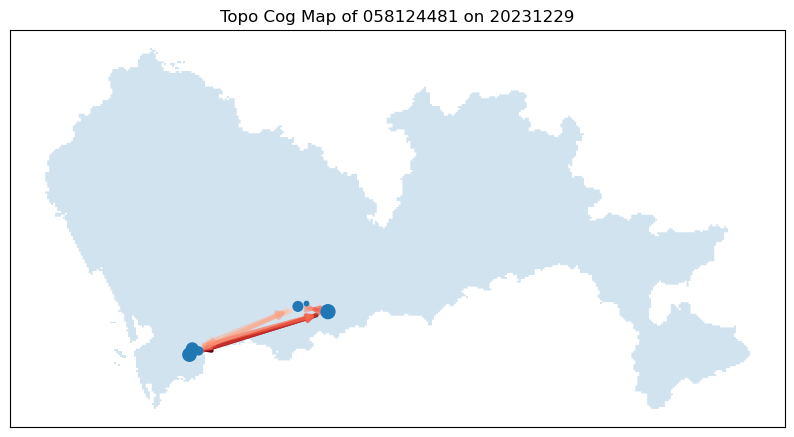

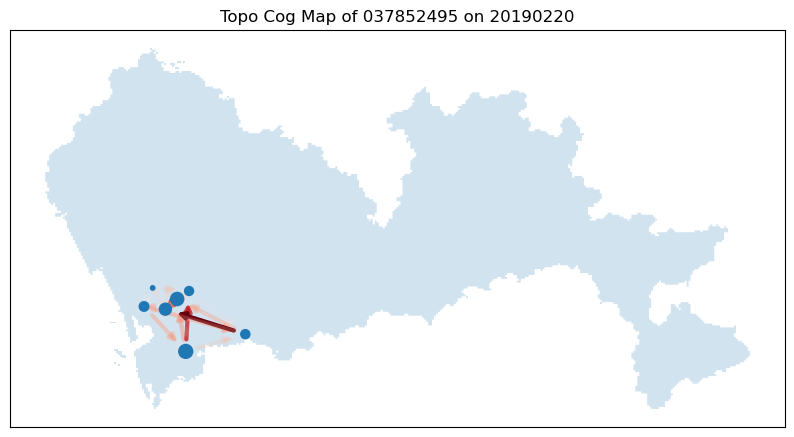

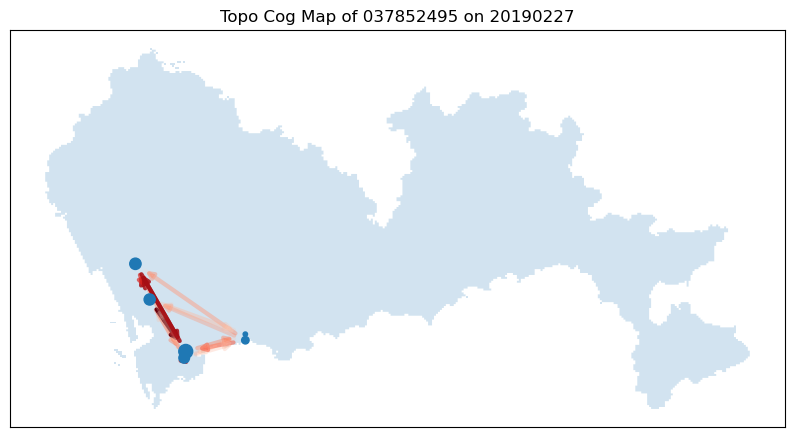

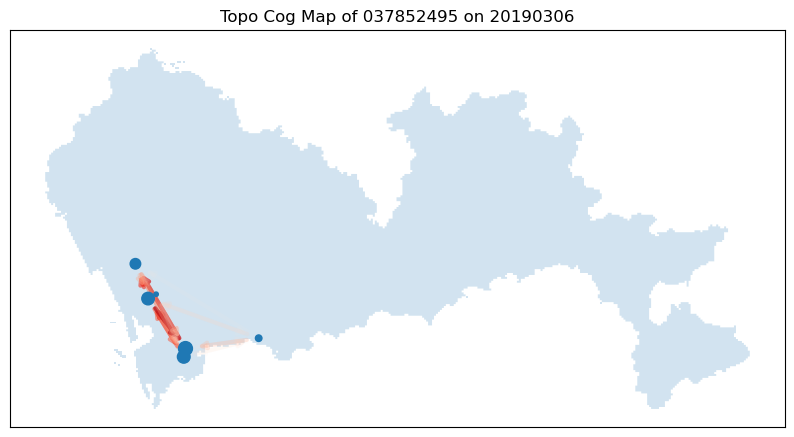

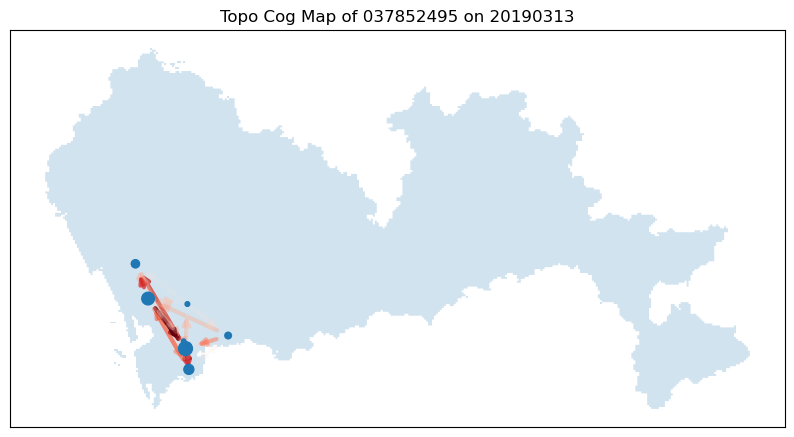

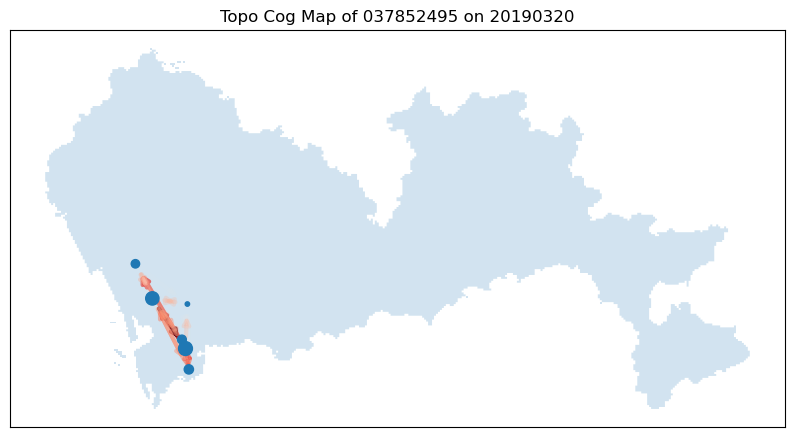

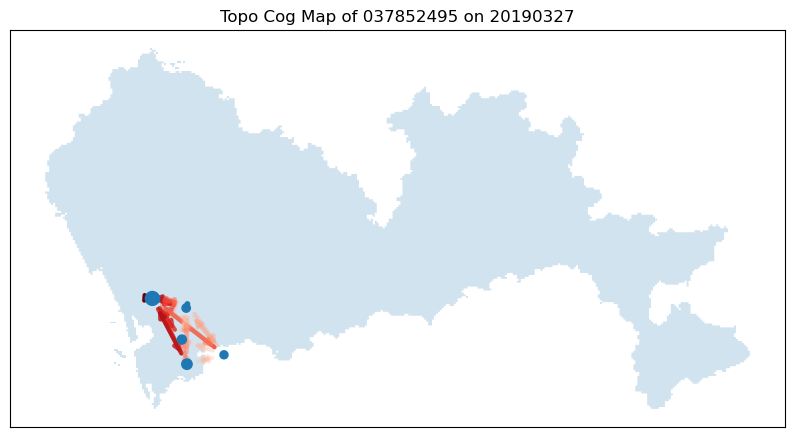

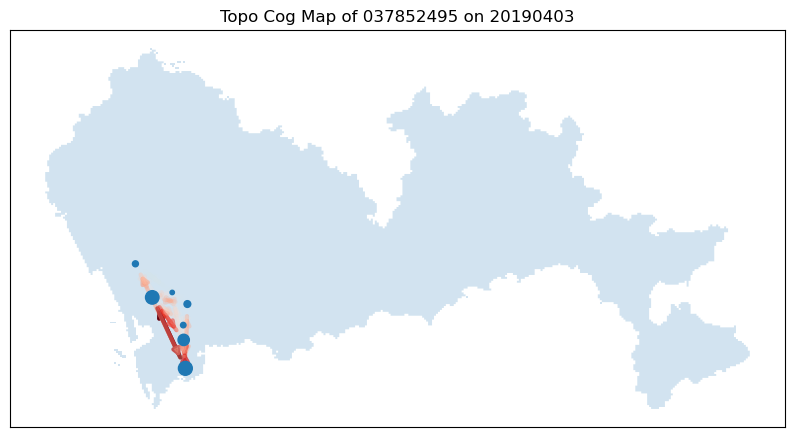

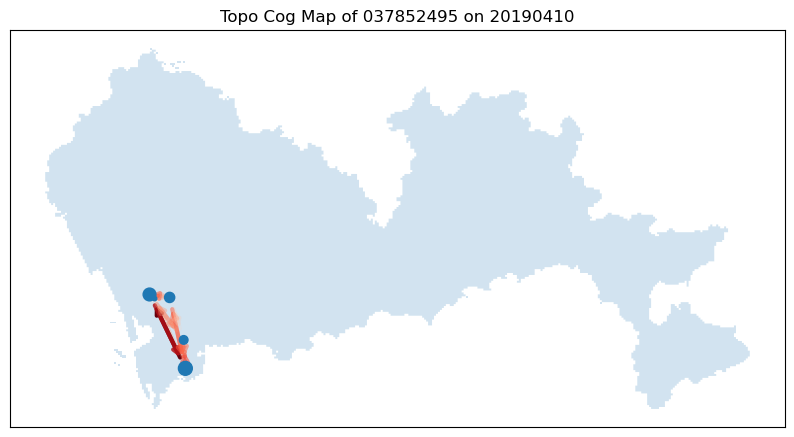

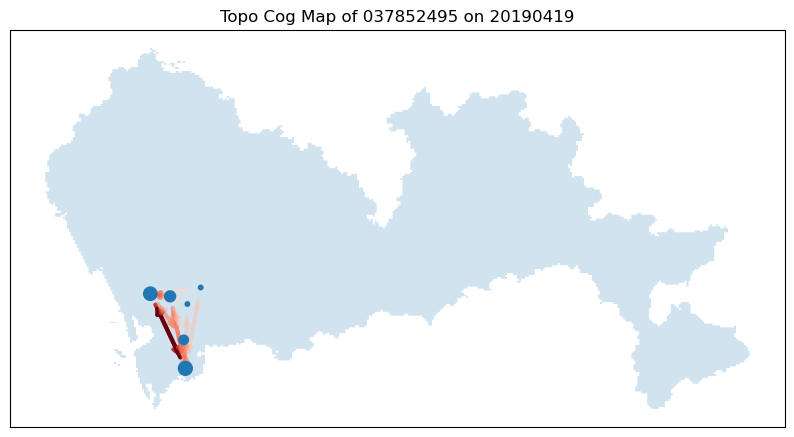

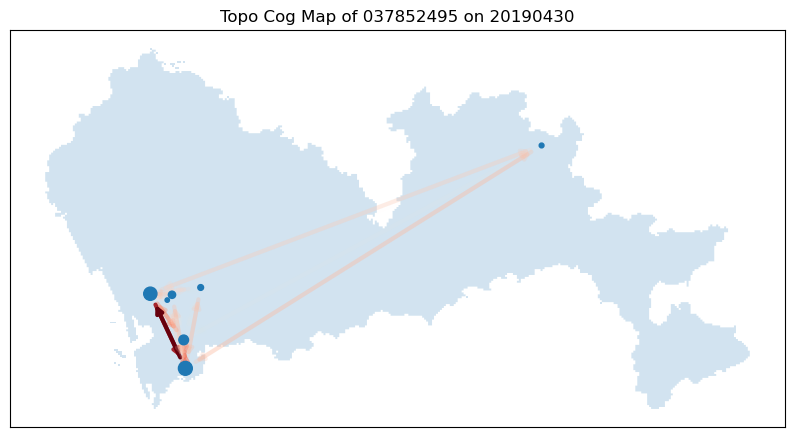

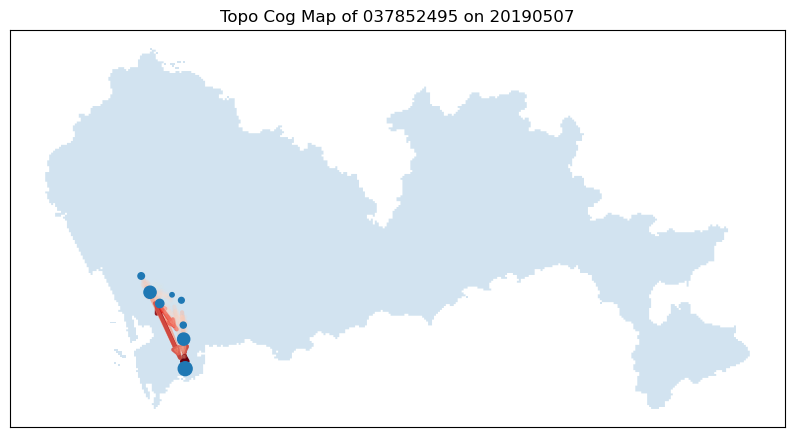

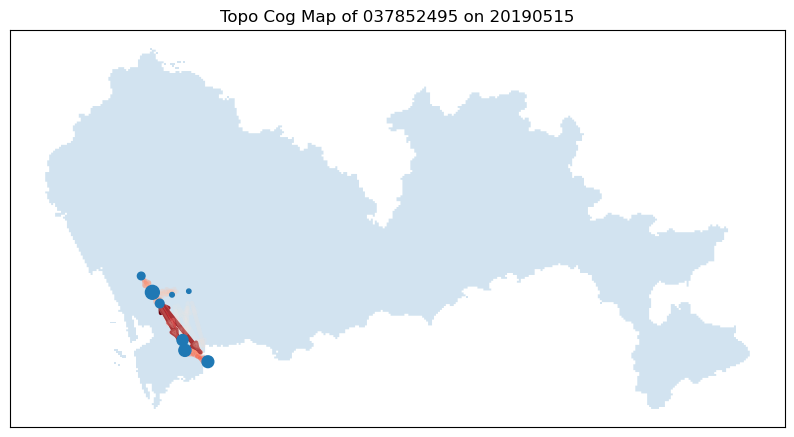

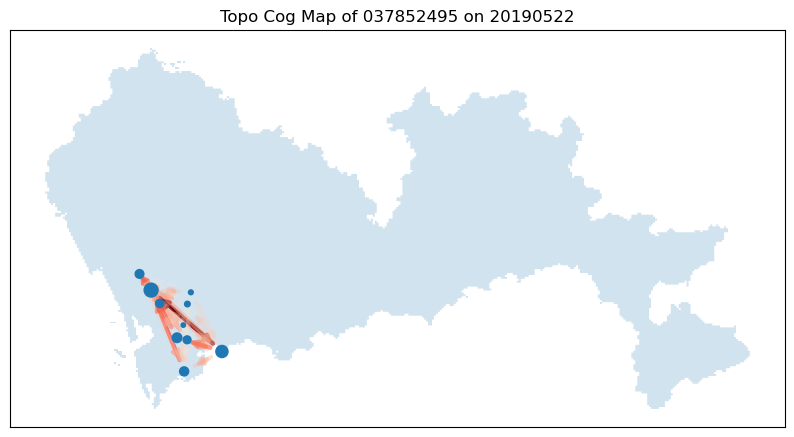

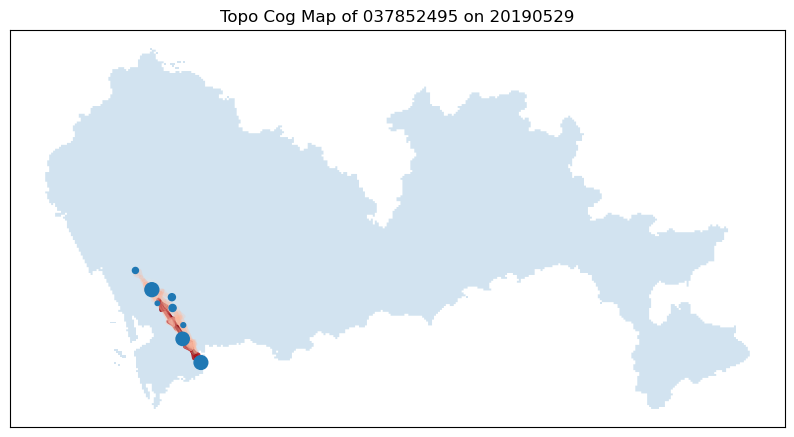

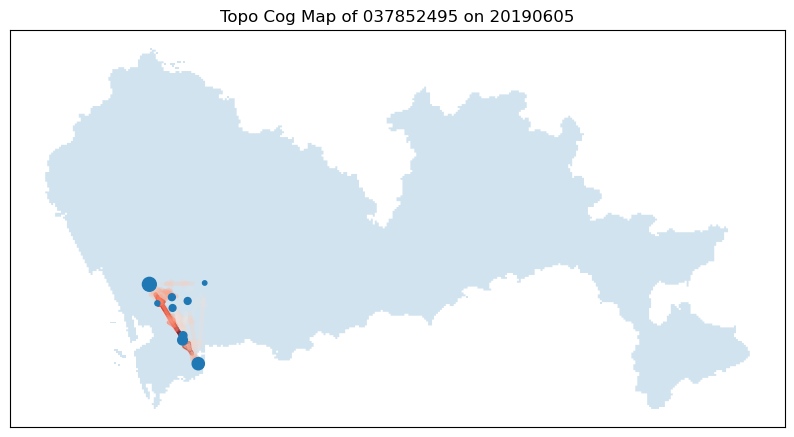

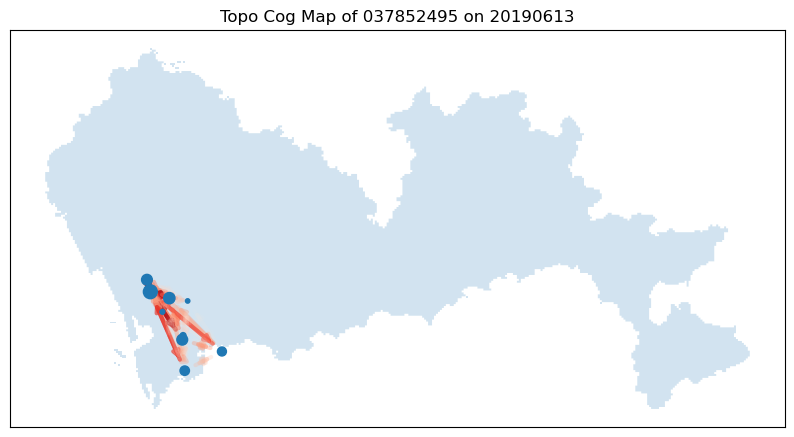

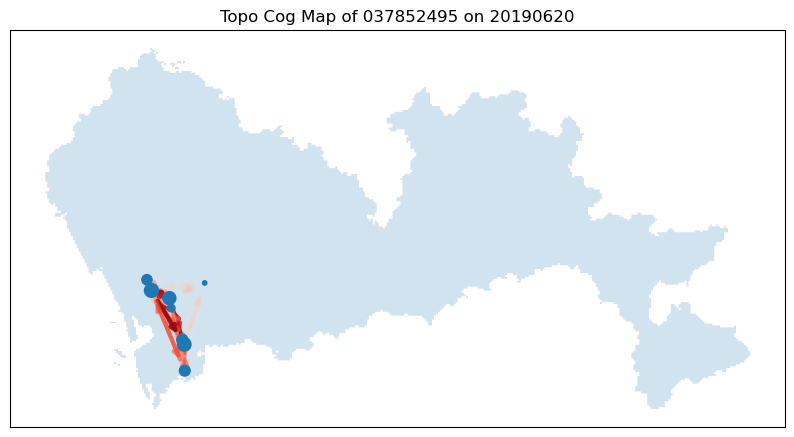

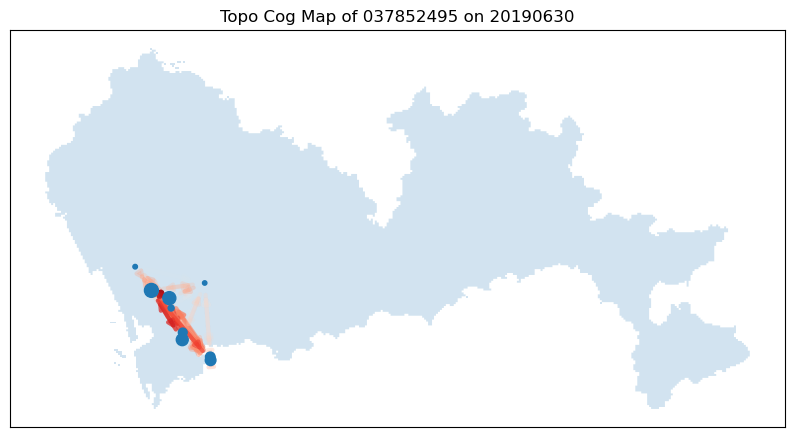

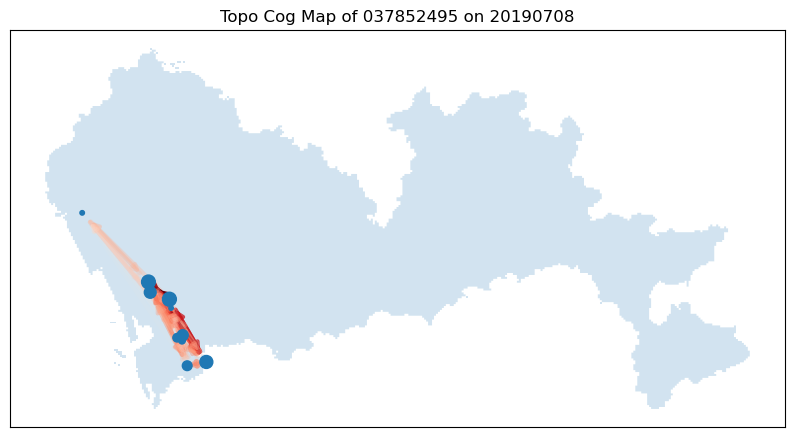

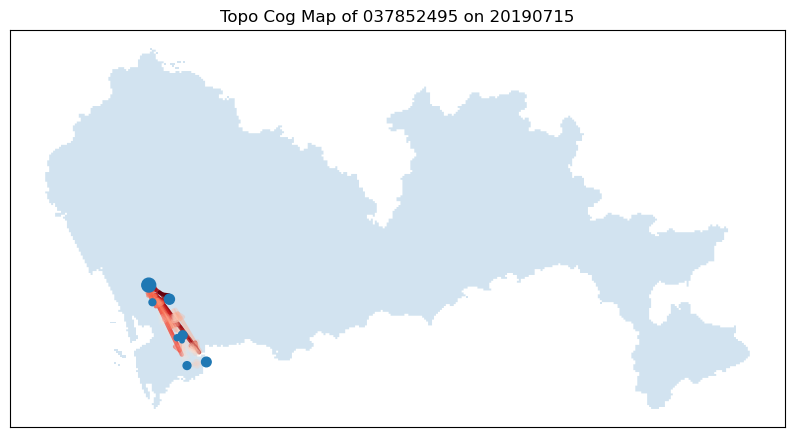

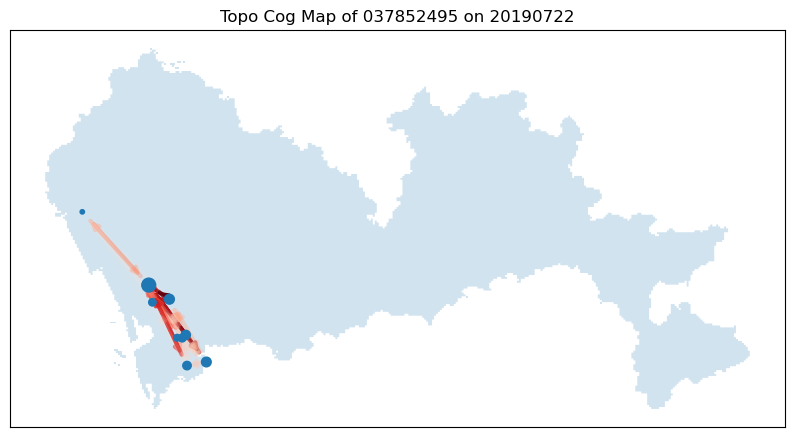

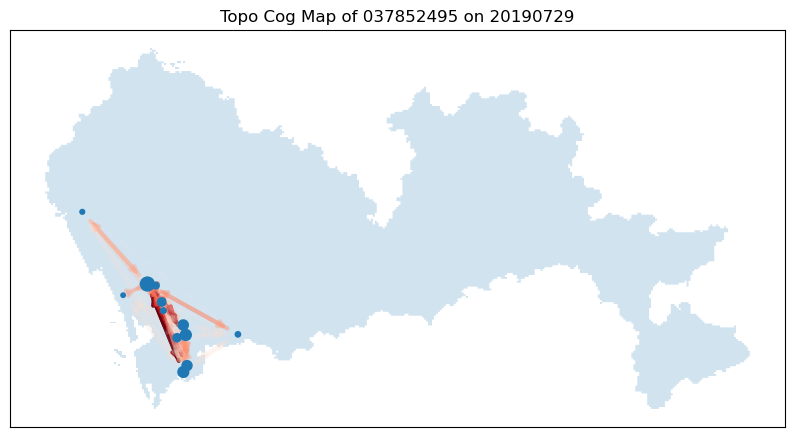

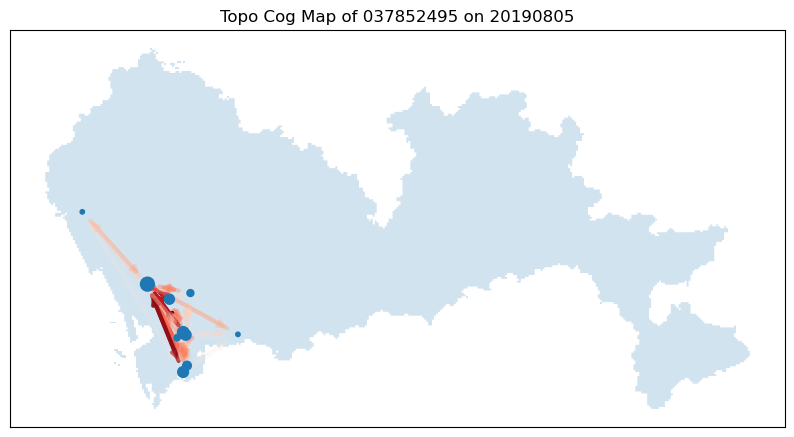

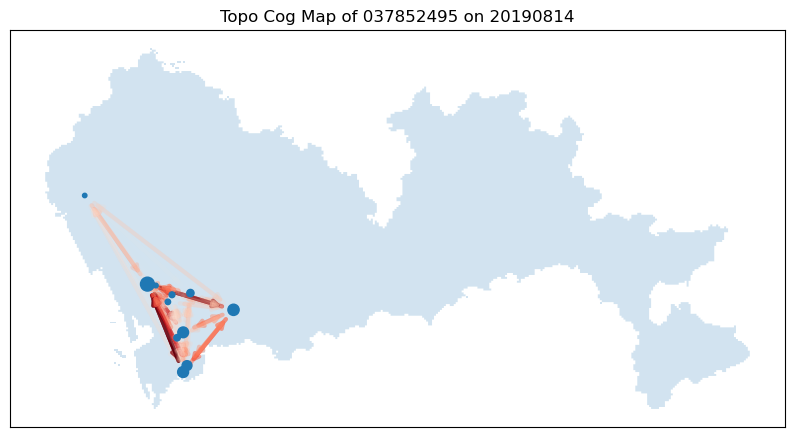

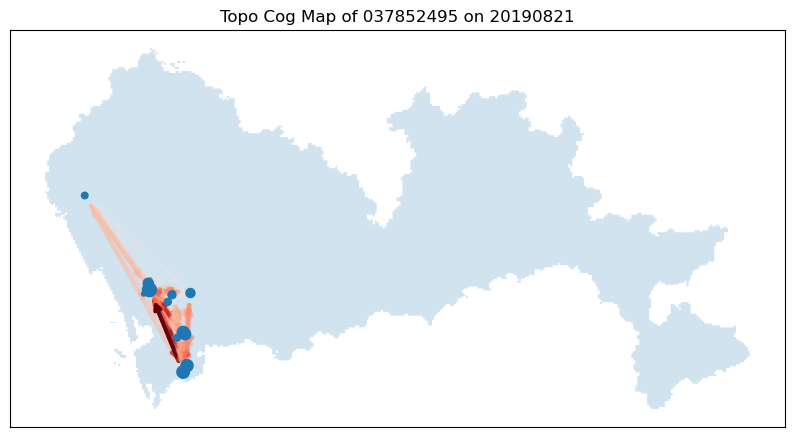

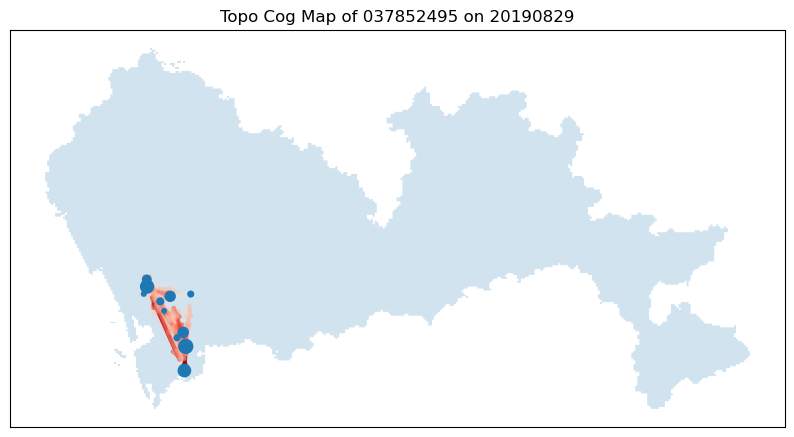

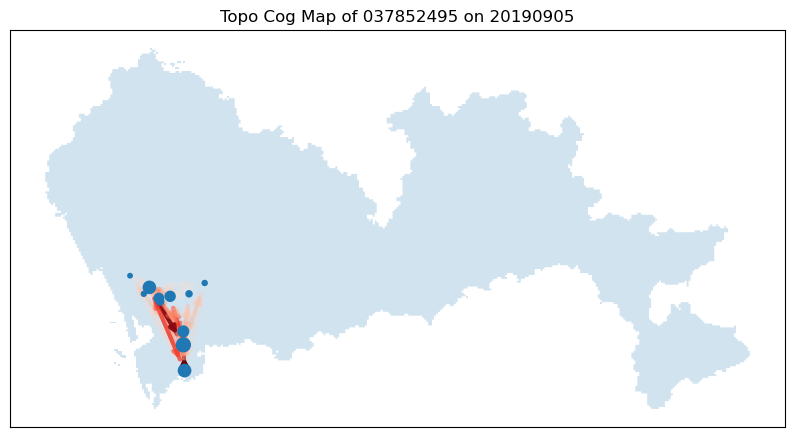

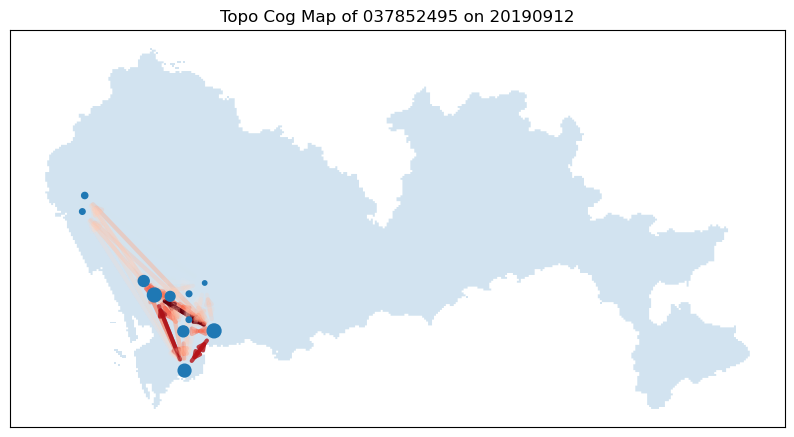

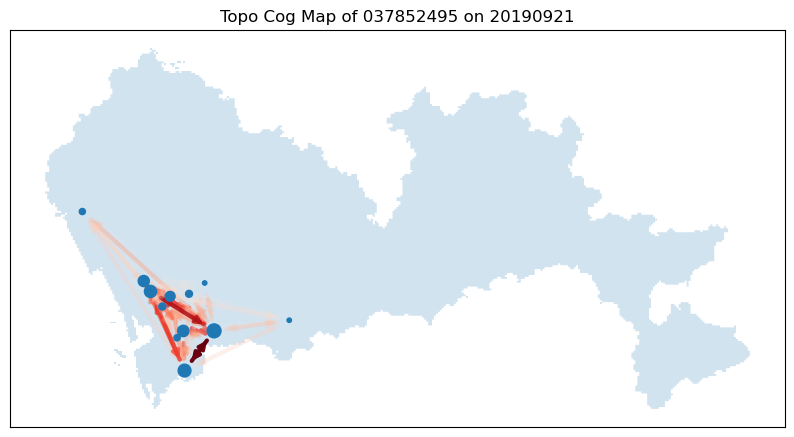

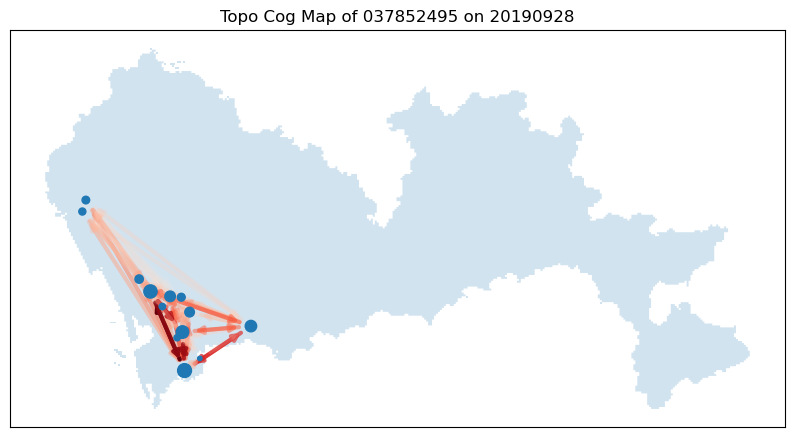

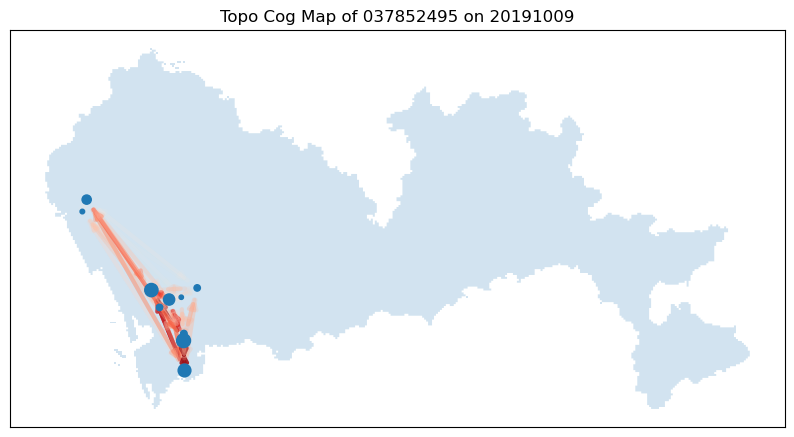

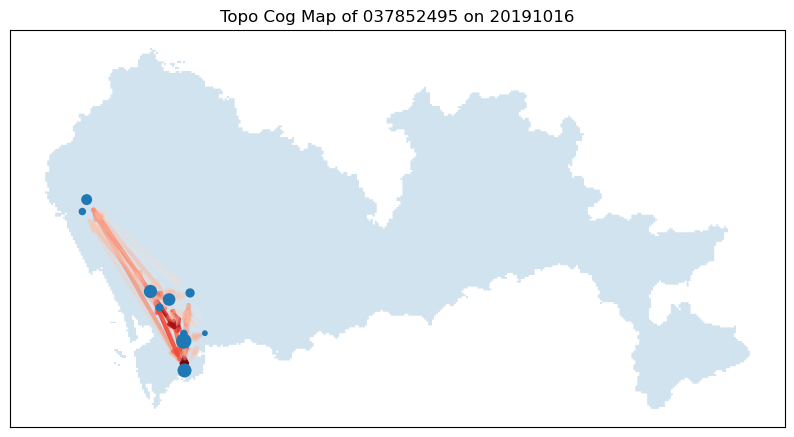

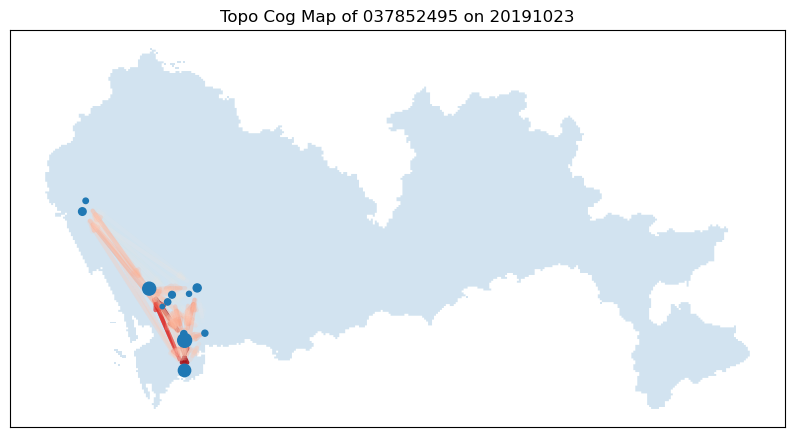

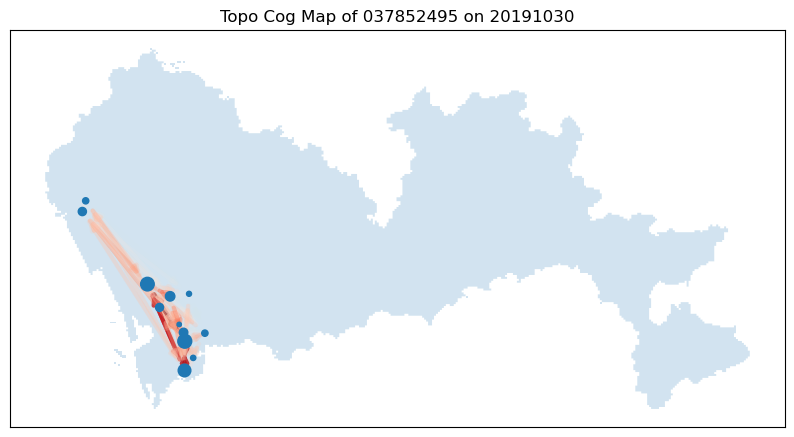

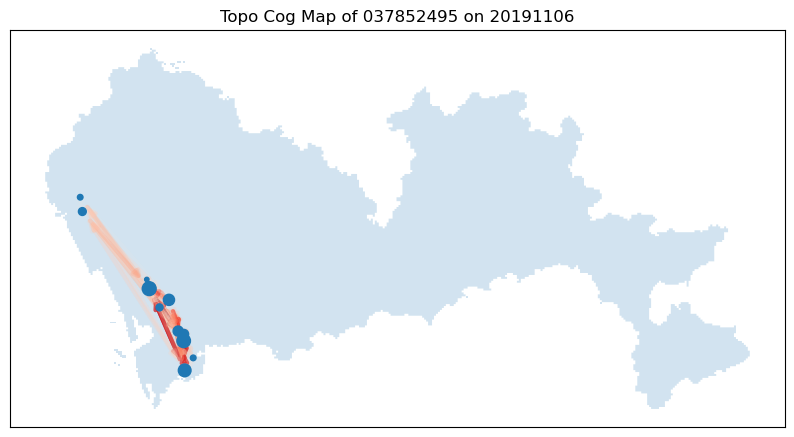

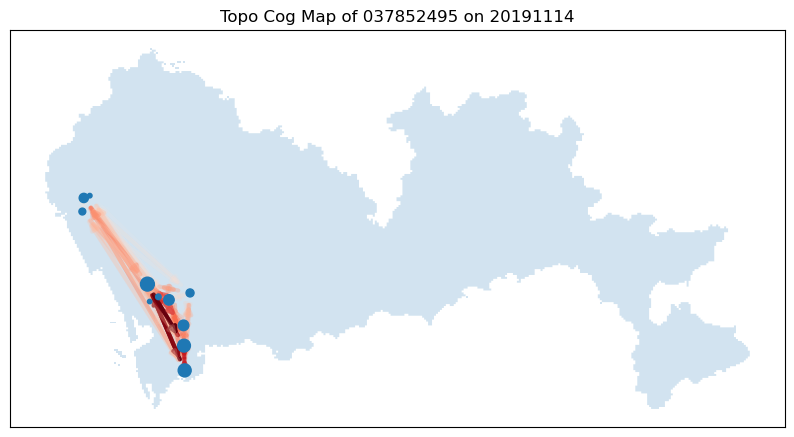

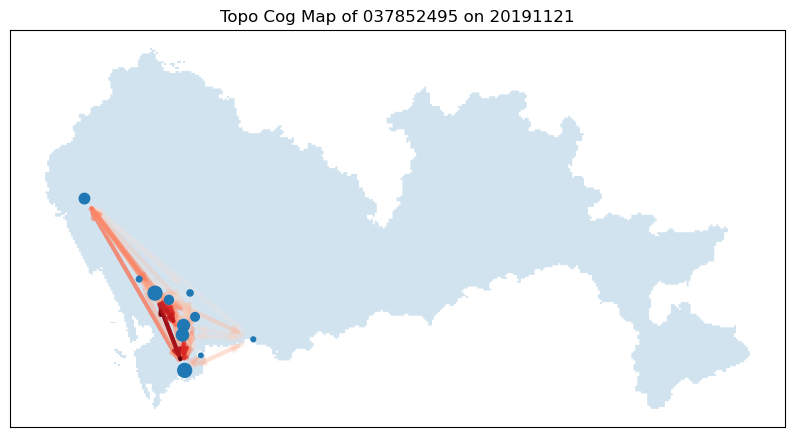

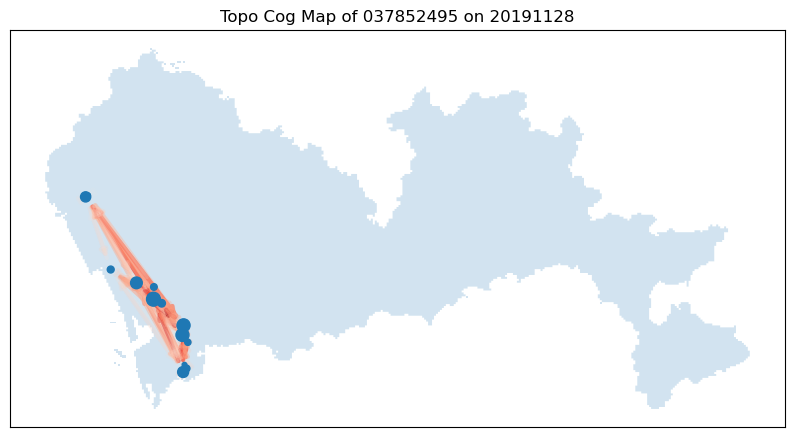

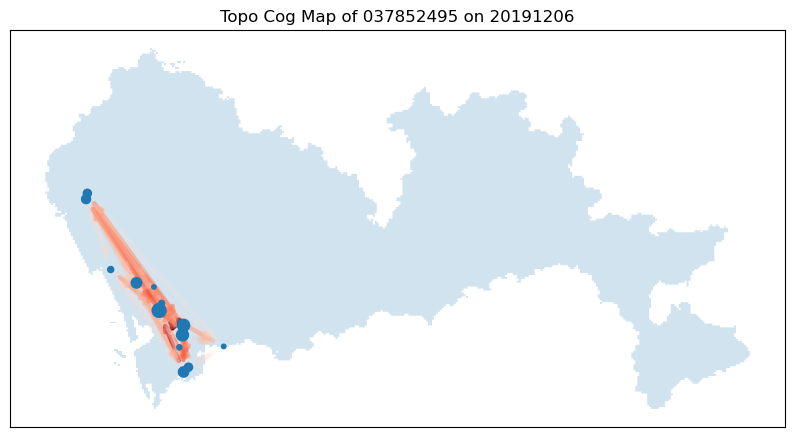

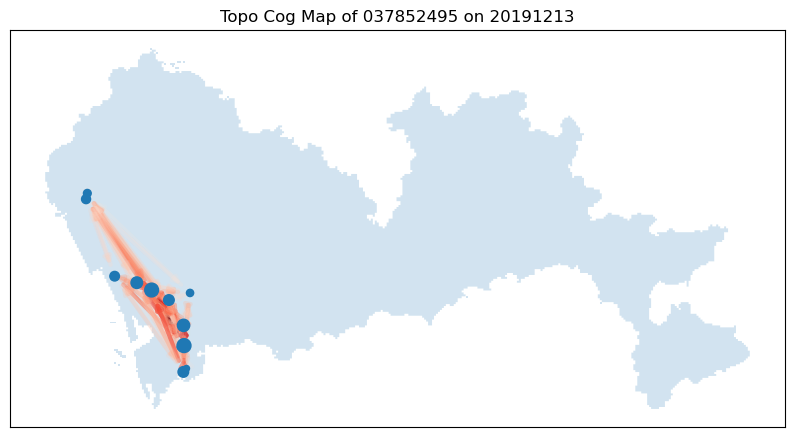

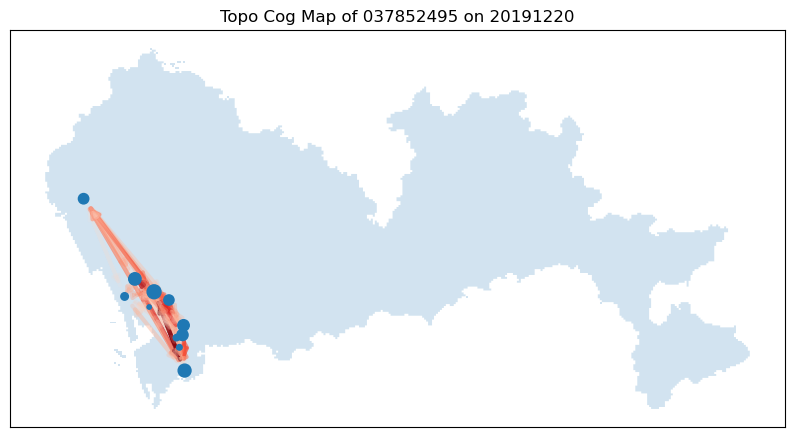

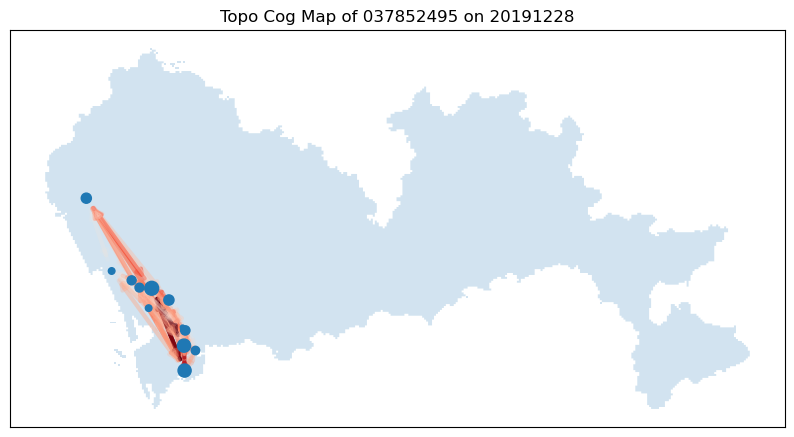

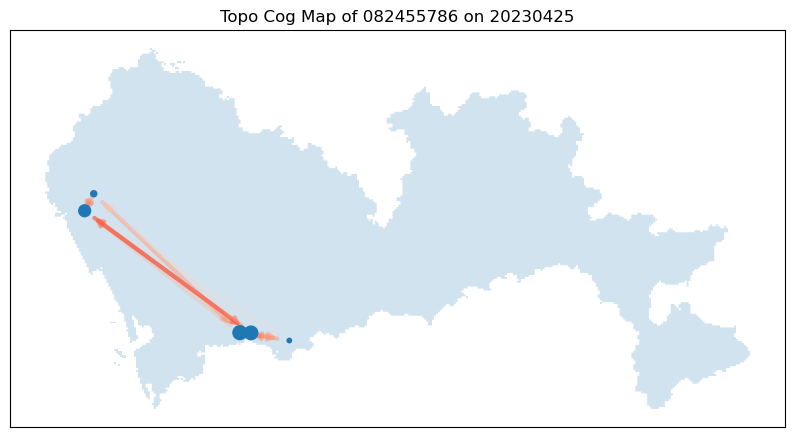

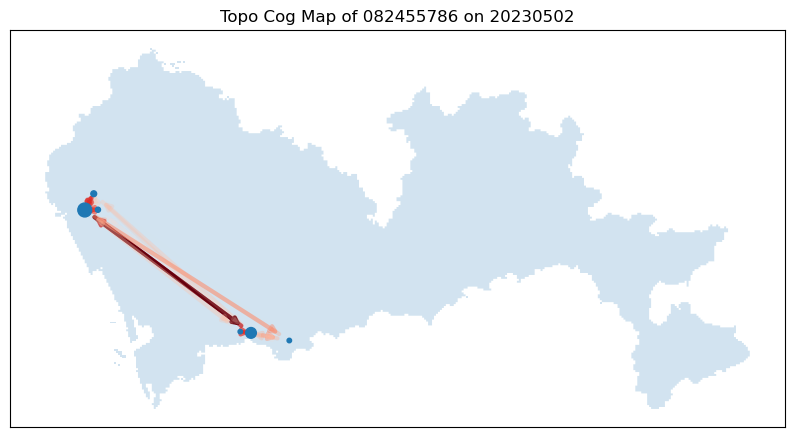

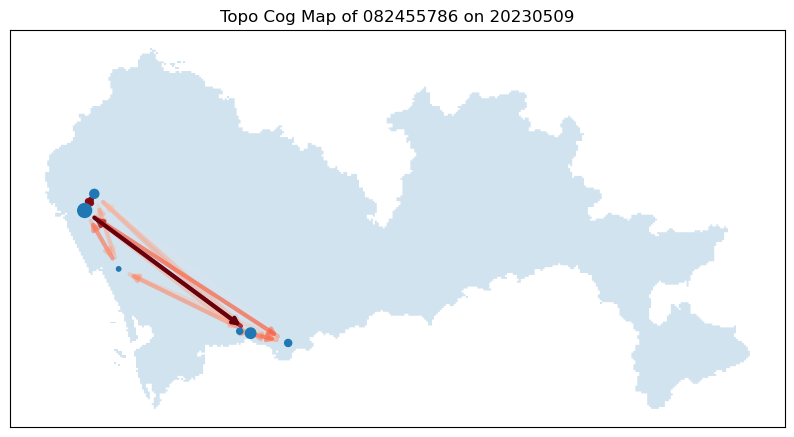

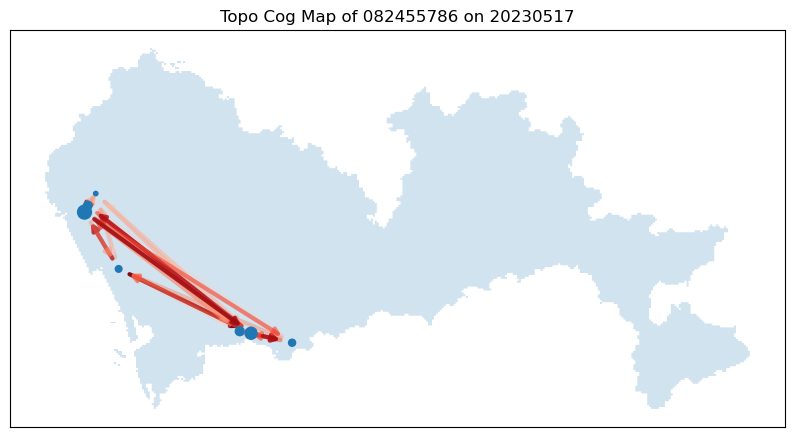

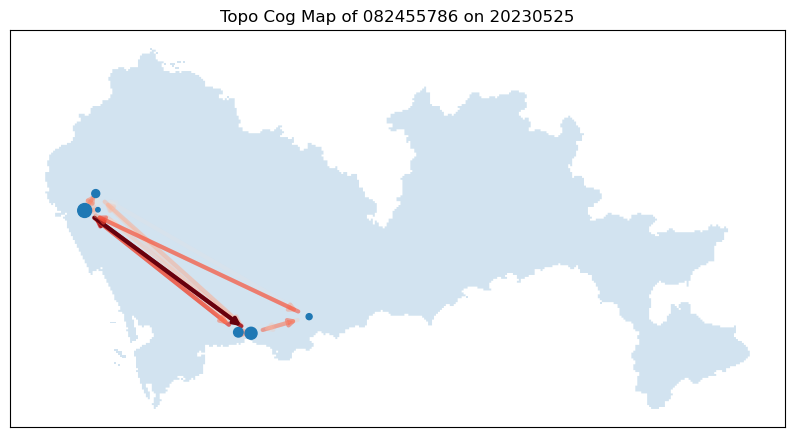

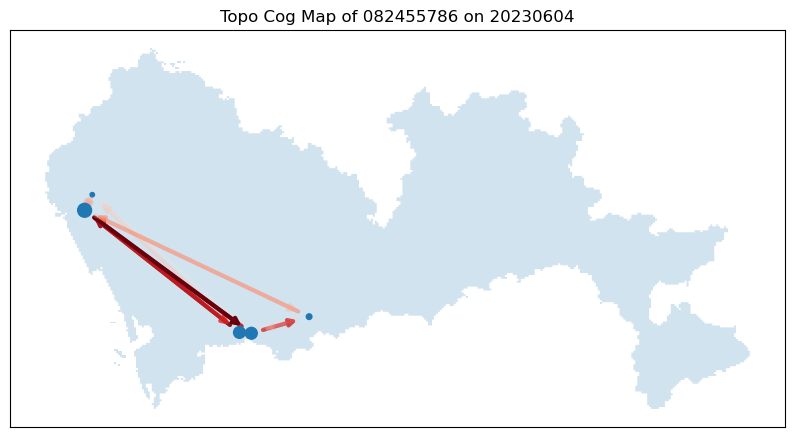

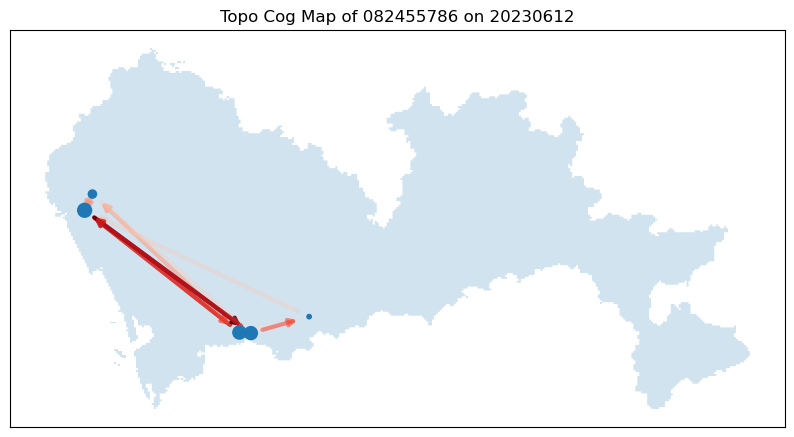

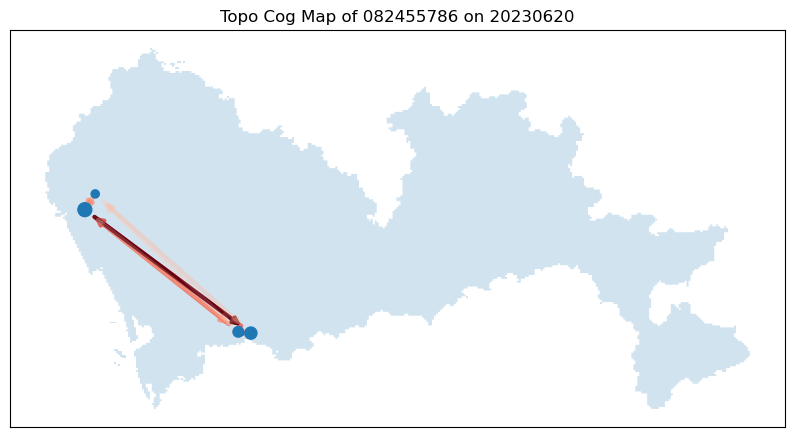

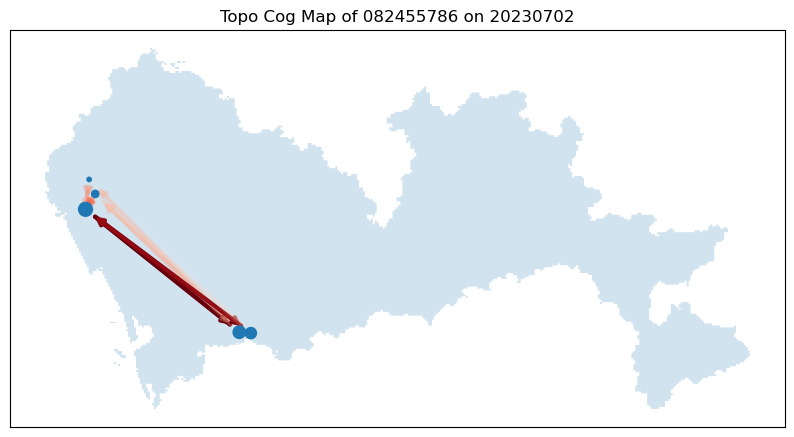

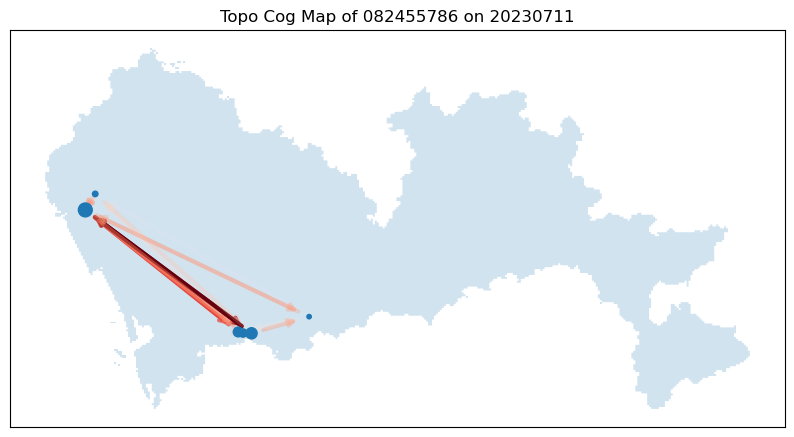

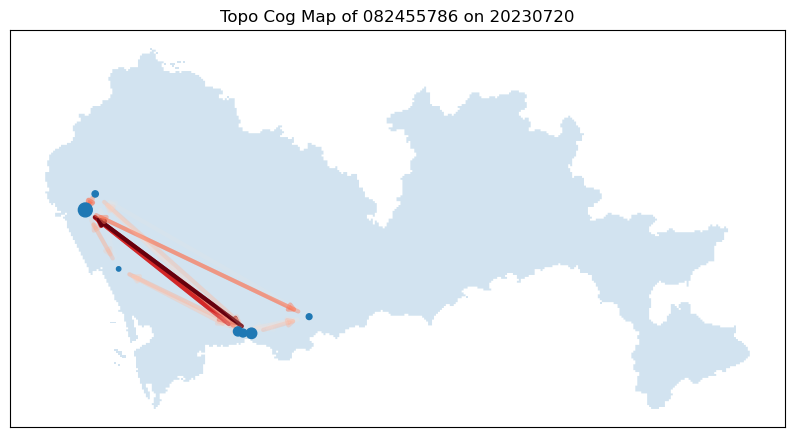

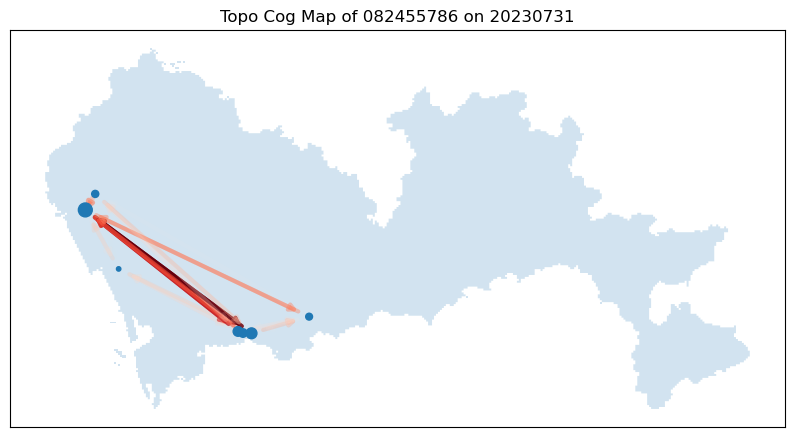

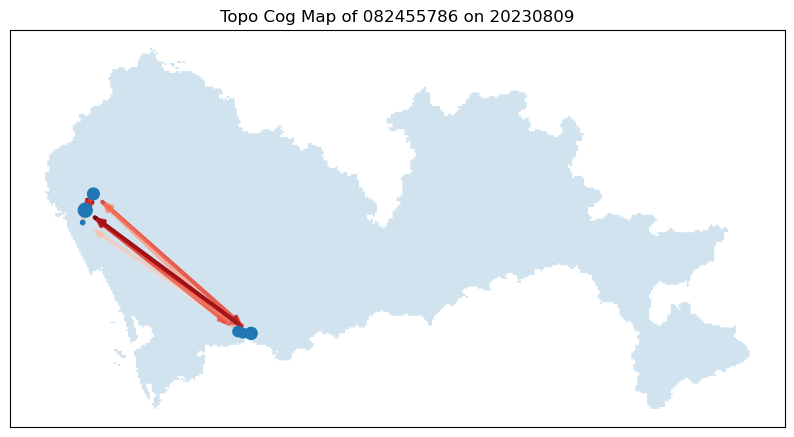

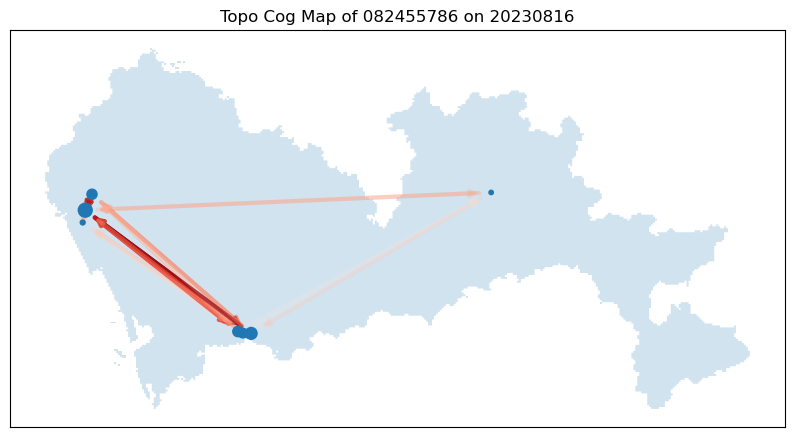

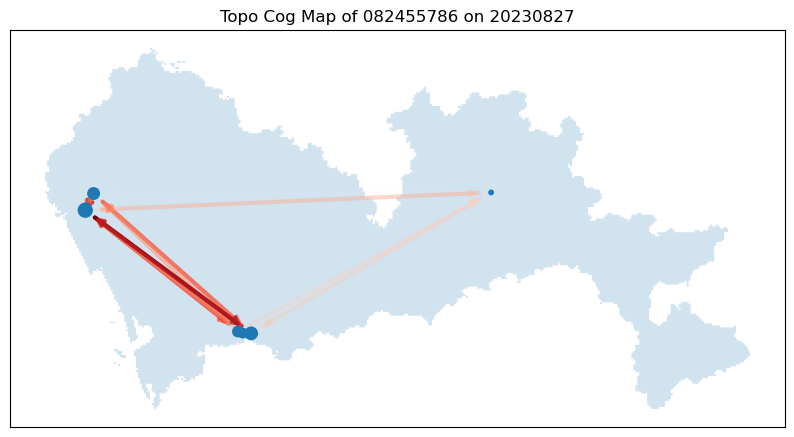

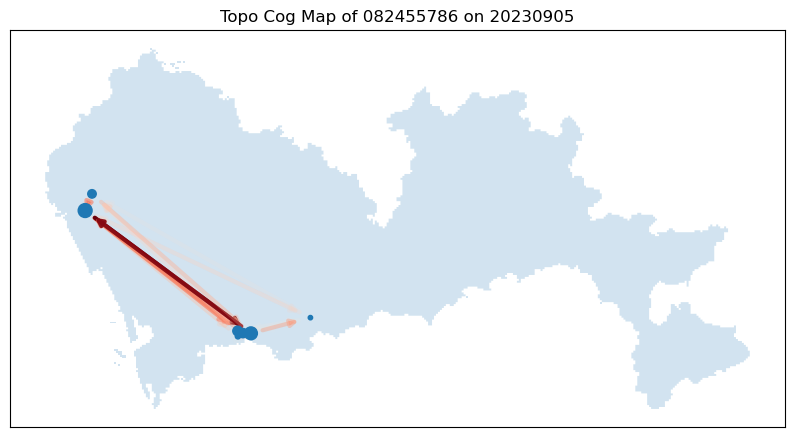

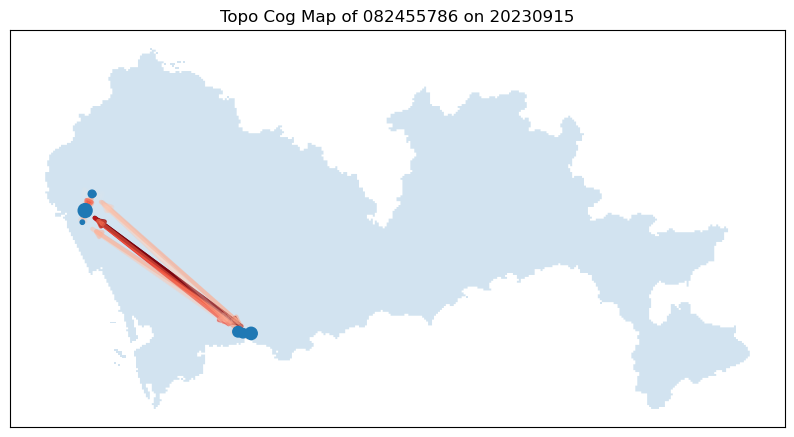

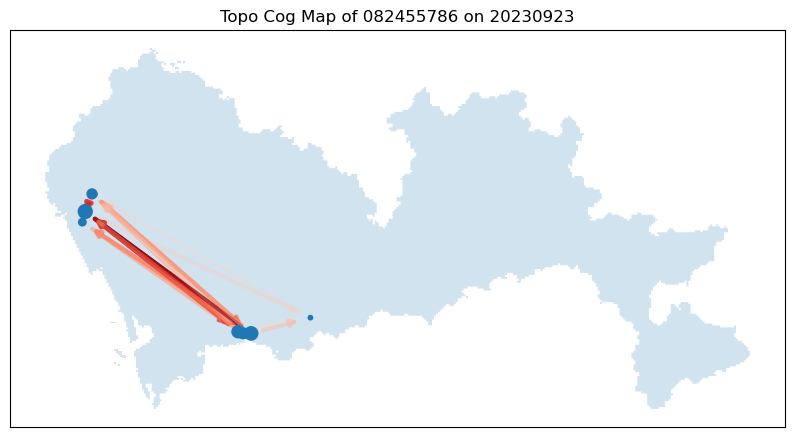

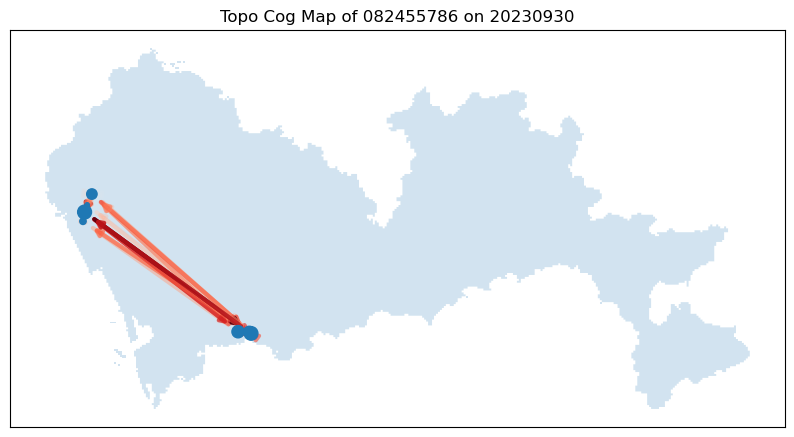

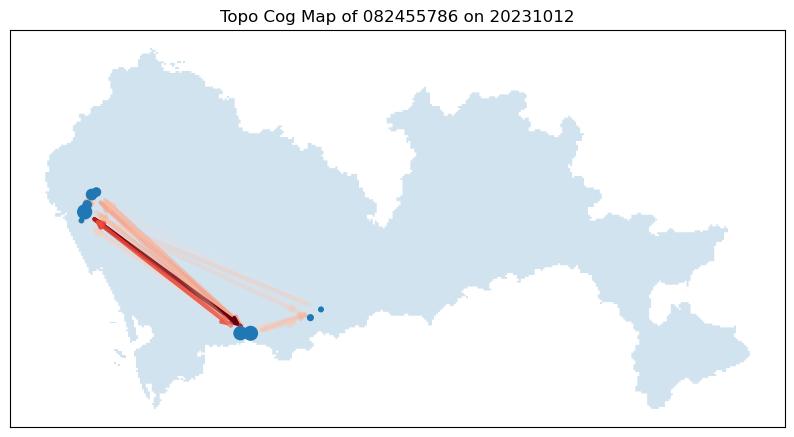

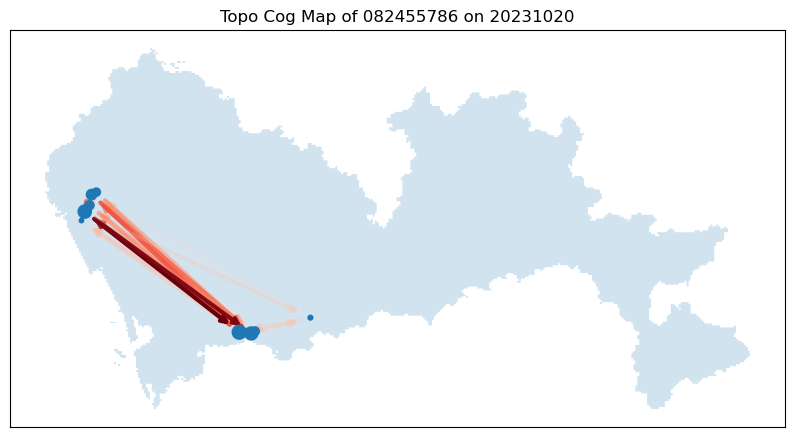

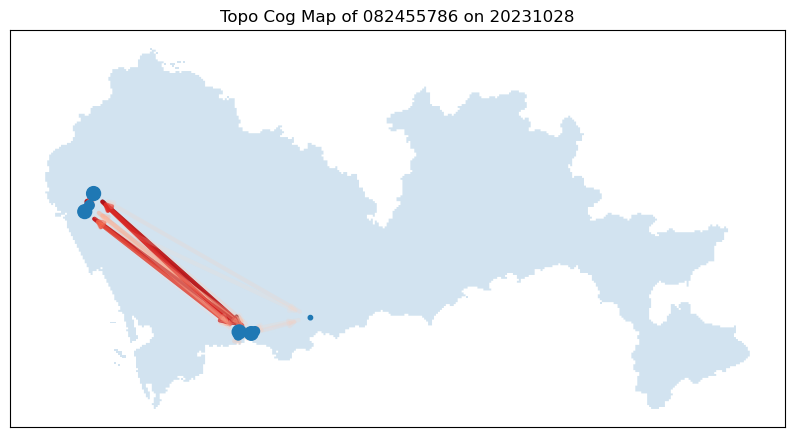

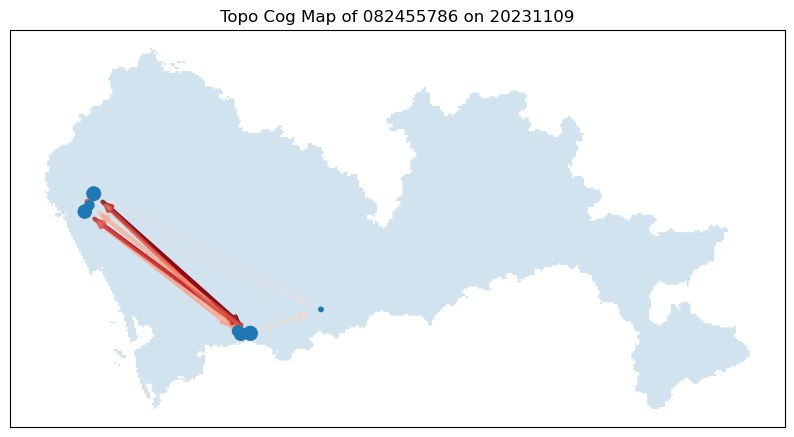

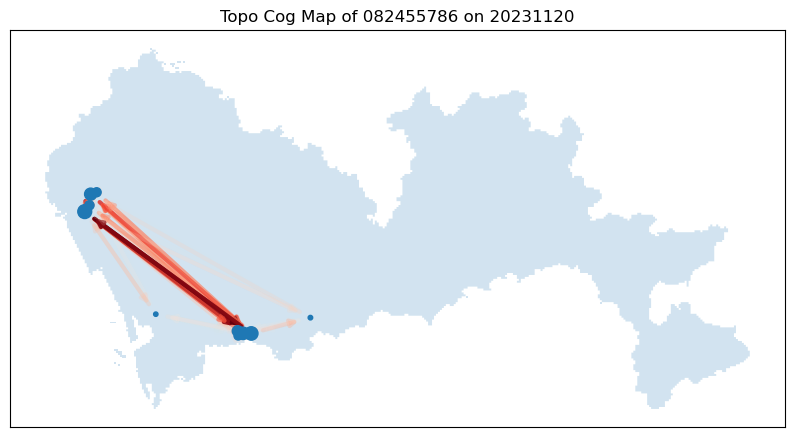

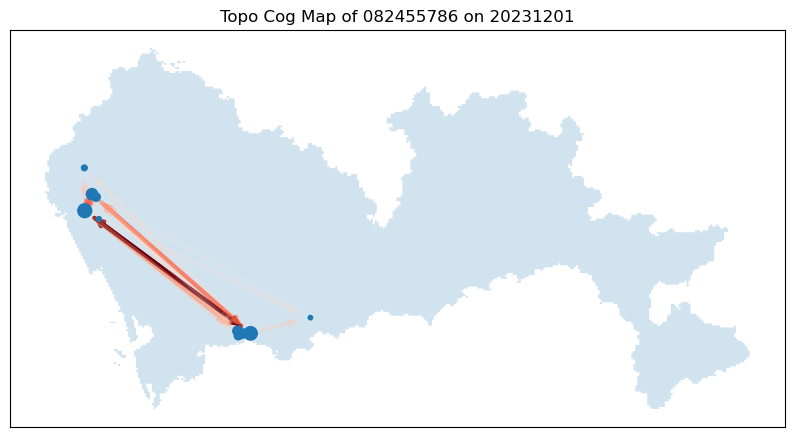

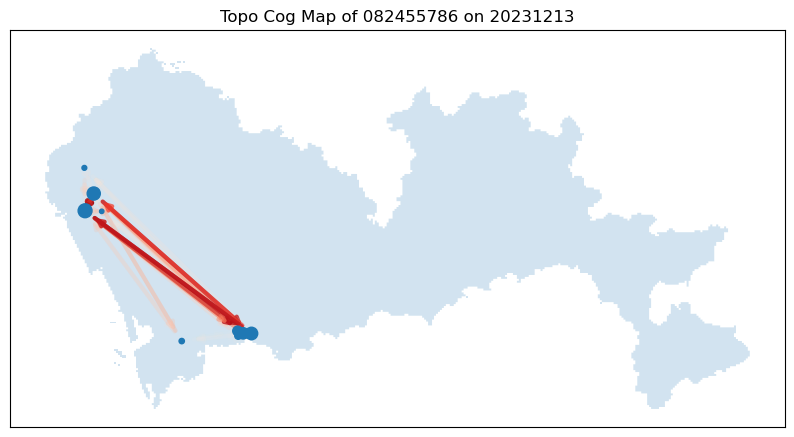

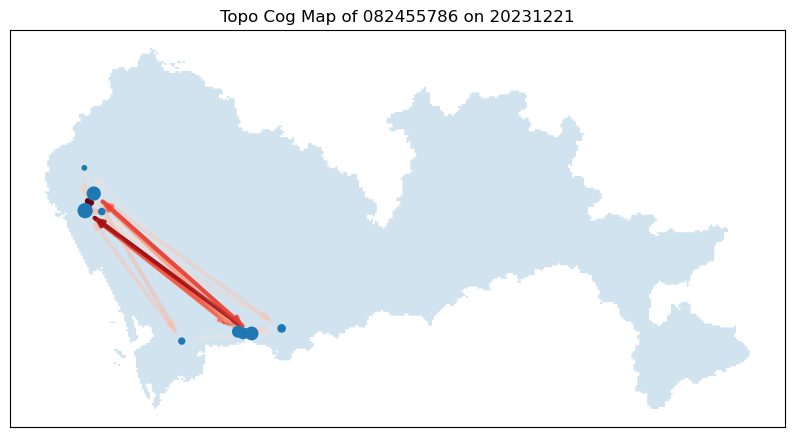

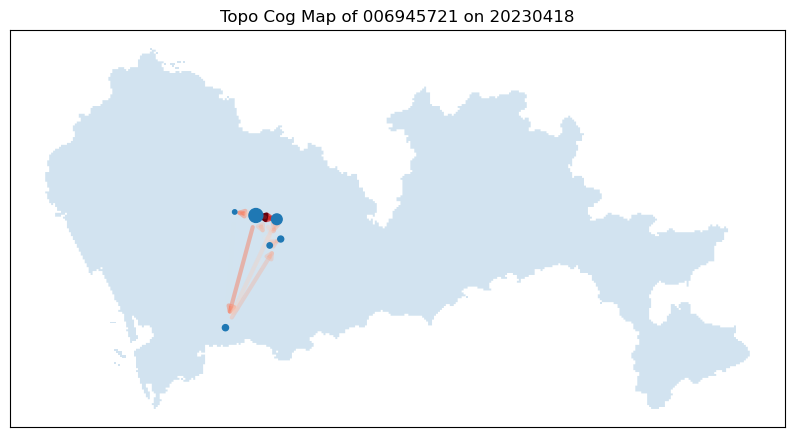

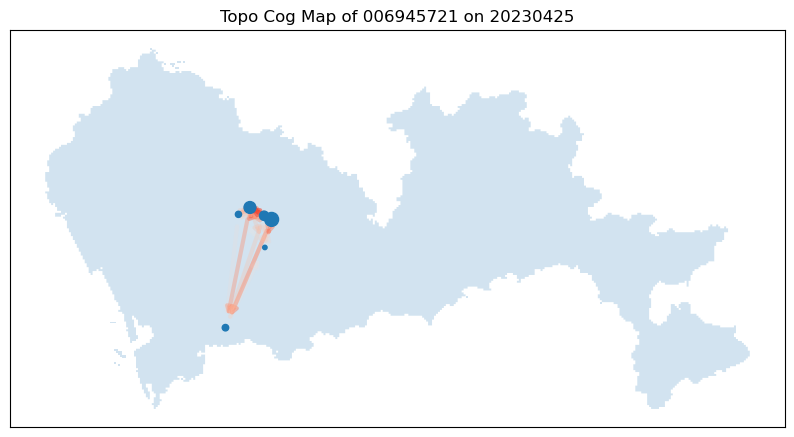

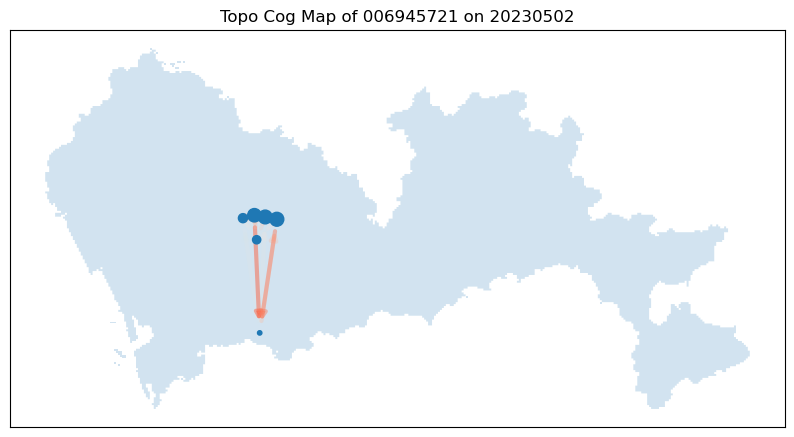

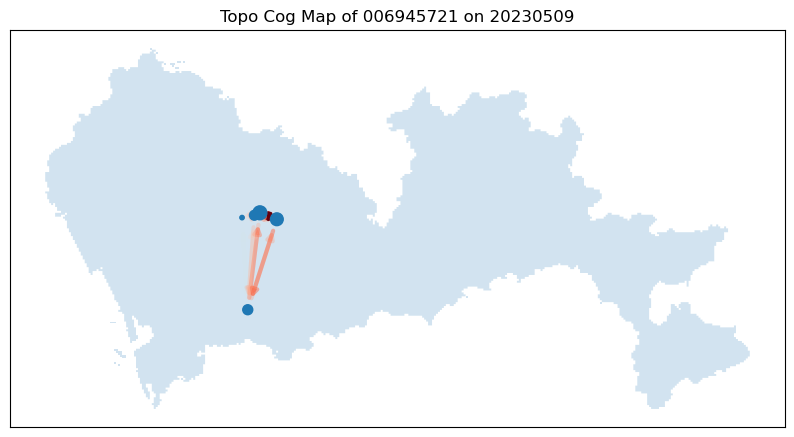

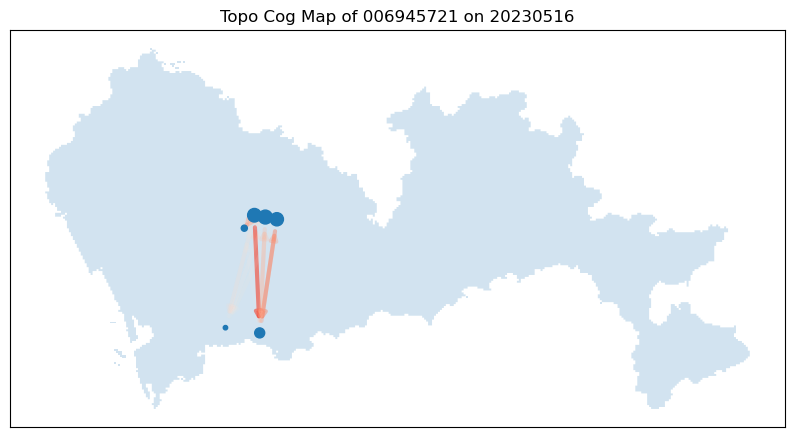

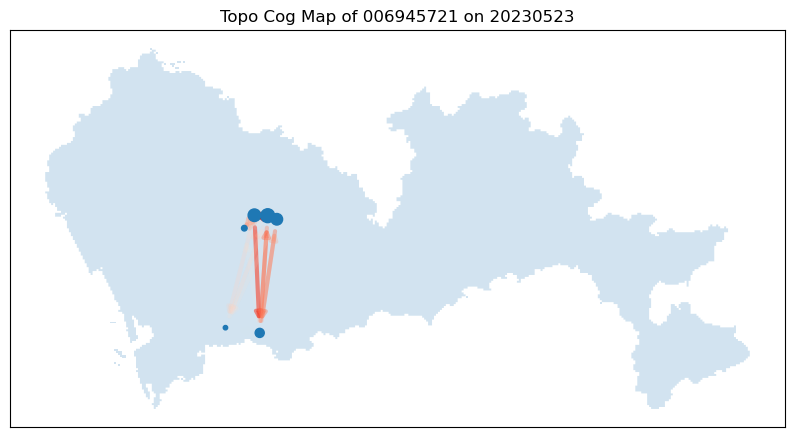

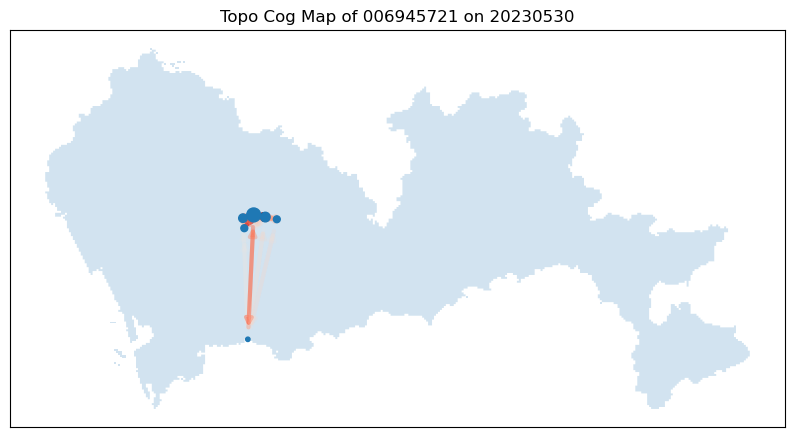

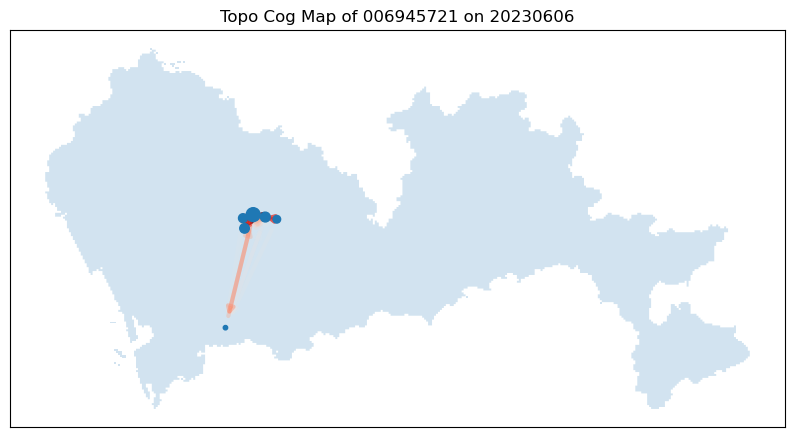

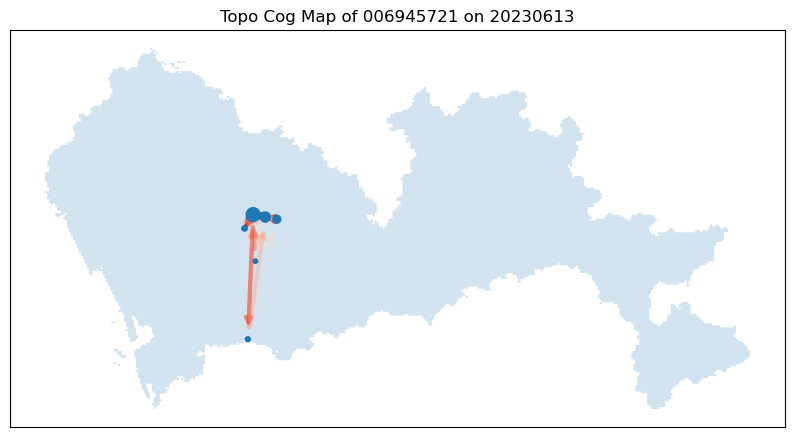

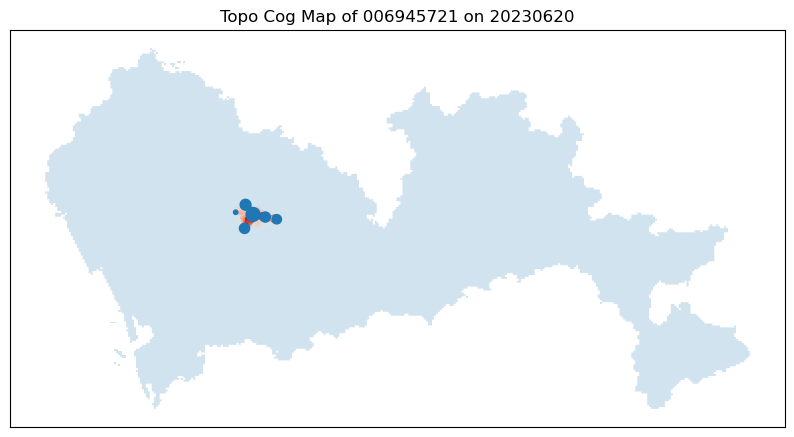

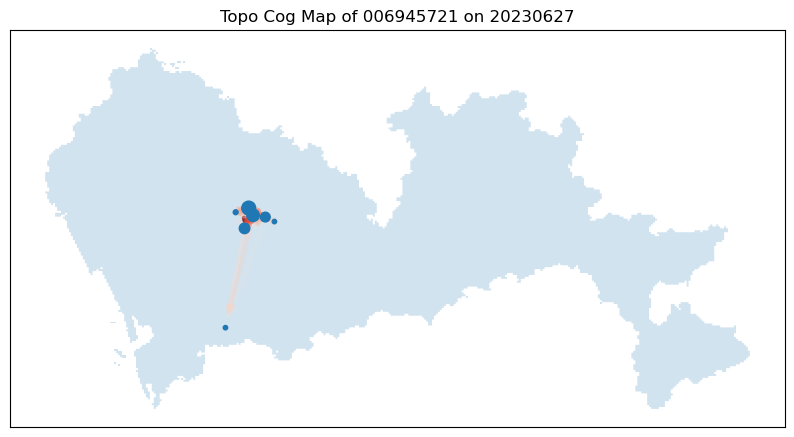

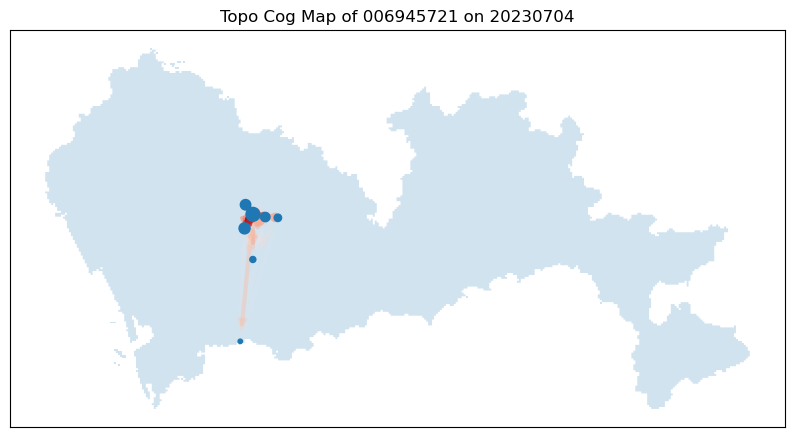

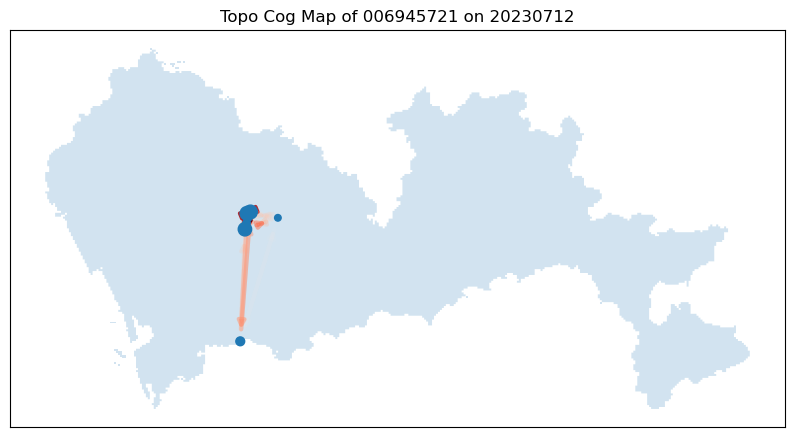

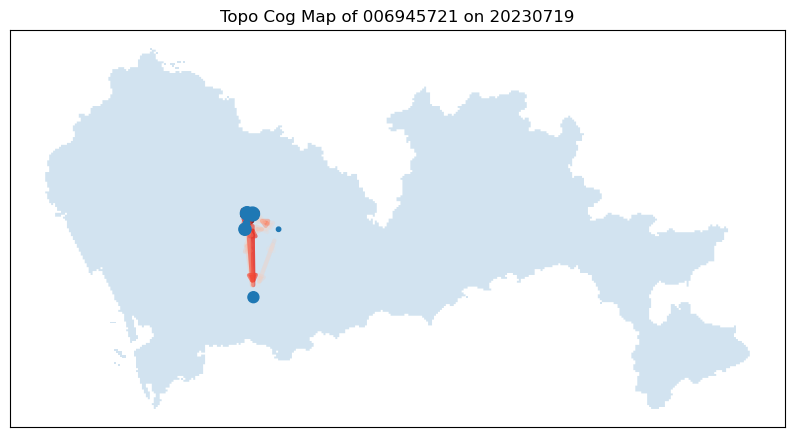

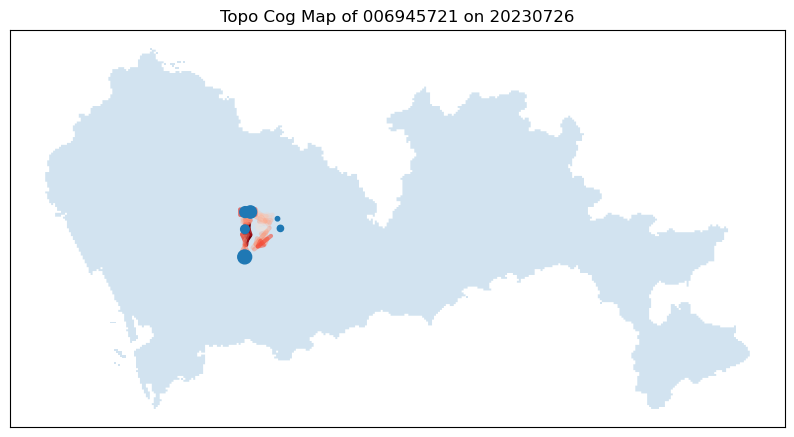

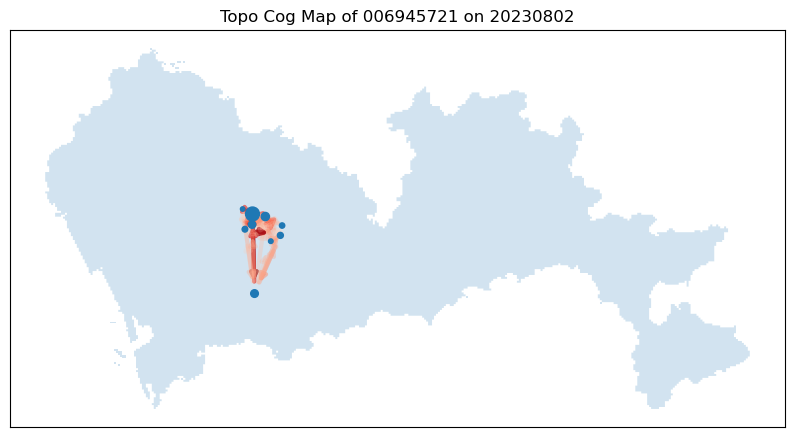

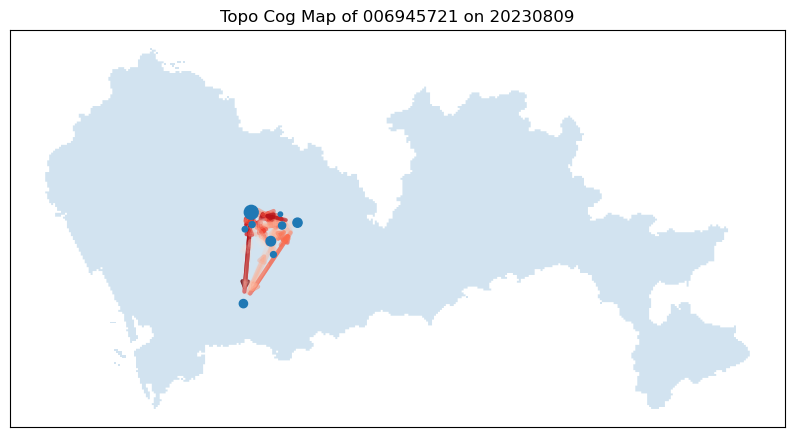

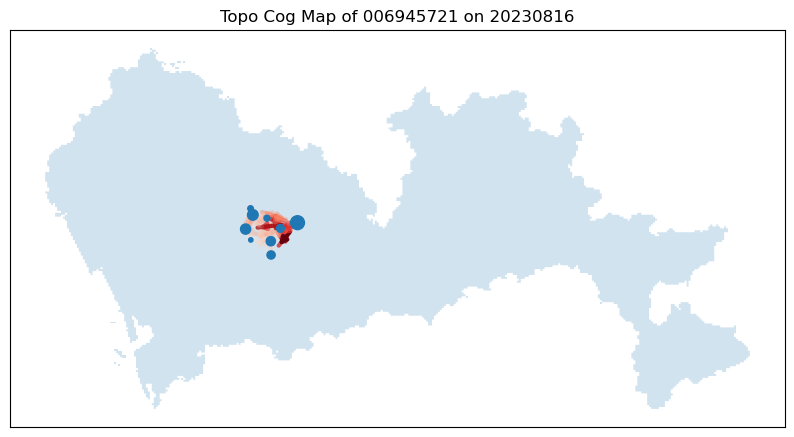

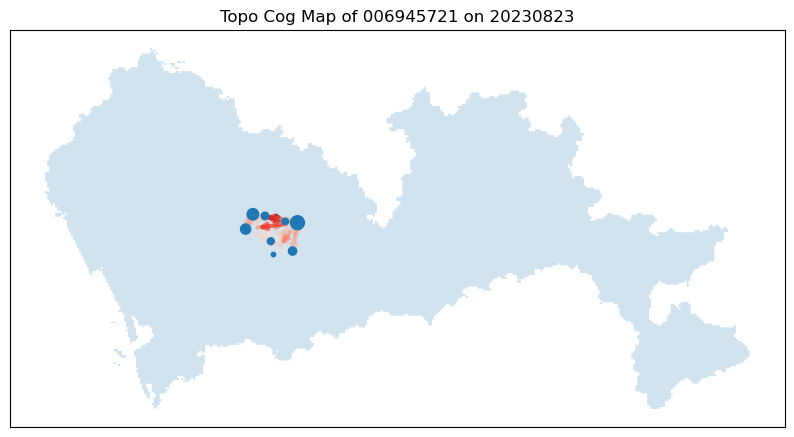

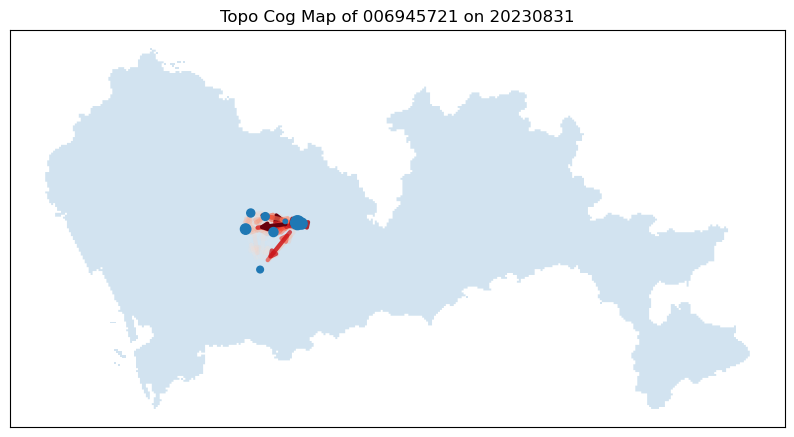

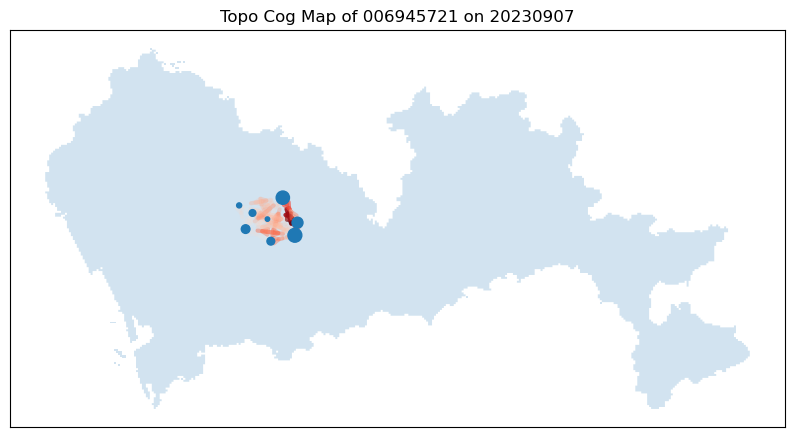

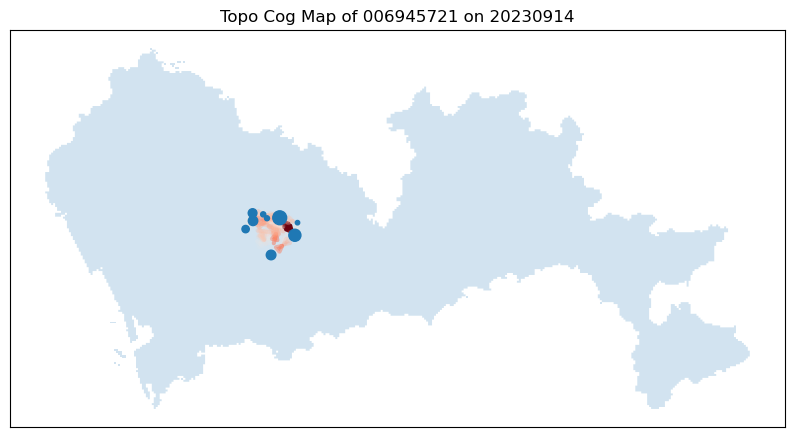

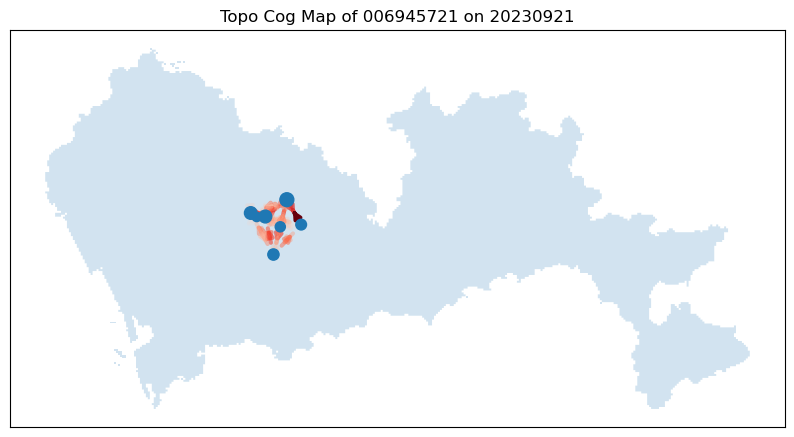

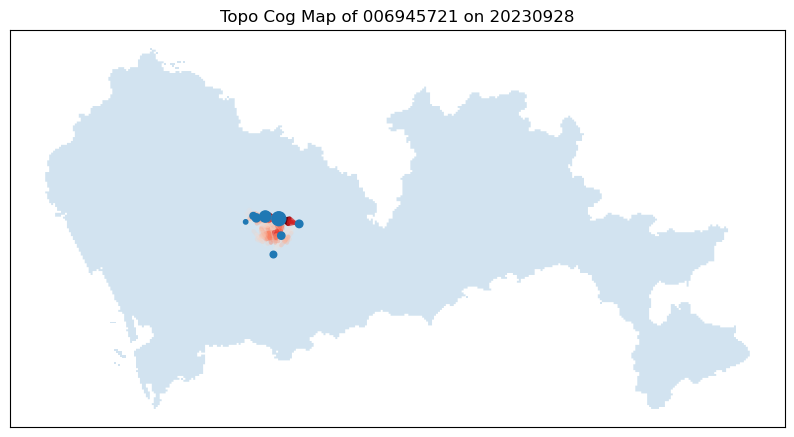

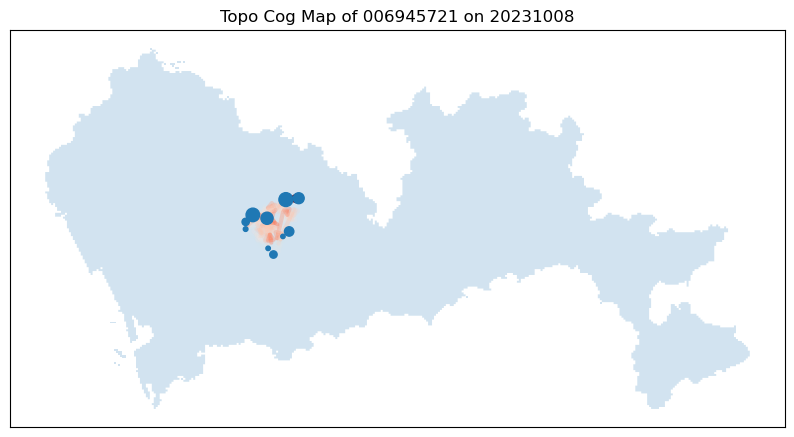

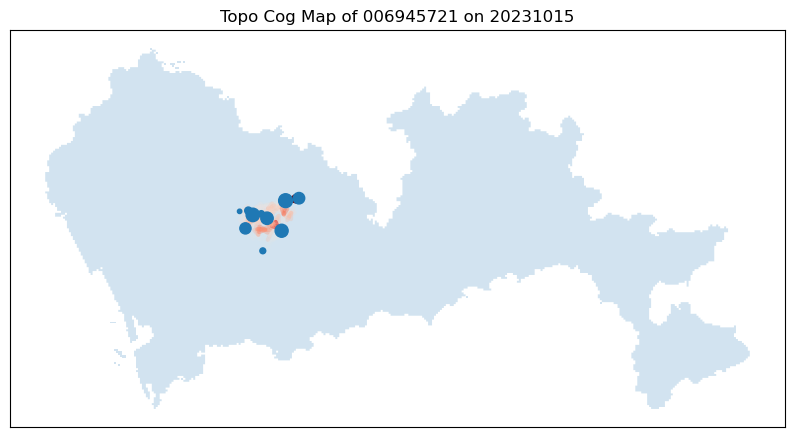

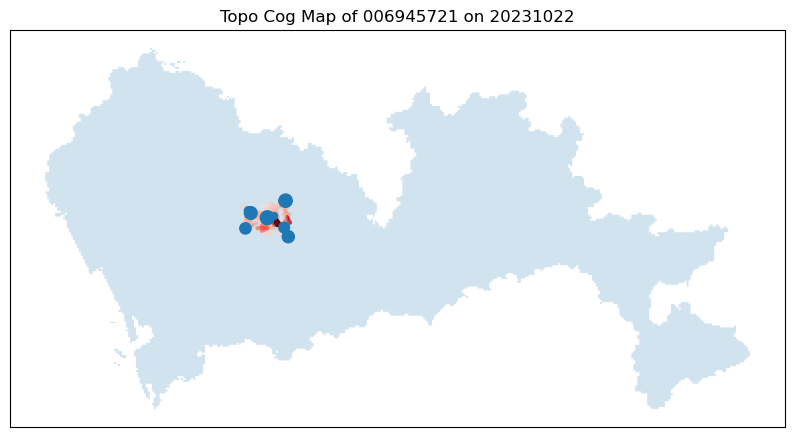

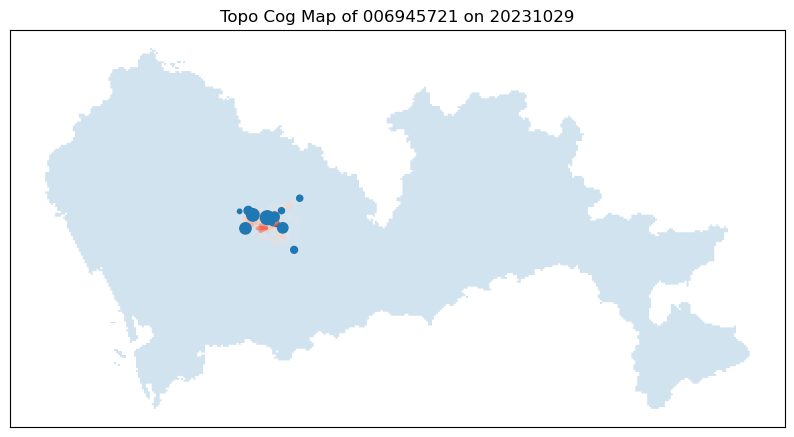

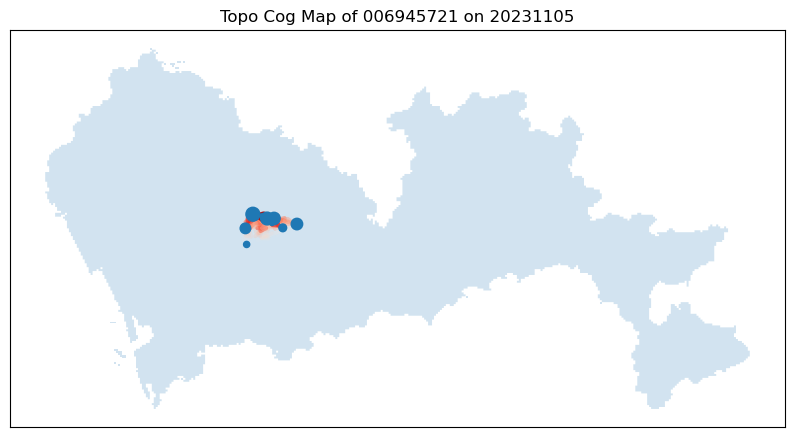

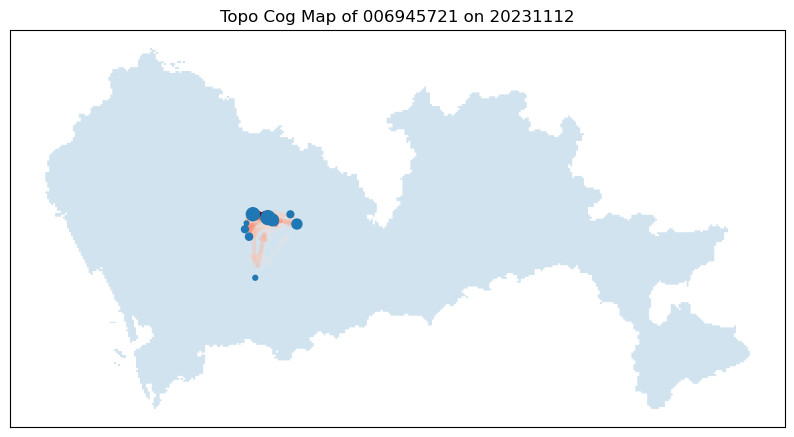

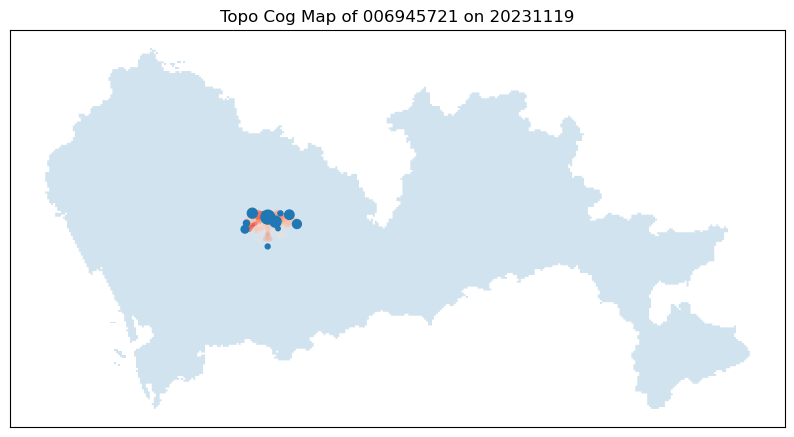

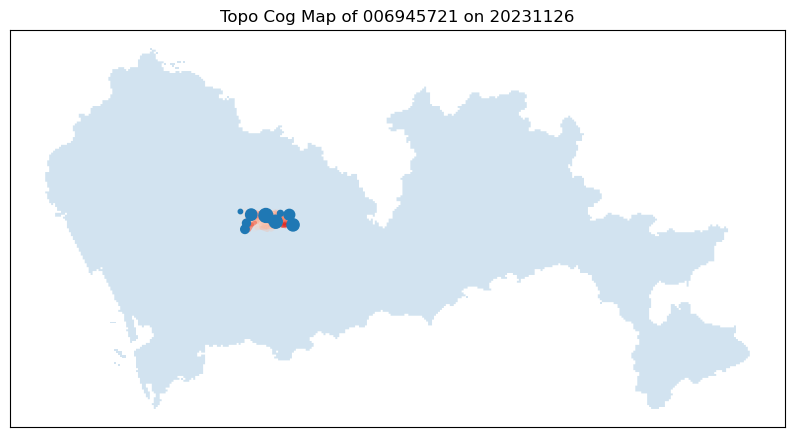

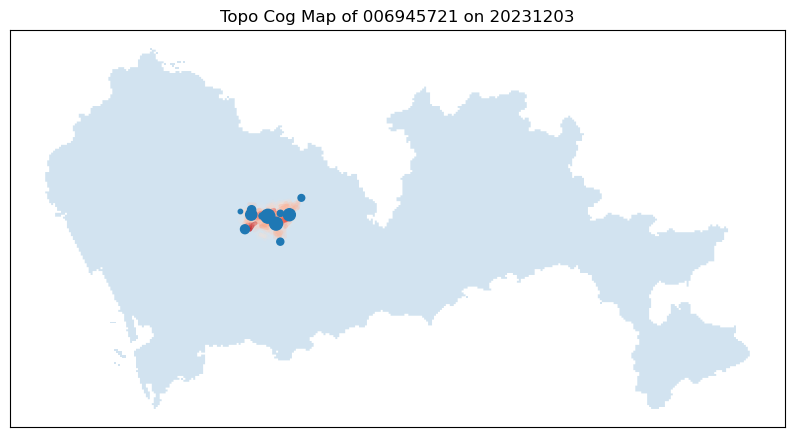

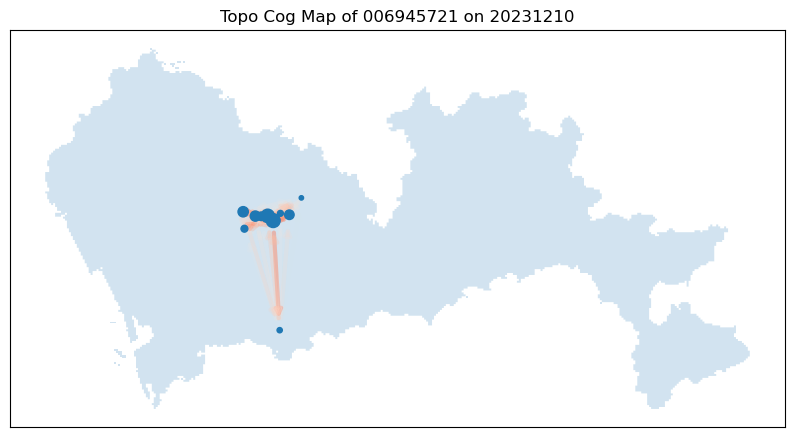

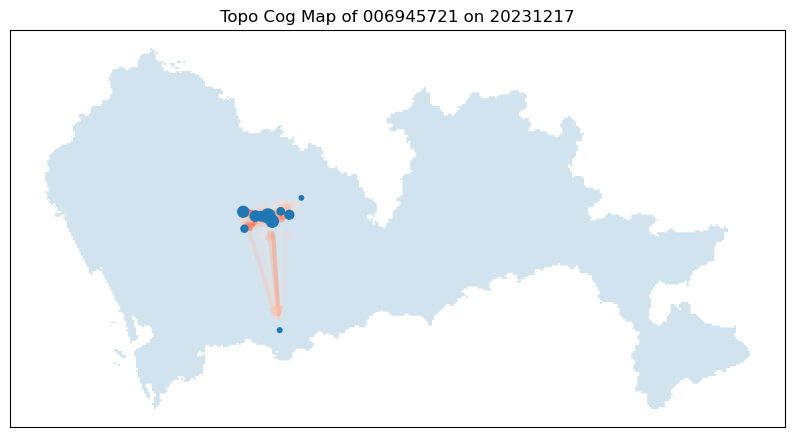

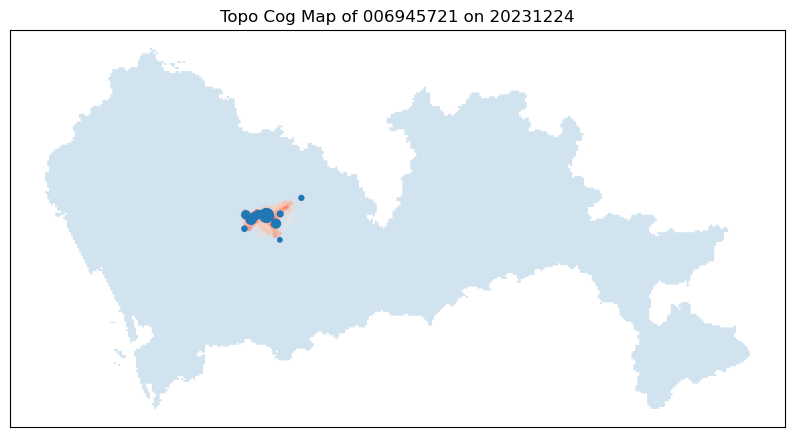

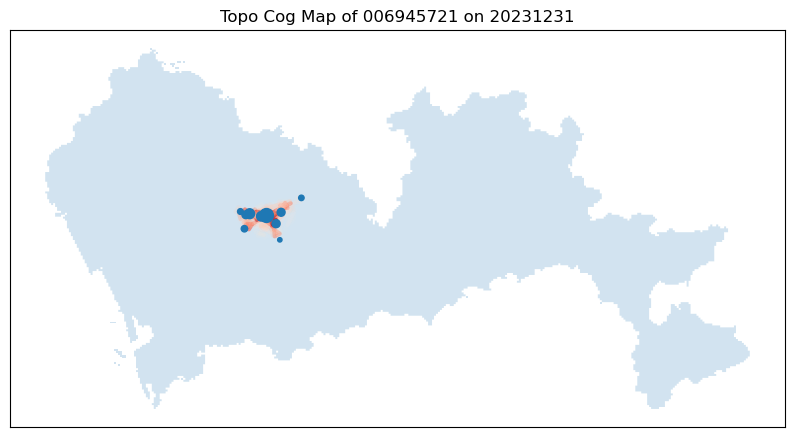

In [108]:
keypair = list(topoMapResult.keys())
user_set = set(list(zip(*keypair))[0])

for user in user_set:
    images = []
    for k, v in topoMapResult.items():
        if user in k:
            f = drawNetworkOnMap(k, v)
            img = fig_to_image(f)
            images.append(img)
    imageio.mimsave('../product/visualization/topoMap_{user}.gif'.format(user=user), images, fps=1)  

Function starts.
weights:  [0.014375445460188405, 0.016338435740227884, 0.022054051902993966, 0.03062002455297883, 0.018679477576408976, 0.027246983689884492, 0.011520429472196428, 0.018567050607395885, 0.01255270886865516, 0.020596931761560782, 0.01828376187928164]
node_size:  [0.10190932008527055, 0.13446165447847994, 0.13773944818370512, 0.11162027801068754, 0.10582346553201706]


/tmp/ipykernel_2110797/2050317144.py:77: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, width=3, alpha = alphaw, edge_color=weights,


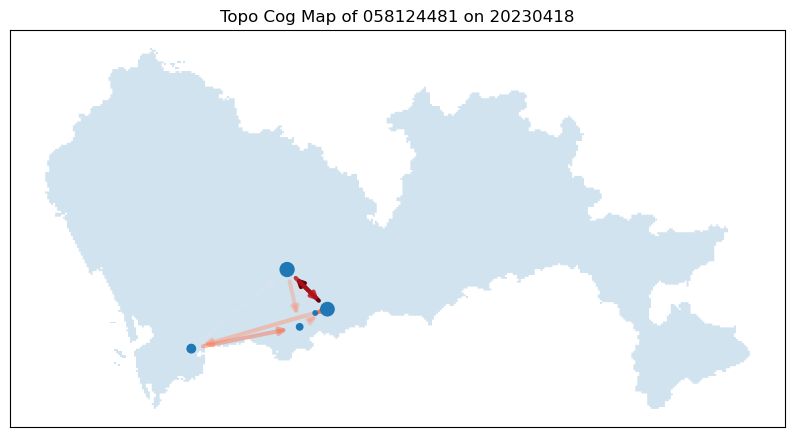

d:\Application\Conda\envs\geoneuro\lib\site-packages\pandas\core\dtypes\cast.py:126: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


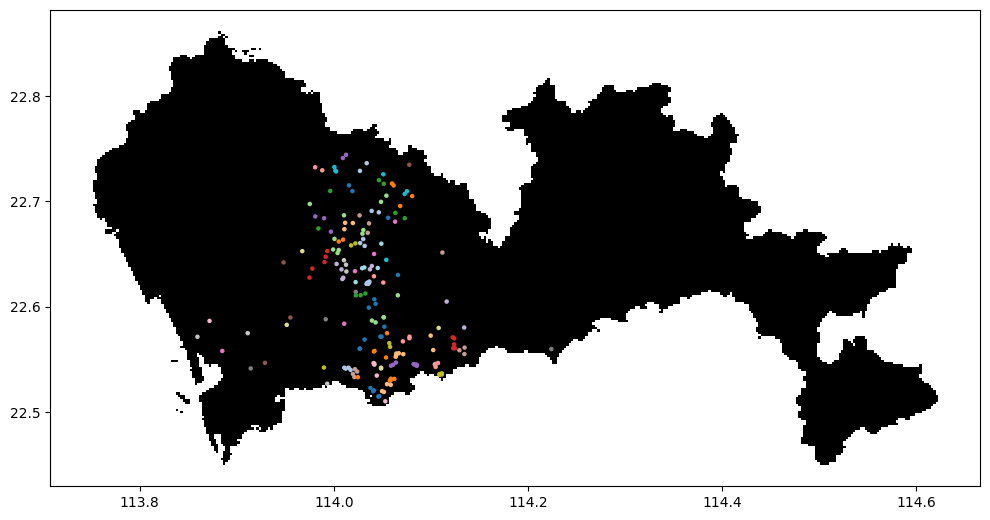

In [52]:
# plot the shenzhen grid
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
shenzhen_grid.plot(ax=ax, edgecolor='white', facecolor='black')

# plot the clustered points, color-coded by cluster
# create the points geopandas dataframe
points = pd.DataFrame()
points['geometry'] = [Point(id_coorders_mapping_edit[key]) for key in keylist]
points['cluster'] = cluster_labels
points = gpd.GeoDataFrame(points, crs=4326, geometry='geometry')
points.plot(ax=ax, column='cluster', legend=True, markersize=5, cmap='tab20')
# ref off the color legend
# ref brute force method:
fig.delaxes(fig.axes[1])


In [53]:
fig.savefig('clustered_points.png')

In [45]:
explore = points.explore("cluster", cmap='tab20', marker_kwds={'radius': 8})
explore.save('./Topomap.html')

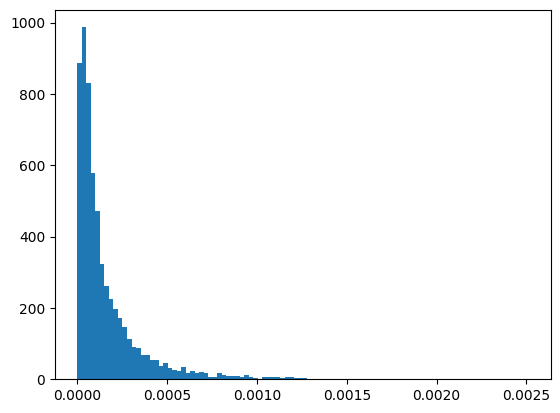

In [202]:

plt.hist(transitionCorrected.flatten(), bins=100)
plt.show()


In [243]:

def draw_pentagram(ax, position, size=0.01, color='red'):
    # Points of a regular pentagon
    pentagon = np.array([[np.cos(2 * np.pi * i / 5), np.sin(2 * np.pi * i / 5)] for i in range(5)])
    pentagon = size * pentagon + position

    # Draw lines for the star
    for i in range(5):
        start = pentagon[i]
        end = pentagon[(i + 2) % 5]
        ax.plot([start[0], end[0]], [start[1], end[1]], color=color)

def drawNetworkOnMap(shenzhen_grid,  alpha=0.2):
    print("Function starts.")

    # Create a graph from the CSV data
    G = nx.DiGraph()
    for i, coord in enumerate(cluster_coords_array):
        if not np.isin(i, smalllest_idx_weight):
            G.add_node(str(coord), pos=coord, weight=weight[i, 0])

    # count = 10
    size = len(cluster_coords_array)
    for i in range(size):
        if np.isin(i, smalllest_idx_weight):
            continue
        for j in range(size):
            if i != j and not np.isin(j, smalllest_idx_weight):
                weight_value = transAdj[i, j]
                if weight_value > 0:
                    G.add_edge(str(cluster_coords_array[i]), str(cluster_coords_array[j]), weight=weight_value)
    # Extract and scale weights for the edges
    weights = [G[u][v]['weight'] for u, v in G.edges()]
    print("weights: ", weights)
    alphaw = np.interp(weights, (min(weights), max(weights)), (0, 1))
    # Extract the size weighs for the nodes
    node_size = [G.nodes[n]['weight'] for n in G.nodes()]
    print("node_size: ", node_size)
    node_size = np.log(np.array(node_size))
    node_size = np.interp(node_size, (min(node_size), max(node_size)), (10, 100))
    # Position
    pos = nx.get_node_attributes(G, 'pos')
    # Plot the network on the map
    f, ax = plt.subplots(1, 1, figsize=(20, 20))
    nx.draw_networkx_nodes(G, pos, ax=ax, node_size=node_size)
    nx.draw_networkx_edges(G, pos, width=3, alpha = alphaw, edge_color=weights, 
                           edge_vmax=max(weights),
                           edge_cmap=plt.cm.Reds, arrows=True, arrowstyle='-|>', ax=ax)
    shenzhen_grid.plot(ax=ax, linewidth=1, alpha=alpha)

    plt.show()

Function starts.
weights:  [0.0012382604567747204, 0.000932022118599141, 0.0006941621465214255, 0.0010483146268194636, 0.0012285887103358933, 0.0017853605149637773, 0.0008160314604171588, 0.0009191635823485395, 0.0007960229183166636, 0.0007942528960061822, 0.0008484614452256614, 0.0011323233325483814, 0.0008695628741730321, 0.00173416442300732, 0.0011049100555995956, 0.0010706831986672673, 0.0007927882425129982, 0.002146534718670174, 0.0014684612831335274, 0.000475832963590176, 0.0005919407345412669, 0.0005834791991256744, 0.0009752357061798741, 0.00115091525667469, 0.0007854137836895061, 0.0007123187283003294, 0.0004965914996016846, 0.0005255827314477679, 0.0005674711645361103, 0.0007799877143278223, 0.00067765728859515, 0.0010804795823981571, 0.0008715938680699406, 0.0006415916767669907, 0.0007989711465942932, 0.0015815710569557742, 0.0008551616842967574, 0.0006347739245922734, 0.00038537082263914165, 0.0005113750744755011, 0.0006203032725149423, 0.0009314316512602969, 0.000433081598

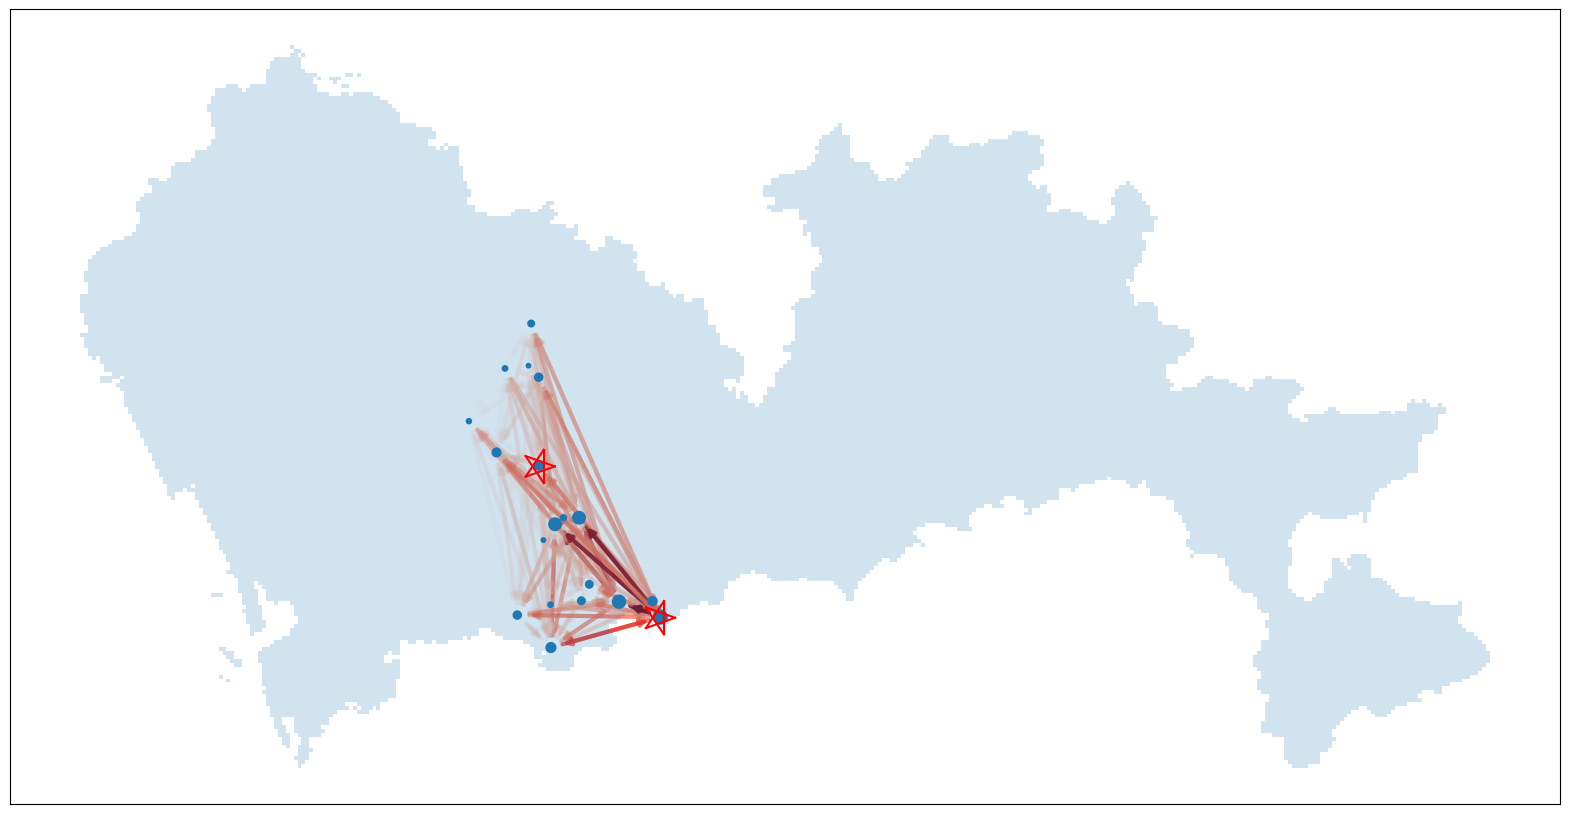

In [244]:
drawNetworkOnMap(shenzhen_grid, alpha=0.2)